# Create Environment

In [43]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from tqdm import tqdm

global N

N=100

global M
M=10

global T
global target
T=25
target=np.array([3,2])
global w
w=np.pi*2/23.7

global delta_t
delta_t=T/N

global beta
beta=[0.9,0.95,1,1.05,1.1]

global num_system
num_system=5

In [44]:
def Z(vecs, u, v):
    output=[]
    for i in range(num_system):
        vec=vecs[i]
        x=vec[0]
        y=vec[1]
        theta=vec[2]
        output.append([beta[i]*np.cos(theta)*u,beta[i]*np.sin(theta)*u,beta[i]*v])
    return np.array(output)

#check the correctness of Z
'''
x = np.linspace(0, 6.5, 1001)
plt.plot(x, Z(x))
plt.xlabel('Angle [rad]')
plt.ylabel('Z(theta)')
plt.grid()
plt.show()
'''

"\nx = np.linspace(0, 6.5, 1001)\nplt.plot(x, Z(x))\nplt.xlabel('Angle [rad]')\nplt.ylabel('Z(theta)')\nplt.grid()\nplt.show()\n"

In [45]:
def next_step(vecs,action):  
    u=action[0]
    v=action[1]
   
    for j in range(M):
        vecs_new=[]
        diff=Z(vecs,u,v)
        for i in range(num_system):
            w=vecs[i]+delta_t/M*diff[i]
            '''
            if w[2]>np.pi:
                w[2]-=2*np.pi
            if w[2]<-np.pi:
                w[2]+=2*np.pi
            '''
            vecs_new.append(w)
        vecs=np.array(vecs_new)
    return vecs

def observe(vecs):
    mu_x=0
    mu_y=0
    mu_theta=0
    var_x=0
    var_y=0
    for i in range(num_system):
        mu_x+=vecs[i][0]
        mu_y+=vecs[i][1]
        mu_theta+=vecs[i][2]
        var_x+=vecs[i][0]**2
        var_y+=vecs[i][1]**2
    var_x-=mu_x**2/num_system
    var_y-=mu_y**2/num_system
    
    w=np.array([mu_x,mu_y,mu_theta,var_x,var_y])/num_system
    if w[2]>np.pi:
        w[2]-=2*np.pi
    if w[2]<-np.pi:
        w[2]+=2*np.pi
    return w

def reward(obs):
    return -(obs[0]-target[0])**2-(obs[1]-target[1])**2-obs[3]-obs[4]

def reward_raw(position):
    r=0
    for i in range(num_system):
        r+=np.linalg.norm(position[i,[0,1]]-target)
    return r

def value_func(funcs,flags,next_state):
    result=[]
    for i in range(6):
        if flags[i]:
            result.append(-1000)
        else:
            k,_=funcs[i].predict(next_state.reshape(-1,5), return_std=True)
            result.append(k[0])
    result=np.array(result)
    return np.max(result)

# Learning Settings

In [46]:
global lr
lr=0.01
global eps
eps=0.2
global max_u
max_u=2
global precision
precision=0.0002
global action_set
action_set=np.array([[1,np.pi/4],[-1,np.pi/4],[1,0],[-1,0],[1,-np.pi/4],[-1,-np.pi/4]])

def exploration():
    a=np.random.uniform()
    if a<eps:
        return True
    else:
        return False

def find_max(cand):
    return np.argmax(cand)
    
def decide_u(funcs,flags,state,init=False):
    #TODO
    explo=exploration()
    if init or explo:
        return np.random.randint(6)
    else:
        result=[]
        for i in range(6):
            if flags[i]:
                return i
            else:
                k,_=funcs[i].predict(next_state.reshape(-1,5), return_std=True)
                result.append(k[0])
    result=np.array(result)
    return np.argmax(result)
    
def decide_u_exploitation(theta,cand,init=False):
    return find_max(cand)

history_su=[[0 for i in range(6)] for j in range(N+1)]
history_r=[[0 for i in range(6)] for j in range(N+1)]
flags=[[True for i in range(6)] for j in range(N+1)]

# Simulation


In [47]:
num_iter=1000

position_result=[]
observation_result=[]
gpr_list=[[0 for i in range(6)] for j in range(N+1)]

best_r=-10000
best_obs=[]
best_pos=[[] for i in range(num_system)]

for iterr in tqdm(range(num_iter)):
    #initialize
    position=np.array([[-2,-2,0] for _ in range(num_system)])
    observation=observe(position)
    u_t=[]
    r_t=[]
    observation_t=[observation]
    position_t=[[] for i in range(num_system)]
    
    for time in range(N+1):
        if iterr==0:
            #TODO
            #candidates_u=[]
            u_k = decide_u(gpr_list[time],flags[time],observation,init=True)
            position_new = next_step(position,action_set[u_k])
            observation_new = observe(position_new)
            r = reward(observation_new)
            r_t.append(r)
            '''
            if flags[u_k]:
                history_su[u_k] = observation.reshape(-1,5)
                history_r[u_k] = np.array([r])
                flags[u_k]=False
            else:
                history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,5)))
                history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
            '''
            
            observation=observation_new
            position=position_new
            u_t.append(u_k)
            observation_t.append(observation)
            for i in range(num_system):
                position_t[i].append(position[i])
            
            
        else:
            #TODO
            #candidates_u=[]
            u_k = decide_u(gpr_list[time],flags[time],observation,init=True)
            #print(candidates_u)
            #u_k, explo = decide_u(observation,np.array(candidates_u))
            
            position_new = next_step(position,action_set[u_k])
            observation_new = observe(position_new)
            r = reward(observation_new)
            r_t.append(r)
            '''
            if explo:
                history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,5)))
                history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
            else:
                a=np.random.uniform()
                if a<0.25:
                    history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,5)))
                    history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
            '''
            observation=observation_new
            position=position_new
            u_t.append(u_k)
            observation_t.append(observation)
            for i in range(num_system):
                position_t[i].append(position[i])
            '''
            if time%((N+1)//3+1)==0:
                for i in range(6):
                    gpr_list[i]=GaussianProcessRegressor(alpha=1e-4).fit(history_su[i], history_r[i].reshape(-1,1))
            '''
            
            if abs(r)<0.03:
                break
            
    #update
    #calculate cumulative r 
    for i in range(N+1):
        if i>1:
            r_t[-i]+=value_func(gpr_list[-i+1],flags[-i+1],observation_t[-i+1])
    r_t[0]+=value_func(gpr_list[1],flags[1],observation_t[1])
    
    #add to history
    for i in range(N+1):
        if flags[i][u_t[i]]:
            history_su[i][u_t[i]] = observation_t[i].reshape(-1,5)
            history_r[i][u_t[i]] = np.array([r_t[i]])
            flags[i][u_t[i]]=False
        else:
            history_su[i][u_t[i]] = np.concatenate((history_su[i][u_t[i]], observation_t[i].reshape(-1,5)))
            history_r[i][u_t[i]] = np.concatenate((history_r[i][u_t[i]],np.array([r_t[i]])))
    
    #target function update
    for i in range(N+1):
        gpr_list[i][u_t[i]]=GaussianProcessRegressor(alpha=1e-4).fit(history_su[i][u_t[i]], history_r[i][u_t[i]].reshape(-1,1))
        
    print("observation =",observation)
    #print(observation_t)
    position_result.append(position)
    observation_result.append(observation)
    if r>best_r:
        best_r=r
        best_obs=observation_t
        best_pos=position_t
    
    #print(history_su.shape)
    #print(u_t)

  0%|▏                                                                                | 2/1000 [00:00<03:17,  5.05it/s]

observation = [-1.53892332e+00  5.66923759e-01 -2.22044605e-17  1.79963965e-02
  9.45484787e-02]
observation = [-1.53695504 -3.43165559  1.96349541  0.03380545  0.0044022 ]


  0%|▏                                                                                | 3/1000 [00:00<03:23,  4.91it/s]

observation = [-3.08862940e+00 -2.63606350e+00 -2.22044605e-17  3.02466976e-03
  8.08172542e-03]


  0%|▎                                                                                | 4/1000 [00:00<03:49,  4.35it/s]

observation = [-2.63748574 -3.34606977 -1.76714587  0.0379338   0.00815046]


  0%|▍                                                                                | 5/1000 [00:01<04:15,  3.90it/s]

observation = [-7.89618288e-01 -3.71739129e+00 -5.89048623e-01  3.73924787e-04
  3.69549414e-02]


  1%|▍                                                                                | 6/1000 [00:01<04:32,  3.65it/s]

observation = [-1.36026663e+00 -1.75553820e+00  5.89048623e-01  9.96605099e-04
  8.69729242e-04]


  1%|▌                                                                                | 7/1000 [00:01<04:49,  3.43it/s]

observation = [-0.11633388 -2.51962433  0.19634954  0.02470509  0.00406763]


  1%|▋                                                                                | 8/1000 [00:02<04:52,  3.39it/s]

observation = [-3.26140019e+00 -1.98808822e-01 -1.17809725e+00  1.22173234e-03
  4.36371725e-02]


  1%|▋                                                                                | 9/1000 [00:02<04:57,  3.33it/s]

observation = [-4.47937531e+00 -2.26676941e+00  5.89048623e-01  4.04879827e-02
  3.07079701e-03]


  1%|▊                                                                               | 10/1000 [00:02<04:55,  3.35it/s]

observation = [-1.36990396e+00 -1.68317088e+00  5.89048623e-01  1.11936296e-03
  2.71153164e-03]


  1%|▉                                                                               | 11/1000 [00:03<05:02,  3.27it/s]

observation = [-0.29610354 -0.67677019 -1.17809725  0.05444217  0.02092082]


  1%|▉                                                                               | 12/1000 [00:03<05:08,  3.20it/s]

observation = [-1.41555092e+00 -1.99087551e+00  1.17809725e+00  7.34184620e-03
  4.88502892e-05]


  1%|█                                                                               | 13/1000 [00:03<05:38,  2.92it/s]

observation = [-4.00049665 -0.80338125  2.15984495  0.14314942  0.01947919]


  1%|█                                                                               | 14/1000 [00:04<05:54,  2.78it/s]

observation = [-2.36972441 -4.28468648 -1.17809725  0.03883449  0.03868542]


  2%|█▏                                                                              | 15/1000 [00:04<05:49,  2.82it/s]

observation = [-6.01242224 -2.71921527 -2.55254403  0.09187405  0.02081872]


  2%|█▎                                                                              | 16/1000 [00:04<05:36,  2.92it/s]

observation = [-3.34640065 -2.896268   -0.78539816  0.0107258   0.01176794]


  2%|█▎                                                                              | 17/1000 [00:05<05:39,  2.90it/s]

observation = [-1.59488407e+00 -4.69051383e-01 -2.55254403e+00  3.78605705e-02
  1.52682168e-03]


  2%|█▍                                                                              | 18/1000 [00:05<05:37,  2.91it/s]

observation = [-0.01958992 -1.28582363  1.57079633  0.03919819  0.03251004]


  2%|█▌                                                                              | 19/1000 [00:05<05:29,  2.98it/s]

observation = [-7.02140089e+00 -2.12655526e+00  5.89048623e-01  6.82134748e-02
  3.80567395e-06]


  2%|█▌                                                                              | 20/1000 [00:06<05:40,  2.87it/s]

observation = [-2.66696688e+00 -2.38501609e+00 -2.55254403e+00  1.22628087e-04
  1.02920011e-02]


  2%|█▋                                                                              | 21/1000 [00:06<06:04,  2.69it/s]

observation = [ 1.05023822 -1.62662163  0.19634954  0.03589097  0.0026273 ]


  2%|█▊                                                                              | 22/1000 [00:07<06:05,  2.68it/s]

observation = [-5.31871608e+00 -5.49439352e+00  5.89048623e-01  3.21246798e-04
  1.55066977e-01]


  2%|█▊                                                                              | 23/1000 [00:07<06:18,  2.58it/s]

observation = [-2.43431978 -3.74430838  0.19634954  0.00494427  0.04119603]


  2%|█▉                                                                              | 24/1000 [00:07<06:25,  2.53it/s]

observation = [-3.48949466e+00 -5.77321769e-01 -5.89048623e-01  8.93783108e-05
  3.37992540e-02]


  2%|██                                                                              | 25/1000 [00:08<06:32,  2.48it/s]

observation = [-8.42741748e-01 -1.28235060e+00 -2.94524311e+00  7.08889564e-03
  2.88659823e-03]


  3%|██                                                                              | 26/1000 [00:08<06:31,  2.49it/s]

observation = [-1.33249341e+00 -1.22069141e-03  3.92699082e-01  1.28174754e-03
  4.96841559e-02]


  3%|██▏                                                                             | 27/1000 [00:09<06:44,  2.40it/s]

observation = [-3.47512704e+00 -8.86041892e-01  1.76714587e+00  3.05846705e-02
  1.93753105e-03]


  3%|██▏                                                                             | 28/1000 [00:09<06:31,  2.48it/s]

observation = [-4.44305182e+00 -2.06828899e+00 -1.37444679e+00  3.99964965e-02
  5.17650696e-06]


  3%|██▎                                                                             | 29/1000 [00:09<06:16,  2.58it/s]

observation = [-4.28531874 -3.495016   -0.78539816  0.00990114  0.03868716]


  3%|██▍                                                                             | 30/1000 [00:10<06:01,  2.68it/s]

observation = [-2.58665968  1.0834491  -1.37444679  0.08398484  0.04299065]


  3%|██▍                                                                             | 31/1000 [00:10<05:48,  2.78it/s]

observation = [-1.75371215  0.18880801 -0.9817477   0.05971859  0.03327094]


  3%|██▌                                                                             | 32/1000 [00:10<05:38,  2.86it/s]

observation = [-0.31777239 -2.97254098  0.39269908  0.01211774  0.01682979]


  3%|██▋                                                                             | 33/1000 [00:11<05:33,  2.90it/s]

observation = [-3.91119724e+00  1.81079967e-01 -2.74889357e+00  1.39042739e-03
  1.22186692e-01]


  3%|██▋                                                                             | 34/1000 [00:11<05:42,  2.82it/s]

observation = [-3.11888452e+00 -1.90016254e+00  5.89048623e-01  1.45448040e-02
  1.83167824e-04]


  4%|██▊                                                                             | 35/1000 [00:11<05:49,  2.76it/s]

observation = [-6.67081474e-01 -8.41214629e-01 -2.74889357e+00  7.03949518e-02
  6.23226907e-04]


  4%|██▉                                                                             | 36/1000 [00:12<05:36,  2.86it/s]

observation = [-1.23910368 -0.38346676  0.78539816  0.0054509   0.03116171]


  4%|██▉                                                                             | 37/1000 [00:12<05:31,  2.90it/s]

observation = [-0.39463889 -4.24762419  2.35619449  0.03131488  0.22876722]


  4%|███                                                                             | 38/1000 [00:12<05:17,  3.03it/s]

observation = [-2.68272234e+00 -3.09908942e+00 -3.92699082e-01  1.31908521e-03
  2.95634484e-02]


  4%|███                                                                             | 39/1000 [00:13<05:16,  3.03it/s]

observation = [-4.29734065  0.97998514 -1.37444679  0.00559799  0.09693879]


  4%|███▏                                                                            | 40/1000 [00:13<05:19,  3.00it/s]

observation = [-0.38635411 -1.79883923  0.9817477   0.06178845  0.08107467]


  4%|███▎                                                                            | 41/1000 [00:13<05:08,  3.11it/s]

observation = [-0.98243278 -1.81400766  0.19634954  0.01888028  0.00257696]


  4%|███▎                                                                            | 42/1000 [00:14<04:58,  3.21it/s]

observation = [-0.40686425 -3.72902439 -0.19634954  0.00831255  0.05234115]


  4%|███▍                                                                            | 43/1000 [00:14<04:59,  3.20it/s]

observation = [-5.20671292e+00 -3.44840798e+00 -1.37444679e+00  1.97282219e-01
  4.56268152e-03]


  4%|███▌                                                                            | 44/1000 [00:14<05:23,  2.95it/s]

observation = [-4.7603134  -0.31361194 -0.19634954  0.03850136  0.05275049]


  4%|███▌                                                                            | 45/1000 [00:15<05:39,  2.82it/s]

observation = [-1.06867086 -0.71798046  0.58904862  0.00878853  0.03688643]


  5%|███▋                                                                            | 46/1000 [00:15<05:23,  2.95it/s]

observation = [-3.00362187e+00  1.79401505e-01  2.74889357e+00  1.21147865e-01
  1.41982102e-03]


  5%|███▊                                                                            | 47/1000 [00:15<05:12,  3.05it/s]

observation = [-3.09758961 -3.28259916 -2.15984495  0.04580662  0.02444128]


  5%|███▊                                                                            | 48/1000 [00:16<04:59,  3.18it/s]

observation = [-9.01639323e-01 -1.94681464e+00  1.17809725e+00  1.49070288e-02
  5.40335227e-04]


  5%|███▉                                                                            | 49/1000 [00:16<05:05,  3.12it/s]

observation = [-0.14348619 -1.03534984 -0.9817477   0.03606944  0.00615581]


  5%|████                                                                            | 50/1000 [00:16<05:44,  2.75it/s]

observation = [-7.0972293   0.29936479  2.55254403  0.01342625  0.49385706]


  5%|████                                                                            | 51/1000 [00:17<05:52,  2.69it/s]

observation = [-1.46513246  1.18293372  0.19634954  0.0334051   0.13824893]


  5%|████▏                                                                           | 52/1000 [00:17<05:55,  2.67it/s]

observation = [-1.26574810e+00 -4.35481863e+00 -1.76714587e+00  2.99859231e-03
  6.46154390e-02]


  5%|████▏                                                                           | 53/1000 [00:17<05:29,  2.88it/s]

observation = [-2.60401008e+00 -4.05938402e+00 -2.22044605e-17  2.29982652e-02
  3.67216895e-02]


  5%|████▎                                                                           | 54/1000 [00:18<05:31,  2.86it/s]

observation = [-3.50192465 -2.59170731  0.78539816  0.00477927  0.00649522]


  6%|████▍                                                                           | 55/1000 [00:18<05:15,  3.00it/s]

observation = [-1.90583835  0.23133036  1.76714587  0.04122941  0.02551391]


  6%|████▍                                                                           | 56/1000 [00:18<05:18,  2.96it/s]

observation = [-2.70296760e+00 -6.15431816e-02 -7.85398163e-01  1.61852381e-03
  6.44964588e-02]


  6%|████▌                                                                           | 57/1000 [00:19<05:14,  3.00it/s]

observation = [-8.04098322e-01 -1.52431524e+00 -2.22044605e-17  4.82008243e-04
  4.70294281e-05]


  6%|████▋                                                                           | 58/1000 [00:19<05:02,  3.12it/s]

observation = [-2.51810205e+00 -5.75813439e+00 -5.89048623e-01  2.36463218e-03
  2.01739843e-01]


  6%|████▋                                                                           | 59/1000 [00:19<04:53,  3.20it/s]

observation = [ 0.2135287  -1.23437875  0.9817477   0.02088007  0.01442471]


  6%|████▊                                                                           | 60/1000 [00:20<05:13,  3.00it/s]

observation = [-2.02801648e+00 -2.16491803e+00  6.66133815e-17  7.24166264e-03
  1.24396382e-02]


  6%|████▉                                                                           | 61/1000 [00:20<05:24,  2.89it/s]

observation = [-3.47340154e+00 -1.29402049e+00  2.22044605e-17  3.76163441e-03
  9.92484927e-03]


  6%|████▉                                                                           | 62/1000 [00:21<05:39,  2.76it/s]

observation = [-2.23513218e+00 -2.84374085e+00  3.92699082e-01  2.22014847e-04
  1.30345298e-02]


  6%|█████                                                                           | 63/1000 [00:21<05:34,  2.80it/s]

observation = [ 1.39824681 -3.85952516 -0.39269908  0.01629658  0.05483614]


  6%|█████                                                                           | 64/1000 [00:21<05:16,  2.96it/s]

observation = [-2.91379650e+00 -2.98429076e+00  1.76714587e+00  3.69381479e-03
  7.60927671e-04]


  6%|█████▏                                                                          | 65/1000 [00:21<05:03,  3.08it/s]

observation = [-2.38840799e+00 -1.77756711e+00 -9.81747704e-01  1.56241987e-05
  1.79320869e-05]


  7%|█████▎                                                                          | 66/1000 [00:22<04:53,  3.18it/s]

observation = [-3.62789864 -2.80343911  0.19634954  0.00957503  0.01334505]


  7%|█████▎                                                                          | 67/1000 [00:22<05:02,  3.09it/s]

observation = [ 1.45490571 -2.87729736 -0.58904862  0.04212126  0.01315124]


  7%|█████▍                                                                          | 68/1000 [00:23<05:28,  2.84it/s]

observation = [-3.43598956 -2.81391297 -0.19634954  0.00363961  0.01051217]


  7%|█████▌                                                                          | 69/1000 [00:23<05:36,  2.77it/s]

observation = [-3.19062856 -2.36144439 -2.15984495  0.01950765  0.00324232]


  7%|█████▌                                                                          | 70/1000 [00:23<05:31,  2.80it/s]

observation = [-5.02367863e+00 -6.02123247e+00  7.85398163e-01  4.23327330e-04
  2.46443326e-01]


  7%|█████▋                                                                          | 71/1000 [00:24<05:32,  2.80it/s]

observation = [-1.62286692 -3.152761   -1.76714587  0.0123035   0.00356178]


  7%|█████▊                                                                          | 72/1000 [00:24<05:47,  2.67it/s]

observation = [-2.91782534e+00 -3.79268664e+00  7.85398163e-01  1.60700725e-03
  4.47339885e-02]


  7%|█████▊                                                                          | 73/1000 [00:24<05:51,  2.64it/s]

observation = [-1.67387071 -0.89180649  1.96349541  0.00927752  0.0125972 ]


  7%|█████▉                                                                          | 74/1000 [00:25<06:03,  2.55it/s]

observation = [ 1.31009726 -0.57998262 -2.94524311  0.04982627  0.2328197 ]


  8%|██████                                                                          | 75/1000 [00:25<06:12,  2.48it/s]

observation = [-1.74364125 -2.01911418  3.14159265  0.0084052   0.02750327]


  8%|██████                                                                          | 76/1000 [00:26<05:55,  2.60it/s]

observation = [-0.80926084 -4.13468336  1.57079633  0.0972423   0.03327772]


  8%|██████▏                                                                         | 77/1000 [00:26<05:50,  2.63it/s]

observation = [-2.69043806 -1.59270669  2.74889357  0.00636382  0.07216088]


  8%|██████▏                                                                         | 78/1000 [00:26<05:33,  2.76it/s]

observation = [-2.69918744 -0.89829938  0.58904862  0.05797123  0.00645647]


  8%|██████▎                                                                         | 79/1000 [00:27<05:26,  2.82it/s]

observation = [-4.59533088 -3.97430928  2.94524311  0.0347823   0.06947843]


  8%|██████▍                                                                         | 80/1000 [00:27<05:10,  2.96it/s]

observation = [ 2.77299225e-01 -2.81037317e+00 -7.85398163e-01  5.36585967e-04
  1.73441847e-04]


  8%|██████▍                                                                         | 81/1000 [00:27<05:03,  3.03it/s]

observation = [-3.51980466e+00 -1.53210602e+00  2.22044605e-17  6.09734294e-03
  3.07735644e-03]


  8%|██████▌                                                                         | 82/1000 [00:28<05:18,  2.88it/s]

observation = [-1.77603743 -0.00824536 -0.9817477   0.03979174  0.04042131]


  8%|██████▋                                                                         | 83/1000 [00:28<05:07,  2.98it/s]

observation = [-1.1058022  -2.49632298 -1.76714587  0.00467818  0.00835659]


  8%|██████▋                                                                         | 84/1000 [00:28<05:12,  2.93it/s]

observation = [-0.47792479 -2.05362009 -2.55254403  0.01875481  0.00886311]


  8%|██████▊                                                                         | 85/1000 [00:29<05:12,  2.93it/s]

observation = [-3.02961916 -1.66686773  2.74889357  0.04600008  0.00768707]


  9%|██████▉                                                                         | 86/1000 [00:29<05:18,  2.87it/s]

observation = [-0.49962372 -5.50678849 -0.19634954  0.04016242  0.10092689]


  9%|██████▉                                                                         | 87/1000 [00:29<05:06,  2.97it/s]

observation = [ 0.9999489  -0.86708391  1.17809725  0.03236066  0.02005521]


  9%|███████                                                                         | 88/1000 [00:30<04:54,  3.10it/s]

observation = [ 0.84042678 -1.52959707  2.55254403  0.14894523  0.02269691]


  9%|███████                                                                         | 89/1000 [00:30<04:45,  3.19it/s]

observation = [-6.3112264  -3.85647725 -0.58904862  0.03300568  0.05846671]


  9%|███████▏                                                                        | 90/1000 [00:30<04:42,  3.22it/s]

observation = [-2.57596229 -3.19146763 -1.96349541  0.06155623  0.01272599]


  9%|███████▎                                                                        | 91/1000 [00:31<04:36,  3.28it/s]

observation = [-0.43683499 -6.64974867  0.58904862  0.41080737  0.0396919 ]


  9%|███████▎                                                                        | 92/1000 [00:31<04:35,  3.29it/s]

observation = [ 0.89229717 -0.93140135  2.74889357  0.01731209  0.05050938]


  9%|███████▍                                                                        | 93/1000 [00:31<04:31,  3.34it/s]

observation = [-1.81749531e+00 -1.04010666e+00 -1.17809725e+00  2.77704341e-02
  1.24754679e-03]


  9%|███████▌                                                                        | 94/1000 [00:31<04:38,  3.26it/s]

observation = [-8.83397705e-01 -8.85767438e-01  3.92699082e-01  4.17462435e-05
  1.74104095e-02]


 10%|███████▌                                                                        | 95/1000 [00:32<04:36,  3.28it/s]

observation = [-1.45706355e+00 -3.01352892e+00 -1.76714587e+00  1.17418504e-02
  2.66518280e-04]


 10%|███████▋                                                                        | 96/1000 [00:32<04:32,  3.32it/s]

observation = [-0.56519366 -0.07959143  1.96349541  0.00687667  0.0186116 ]


 10%|███████▊                                                                        | 97/1000 [00:32<04:34,  3.29it/s]

observation = [-1.77636899 -3.11372855  1.76714587  0.00439027  0.01473   ]


 10%|███████▊                                                                        | 98/1000 [00:33<04:31,  3.32it/s]

observation = [-5.72763172 -4.81291844 -0.39269908  0.03755188  0.13532712]


 10%|███████▉                                                                        | 99/1000 [00:33<04:31,  3.31it/s]

observation = [-3.91944142e+00  1.50366759e-01  1.76714587e+00  7.35074113e-04
  5.16828470e-02]


 10%|███████▉                                                                       | 100/1000 [00:33<04:29,  3.34it/s]

observation = [-3.62320835 -2.6530658  -1.76714587  0.02788207  0.00594205]


 10%|███████▉                                                                       | 101/1000 [00:34<04:29,  3.33it/s]

observation = [-1.75705942 -8.78150258  0.39269908  0.67523424  0.0496678 ]


 10%|████████                                                                       | 102/1000 [00:34<04:27,  3.36it/s]

observation = [-3.96173261  0.23178297  1.57079633  0.2329236   0.00448147]


 10%|████████▏                                                                      | 103/1000 [00:34<04:48,  3.11it/s]

observation = [-3.06463216e+00 -2.48928777e+00 -1.96349541e-01  2.55450377e-03
  3.93445350e-03]


 10%|████████▏                                                                      | 104/1000 [00:35<05:02,  2.96it/s]

observation = [-2.04498271e-01 -1.98639037e+00 -1.96349541e-01  1.77459608e-02
  5.64213302e-07]


 10%|████████▎                                                                      | 105/1000 [00:35<05:07,  2.91it/s]

observation = [-2.60031159e-01 -3.39932090e+00 -1.76714587e+00  2.72045219e-04
  2.42914961e-02]


 11%|████████▎                                                                      | 106/1000 [00:35<05:05,  2.93it/s]

observation = [-1.35081651 -1.92697311  1.57079633  0.00595401  0.00254496]


 11%|████████▍                                                                      | 107/1000 [00:36<05:25,  2.74it/s]

observation = [-2.80592514e+00 -9.07232056e-01  1.37444679e+00  4.73366246e-02
  1.26515637e-03]


 11%|████████▌                                                                      | 108/1000 [00:36<05:23,  2.76it/s]

observation = [-7.79366709 -4.25366143  0.58904862  0.07973694  0.08523734]


 11%|████████▌                                                                      | 109/1000 [00:36<05:05,  2.91it/s]

observation = [-4.58238401e+00 -2.11324482e+00  1.96349541e-01  2.52250973e-02
  1.88828949e-04]


 11%|████████▋                                                                      | 110/1000 [00:37<05:28,  2.71it/s]

observation = [-6.60685305e+00 -2.41955552e+00  0.00000000e+00  5.78857120e-02
  2.76877907e-03]


 11%|████████▊                                                                      | 111/1000 [00:37<05:45,  2.57it/s]

observation = [-2.80409360e+00 -3.17180150e+00  3.92699082e-01  2.56115038e-03
  1.12407902e-02]


 11%|████████▊                                                                      | 112/1000 [00:38<05:46,  2.56it/s]

observation = [-3.16777591 -3.33626757 -2.15984495  0.03803657  0.17836015]


 11%|████████▉                                                                      | 113/1000 [00:38<05:33,  2.66it/s]

observation = [-9.70301445e-01 -3.37351841e+00 -7.85398163e-01  1.06199902e-01
  1.81463131e-03]


 11%|█████████                                                                      | 114/1000 [00:38<05:22,  2.75it/s]

observation = [ 1.19717812 -1.28884236  0.58904862  0.04766919  0.01009738]


 12%|█████████                                                                      | 115/1000 [00:39<05:17,  2.78it/s]

observation = [-1.20579104  1.67437362  1.76714587  0.06743198  0.09971755]


 12%|█████████▏                                                                     | 116/1000 [00:39<05:08,  2.87it/s]

observation = [-0.92591214 -0.64647633  0.39269908  0.00309972  0.01772857]


 12%|█████████▏                                                                     | 117/1000 [00:39<04:54,  3.00it/s]

observation = [-2.33448221e+00 -1.34842299e+00 -7.85398163e-01  8.06652798e-04
  5.02397464e-03]


 12%|█████████▎                                                                     | 118/1000 [00:40<05:10,  2.84it/s]

observation = [ 0.19504767  1.37481763 -2.74889357  0.39689456  0.03067976]


 12%|█████████▍                                                                     | 119/1000 [00:40<04:59,  2.94it/s]

observation = [-0.89350134 -4.30134426  1.76714587  0.08635434  0.0435706 ]


 12%|█████████▍                                                                     | 120/1000 [00:40<04:52,  3.01it/s]

observation = [-2.55943281 -0.42438005 -0.58904862  0.01104985  0.02425221]


 12%|█████████▌                                                                     | 121/1000 [00:41<04:52,  3.00it/s]

observation = [-6.78539805e-01 -4.31280957e+00  2.15984495e+00  9.54971968e-02
  2.76850302e-03]


 12%|█████████▋                                                                     | 122/1000 [00:41<04:47,  3.06it/s]

observation = [ 6.81321707e-01 -2.29692515e+00 -9.81747704e-01  3.26771030e-02
  1.63992227e-03]


 12%|█████████▋                                                                     | 123/1000 [00:41<04:40,  3.13it/s]

observation = [-0.40206643 -1.06244321  1.76714587  0.00696896  0.01968971]


 12%|█████████▊                                                                     | 124/1000 [00:42<04:38,  3.15it/s]

observation = [-2.30278151 -3.53372081  0.39269908  0.03774534  0.01276043]


 12%|█████████▉                                                                     | 125/1000 [00:42<04:34,  3.19it/s]

observation = [-2.57392053e+00 -1.42522893e-01 -2.74889357e+00  9.29021738e-04
  7.33589331e-02]


 13%|█████████▉                                                                     | 126/1000 [00:42<04:30,  3.23it/s]

observation = [-1.99307174 -0.82646551 -0.9817477   0.01955221  0.00617714]


 13%|██████████                                                                     | 127/1000 [00:42<04:26,  3.28it/s]

observation = [-1.32245484e+00 -1.75085120e+00  5.89048623e-01  1.44502152e-03
  1.13848516e-03]


 13%|██████████                                                                     | 128/1000 [00:43<04:39,  3.12it/s]

observation = [2.54493046 0.42762715 0.19634954 0.02687504 0.08387745]


 13%|██████████▏                                                                    | 129/1000 [00:43<04:48,  3.02it/s]

observation = [ 5.34464771e-01 -2.29690230e+00 -1.57079633e+00  2.22288552e-02
  1.31126268e-03]


 13%|██████████▎                                                                    | 130/1000 [00:43<04:52,  2.98it/s]

observation = [-3.03626854e+00 -5.35699532e-01 -1.96349541e-01  1.66767845e-04
  2.70702717e-02]


 13%|██████████▎                                                                    | 131/1000 [00:44<04:48,  3.01it/s]

observation = [-2.74085298e+00 -3.03566573e+00  1.96349541e-01  2.52592734e-03
  1.76823172e-02]


 13%|██████████▍                                                                    | 132/1000 [00:44<04:41,  3.08it/s]

observation = [-0.86801048 -2.80215417 -1.37444679  0.00761543  0.00434428]


 13%|██████████▌                                                                    | 133/1000 [00:44<04:37,  3.13it/s]

observation = [-3.44533980e+00 -3.23993332e+00  2.94524311e+00  7.87621263e-05
  1.68897674e-02]


 13%|██████████▌                                                                    | 134/1000 [00:45<04:32,  3.18it/s]

observation = [-1.62599221 -2.85760011  0.58904862  0.00851469  0.00523407]


 14%|██████████▋                                                                    | 135/1000 [00:45<04:33,  3.16it/s]

observation = [ 4.77926153 -0.92779407  2.15984495  0.17019469  0.02127941]


 14%|██████████▋                                                                    | 136/1000 [00:45<04:29,  3.21it/s]

observation = [ 1.59605690e+00 -1.61490494e+00  1.17809725e+00  8.66456724e-02
  1.03527311e-04]


 14%|██████████▊                                                                    | 137/1000 [00:46<04:26,  3.24it/s]

observation = [ 0.4895011  -1.18114399 -2.55254403  0.14387043  0.02422392]


 14%|██████████▉                                                                    | 138/1000 [00:46<04:19,  3.33it/s]

observation = [-1.53056653 -3.38282725  1.17809725  0.03105955  0.01459864]


 14%|██████████▉                                                                    | 139/1000 [00:46<04:22,  3.28it/s]

observation = [-1.86129964  0.061884    0.9817477   0.03035824  0.03632247]


 14%|███████████                                                                    | 140/1000 [00:47<04:18,  3.33it/s]

observation = [-1.62139837 -3.44743009 -0.78539816  0.03374531  0.00865459]


 14%|███████████▏                                                                   | 141/1000 [00:47<04:15,  3.36it/s]

observation = [-4.41052488e+00 -1.59155626e+00  3.92699082e-01  1.55099814e-02
  3.43929112e-03]


 14%|███████████▏                                                                   | 142/1000 [00:47<04:11,  3.41it/s]

observation = [ 0.55270996 -1.97094308 -0.9817477   0.07746948  0.05767313]


 14%|███████████▎                                                                   | 143/1000 [00:47<04:10,  3.42it/s]

observation = [-2.51981285e+00 -2.88058317e-01  1.17809725e+00  8.41843661e-02
  5.09596333e-04]


 14%|███████████▍                                                                   | 144/1000 [00:48<04:12,  3.38it/s]

observation = [ 2.59957868 -3.56718933  0.9817477   0.09270022  0.04316463]


 14%|███████████▍                                                                   | 145/1000 [00:48<04:22,  3.26it/s]

observation = [-0.82778712 -2.69847998  0.78539816  0.00520376  0.00897555]


 15%|███████████▌                                                                   | 146/1000 [00:48<04:32,  3.13it/s]

observation = [-2.23342715e+00 -1.78782744e+00 -5.89048623e-01  2.63236130e-03
  8.76209445e-04]


 15%|███████████▌                                                                   | 147/1000 [00:49<04:57,  2.87it/s]

observation = [-0.72207995 -2.3792827   2.74889357  0.02472961  0.00833949]


 15%|███████████▋                                                                   | 148/1000 [00:49<04:50,  2.93it/s]

observation = [-2.20754618e+00 -2.68932792e+00 -1.17809725e+00  3.25920193e-02
  3.35836704e-04]


 15%|███████████▊                                                                   | 149/1000 [00:50<04:58,  2.85it/s]

observation = [-2.67969143e+00 -3.44069115e+00 -1.96349541e+00  4.54213985e-02
  1.50295539e-03]


 15%|███████████▊                                                                   | 150/1000 [00:50<05:14,  2.70it/s]

observation = [-5.48776215 -2.13967606 -2.35619449  0.06367127  0.33984815]


 15%|███████████▉                                                                   | 151/1000 [00:50<04:56,  2.86it/s]

observation = [-1.03104346e-02 -1.92667999e+00  0.00000000e+00  1.11307069e-02
  2.50596448e-05]


 15%|████████████                                                                   | 152/1000 [00:51<04:51,  2.91it/s]

observation = [ 3.69199004 -2.47531852  0.19634954  0.15654164  0.00402706]


 15%|████████████                                                                   | 153/1000 [00:51<04:52,  2.90it/s]

observation = [-1.33033135e+00 -1.19728827e+00 -7.85398163e-01  7.13331550e-04
  7.51954905e-03]


 15%|████████████▏                                                                  | 154/1000 [00:51<04:44,  2.97it/s]

observation = [-3.45858990e+00 -2.41283222e+00  1.57079633e+00  3.75131950e-03
  9.94310110e-05]


 16%|████████████▏                                                                  | 155/1000 [00:52<04:41,  3.00it/s]

observation = [-1.76069098e+00 -1.37610577e+00  1.76714587e+00  8.43970971e-04
  2.24048981e-03]


 16%|████████████▎                                                                  | 156/1000 [00:52<04:37,  3.04it/s]

observation = [-3.5474293  -1.42848934  1.37444679  0.00647361  0.00413529]


 16%|████████████▍                                                                  | 157/1000 [00:52<04:34,  3.08it/s]

observation = [-4.16688222e+00 -4.93628530e-01  1.37444679e+00  1.47709839e-01
  5.79066506e-04]


 16%|████████████▍                                                                  | 158/1000 [00:53<04:36,  3.05it/s]

observation = [-0.70678641 -1.06933244  2.74889357  0.00392411  0.11914364]


 16%|████████████▌                                                                  | 159/1000 [00:53<04:28,  3.14it/s]

observation = [-4.00232494e+00 -1.89788097e+00 -3.92699082e-01  2.78376231e-02
  1.59452379e-03]


 16%|████████████▋                                                                  | 160/1000 [00:53<04:20,  3.22it/s]

observation = [-8.68268390e-01 -2.05007695e+00  2.94524311e+00  1.48060134e-02
  4.53861395e-04]


 16%|████████████▋                                                                  | 161/1000 [00:53<04:20,  3.22it/s]

observation = [-2.25108396e+00 -2.32247493e+00 -5.89048623e-01  2.77715002e-04
  1.61660829e-03]


 16%|████████████▊                                                                  | 162/1000 [00:54<04:27,  3.13it/s]

observation = [ 0.26233654 -2.27419331 -1.57079633  0.04493061  0.00679572]


 16%|████████████▉                                                                  | 163/1000 [00:54<04:29,  3.11it/s]

observation = [ 0.25163998 -2.1575485   2.74889357  0.04431969  0.02083921]


 16%|████████████▉                                                                  | 164/1000 [00:54<04:20,  3.21it/s]

observation = [-1.21642816 -1.24326276  0.58904862  0.00351887  0.00935376]


 16%|█████████████                                                                  | 165/1000 [00:55<04:23,  3.16it/s]

observation = [-2.3634531   0.75802588  0.9817477   0.06578098  0.07621075]


 17%|█████████████                                                                  | 166/1000 [00:55<04:18,  3.22it/s]

observation = [-1.24182611e-01  6.86011830e-01  1.37444679e+00  5.95529487e-04
  1.00990977e-01]


 17%|█████████████▏                                                                 | 167/1000 [00:55<04:16,  3.24it/s]

observation = [ 2.59043277e+00 -1.99100640e+00  0.00000000e+00  9.15741528e-02
  1.31413144e-06]


 17%|█████████████▎                                                                 | 168/1000 [00:56<04:14,  3.26it/s]

observation = [-0.58105318 -2.87264083 -0.19634954  0.00335622  0.01076822]


 17%|█████████████▎                                                                 | 169/1000 [00:56<04:27,  3.11it/s]

observation = [-3.95758221e+00 -2.02552190e+00  3.92699082e-01  2.56102243e-02
  5.17037824e-04]


 17%|█████████████▍                                                                 | 170/1000 [00:56<04:24,  3.14it/s]

observation = [-5.7026153  -2.55955449 -0.19634954  0.06510488  0.00619516]


 17%|█████████████▌                                                                 | 171/1000 [00:57<04:19,  3.19it/s]

observation = [ 0.11526262 -5.33438348  0.9817477   0.06676507  0.17029473]


 17%|█████████████▌                                                                 | 172/1000 [00:57<04:16,  3.22it/s]

observation = [-6.46726707 -0.1895449  -1.17809725  0.04598231  0.05096878]


 17%|█████████████▋                                                                 | 173/1000 [00:57<04:17,  3.22it/s]

observation = [-2.92141447e+00 -3.15700324e+00 -9.81747704e-01  4.99060759e-04
  2.77457214e-02]


 17%|█████████████▋                                                                 | 174/1000 [00:58<04:28,  3.08it/s]

observation = [-2.23677320e+00 -1.97732274e+00  5.89048623e-01  2.34524276e-04
  3.62870149e-06]


 18%|█████████████▊                                                                 | 175/1000 [00:58<04:22,  3.14it/s]

observation = [ 1.09679075 -2.38701433  0.58904862  0.06001507  0.00920313]


 18%|█████████████▉                                                                 | 176/1000 [00:58<04:18,  3.19it/s]

observation = [-5.63211314 -3.15249191  1.76714587  0.04920325  0.03341782]


 18%|█████████████▉                                                                 | 177/1000 [00:58<04:15,  3.23it/s]

observation = [-3.31308354 -2.5146076   0.39269908  0.06884552  0.09095156]


 18%|██████████████                                                                 | 178/1000 [00:59<04:12,  3.25it/s]

observation = [-2.95033475e+00 -4.77483450e-01 -1.96349541e-01  3.80526251e-04
  2.91155592e-02]


 18%|██████████████▏                                                                | 179/1000 [00:59<04:11,  3.27it/s]

observation = [-8.77881276e-01 -4.46675351e+00  1.76714587e+00  1.86689703e-01
  1.43732689e-03]


 18%|██████████████▏                                                                | 180/1000 [00:59<04:09,  3.28it/s]

observation = [-1.30437946e+00 -1.61232062e+00 -1.96349541e-01  1.09613871e-02
  1.44860006e-03]


 18%|██████████████▎                                                                | 181/1000 [01:00<04:08,  3.29it/s]

observation = [-0.30836138 -0.7214749   1.37444679  0.00243937  0.02432572]


 18%|██████████████▍                                                                | 182/1000 [01:00<04:08,  3.30it/s]

observation = [-1.18778225e+00 -1.47016412e+00  1.76714587e+00  6.97280586e-05
  2.56131219e-03]


 18%|██████████████▍                                                                | 183/1000 [01:00<04:07,  3.30it/s]

observation = [-2.42305912  2.58589223  1.37444679  0.30343846  0.06603998]


 18%|██████████████▌                                                                | 184/1000 [01:01<04:06,  3.31it/s]

observation = [-5.3787688  -0.12517457  0.9817477   0.1867729   0.02924303]


 18%|██████████████▌                                                                | 185/1000 [01:01<04:05,  3.31it/s]

observation = [-3.19852373 -1.9985509   2.74889357  0.03517927  0.01349619]


 19%|██████████████▋                                                                | 186/1000 [01:01<04:04,  3.33it/s]

observation = [-2.14111626  0.55248947  1.17809725  0.03304792  0.08410136]


 19%|██████████████▊                                                                | 187/1000 [01:01<04:03,  3.33it/s]

observation = [-0.5731438  -2.57561844  0.78539816  0.0035917   0.0043907 ]


 19%|██████████████▊                                                                | 188/1000 [01:02<04:04,  3.32it/s]

observation = [ 4.77422802e-02 -1.88352786e+00 -9.81747704e-01  3.25029328e-02
  3.18442606e-06]


 19%|██████████████▉                                                                | 189/1000 [01:02<04:02,  3.35it/s]

observation = [-8.97288145e-01 -2.07898031e+00 -3.92699082e-01  3.36614823e-03
  7.18897989e-05]


 19%|███████████████                                                                | 190/1000 [01:02<04:05,  3.30it/s]

observation = [-0.30764349 -2.60596268  0.39269908  0.01270514  0.00588153]


 19%|███████████████                                                                | 191/1000 [01:03<04:12,  3.21it/s]

observation = [-2.25841975e+00 -2.42613031e+00 -3.92699082e-01  5.03415418e-03
  4.33517854e-04]


 19%|███████████████▏                                                               | 192/1000 [01:03<04:11,  3.22it/s]

observation = [-3.0778802  -1.56671809  2.74889357  0.0350292   0.01848704]


 19%|███████████████▏                                                               | 193/1000 [01:03<04:11,  3.21it/s]

observation = [-0.73157155  0.11859422  1.37444679  0.01732679  0.02632607]


 19%|███████████████▎                                                               | 194/1000 [01:04<04:08,  3.24it/s]

observation = [-4.37629493 -1.03147748  0.58904862  0.01388082  0.01532264]


 20%|███████████████▍                                                               | 195/1000 [01:04<04:06,  3.26it/s]

observation = [-0.26347327 -0.54749699 -1.96349541  0.0618771   0.02076653]


 20%|███████████████▍                                                               | 196/1000 [01:04<04:02,  3.31it/s]

observation = [-3.45770877e+00 -1.88356271e+00 -1.17809725e+00  1.63801325e-02
  6.77871888e-04]


 20%|███████████████▌                                                               | 197/1000 [01:05<04:02,  3.31it/s]

observation = [-1.17115986 -5.15694695  1.17809725  0.20932317  0.01651727]


 20%|███████████████▋                                                               | 198/1000 [01:05<04:02,  3.31it/s]

observation = [-2.26705845e+00 -2.25236234e+00  1.96349541e+00  5.73011132e-04
  1.09030521e-02]


 20%|███████████████▋                                                               | 199/1000 [01:05<04:01,  3.31it/s]

observation = [-0.32055471 -0.89612539 -1.37444679  0.00980642  0.01837609]


 20%|███████████████▊                                                               | 200/1000 [01:05<04:01,  3.31it/s]

observation = [-3.22622427e+00 -3.28049533e+00 -3.14159265e+00  2.58148410e-04
  2.32904071e-04]


 20%|███████████████▉                                                               | 201/1000 [01:06<04:01,  3.31it/s]

observation = [-1.12130186e+00 -2.61275839e+00  9.81747704e-01  1.84153150e-04
  6.41985201e-03]


 20%|███████████████▉                                                               | 202/1000 [01:06<04:01,  3.31it/s]

observation = [-2.42176266 -1.10874338 -0.9817477   0.00360522  0.00443777]


 20%|████████████████                                                               | 203/1000 [01:06<04:00,  3.31it/s]

observation = [-2.23687976 -1.72282653 -1.17809725  0.00545495  0.00499981]


 20%|████████████████                                                               | 204/1000 [01:07<04:00,  3.31it/s]

observation = [ 1.42500203 -2.2550117   0.19634954  0.15959382  0.0132745 ]


 20%|████████████████▏                                                              | 205/1000 [01:07<04:04,  3.25it/s]

observation = [-1.20720600e+00 -1.81189229e+00  5.89048623e-01  3.45414416e-03
  1.05494570e-03]


 21%|████████████████▎                                                              | 206/1000 [01:07<04:02,  3.28it/s]

observation = [-1.66304436e+00 -2.03683824e+00 -2.15984495e+00  9.39499558e-04
  4.34515935e-04]


 21%|████████████████▎                                                              | 207/1000 [01:08<04:02,  3.28it/s]

observation = [-2.90820499 -4.58595386  1.96349541  0.02876647  0.00663494]


 21%|████████████████▍                                                              | 208/1000 [01:08<04:00,  3.29it/s]

observation = [ 0.14585952 -2.76063602 -0.19634954  0.01865057  0.01152216]


 21%|████████████████▌                                                              | 209/1000 [01:08<03:59,  3.30it/s]

observation = [ 1.05784604e+00 -2.09793332e+00  0.00000000e+00  3.64365952e-02
  2.03645579e-04]


 21%|████████████████▌                                                              | 210/1000 [01:08<04:00,  3.28it/s]

observation = [-3.6139146  -1.1794279  -2.55254403  0.00663895  0.03723791]


 21%|████████████████▋                                                              | 211/1000 [01:09<04:00,  3.28it/s]

observation = [-1.46664240e+00 -1.46632672e+00 -1.96349541e-01  2.49788483e-03
  1.25165108e-03]


 21%|████████████████▋                                                              | 212/1000 [01:09<03:58,  3.30it/s]

observation = [-1.57656918e+00 -1.66508444e+00 -2.15984495e+00  3.35530415e-03
  1.49688432e-03]


 21%|████████████████▊                                                              | 213/1000 [01:09<03:56,  3.32it/s]

observation = [ 1.54665967 -1.60605649  0.78539816  0.08397364  0.00358252]


 21%|████████████████▉                                                              | 214/1000 [01:10<03:56,  3.32it/s]

observation = [ 7.89073214e-01 -1.72495255e+00  9.81747704e-01  1.87231194e-02
  5.77530838e-04]


 22%|████████████████▉                                                              | 215/1000 [01:10<03:58,  3.29it/s]

observation = [-2.36320797 -0.10737191  0.78539816  0.05750781  0.03197382]


 22%|█████████████████                                                              | 216/1000 [01:10<03:58,  3.29it/s]

observation = [-5.44336464 -2.20424462 -2.74889357  0.09051316  0.24716422]


 22%|█████████████████▏                                                             | 217/1000 [01:11<04:02,  3.23it/s]

observation = [-1.71560612 -1.09068395 -2.94524311  0.01032832  0.00927506]


 22%|█████████████████▏                                                             | 218/1000 [01:11<04:02,  3.22it/s]

observation = [-3.27833988e+00 -2.65325710e+00  3.92699082e-01  9.28490871e-04
  5.44359322e-03]


 22%|█████████████████▎                                                             | 219/1000 [01:11<04:00,  3.25it/s]

observation = [ 1.91633504 -0.24536532  0.19634954  0.0865516   0.04497242]


 22%|█████████████████▍                                                             | 220/1000 [01:12<03:58,  3.27it/s]

observation = [-2.83947142 -0.36501594 -0.58904862  0.00508466  0.04708035]


 22%|█████████████████▍                                                             | 221/1000 [01:12<03:59,  3.25it/s]

observation = [-3.31853832e+00 -1.06253474e+00  2.22044605e-17  1.30135388e-03
  1.41234937e-02]


 22%|█████████████████▌                                                             | 222/1000 [01:12<03:57,  3.27it/s]

observation = [-3.26659783 -1.05606606  2.15984495  0.0561004   0.42618588]


 22%|█████████████████▌                                                             | 223/1000 [01:12<03:56,  3.29it/s]

observation = [-1.52756219 -1.74721938  1.37444679  0.00291136  0.00413587]


 22%|█████████████████▋                                                             | 224/1000 [01:13<04:01,  3.22it/s]

observation = [-1.38165631e+00 -1.81068914e+00  5.89048623e-01  6.76580078e-04
  5.08141774e-04]


 22%|█████████████████▊                                                             | 225/1000 [01:13<03:58,  3.24it/s]

observation = [ 3.65918944e-01 -8.98561845e-01 -1.37444679e+00  1.40747072e-01
  6.54282371e-04]


 23%|█████████████████▊                                                             | 226/1000 [01:13<03:56,  3.27it/s]

observation = [-1.41392719e+00 -1.73983994e+00 -2.74889357e+00  7.70542853e-03
  1.59319024e-04]


 23%|█████████████████▉                                                             | 227/1000 [01:14<03:55,  3.28it/s]

observation = [-1.46191431e+00 -1.16873245e+00  1.37444679e+00  9.25003649e-04
  4.74182127e-03]


 23%|██████████████████                                                             | 228/1000 [01:14<03:54,  3.29it/s]

observation = [-1.76470838e+00 -2.47957955e+00 -7.85398163e-01  4.75622220e-04
  2.69000499e-03]


 23%|██████████████████                                                             | 229/1000 [01:14<03:53,  3.30it/s]

observation = [ 1.4706987  -0.05821068  2.35619449  0.02357156  0.29297273]


 23%|██████████████████▏                                                            | 230/1000 [01:15<03:55,  3.26it/s]

observation = [-0.21719578 -3.25960229 -2.15984495  0.00334694  0.02624429]


 23%|██████████████████▏                                                            | 231/1000 [01:15<03:54,  3.28it/s]

observation = [0.14690308 1.09132481 2.55254403 0.01773845 0.09351583]


 23%|██████████████████▎                                                            | 232/1000 [01:15<03:54,  3.28it/s]

observation = [-3.19633285 -1.64894992 -1.37444679  0.0136285   0.01031358]


 23%|██████████████████▍                                                            | 233/1000 [01:15<03:55,  3.26it/s]

observation = [-2.55006920e-01 -2.87350233e+00  2.94524311e+00  1.44504261e-03
  9.58600664e-02]


 23%|██████████████████▍                                                            | 234/1000 [01:16<03:54,  3.27it/s]

observation = [-4.66646184e+00 -4.19539743e+00  1.76714587e+00  1.75482602e-04
  5.20496993e-02]


 24%|██████████████████▌                                                            | 235/1000 [01:16<03:52,  3.29it/s]

observation = [-1.18010387e-01 -2.16237126e+00 -9.81747704e-01  2.16198190e-02
  1.20607620e-03]


 24%|██████████████████▋                                                            | 236/1000 [01:16<03:56,  3.23it/s]

observation = [-3.81363925 -2.40435798  1.96349541  0.02721514  0.01495583]


 24%|██████████████████▋                                                            | 237/1000 [01:17<03:55,  3.24it/s]

observation = [-2.69230749  1.71787878 -1.57079633  0.10641291  0.11885465]


 24%|██████████████████▊                                                            | 238/1000 [01:17<03:53,  3.27it/s]

observation = [-2.36242550e-01 -1.77220058e+00 -2.74889357e+00  2.14589107e-04
  1.52108934e-04]


 24%|██████████████████▉                                                            | 239/1000 [01:17<03:56,  3.22it/s]

observation = [-3.11844138 -4.63133858 -1.17809725  0.17525402  0.0130412 ]


 24%|██████████████████▉                                                            | 240/1000 [01:18<03:53,  3.25it/s]

observation = [-2.94776030e+00 -2.49588388e+00 -2.22044605e-17  8.71910145e-04
  3.19300234e-03]


 24%|███████████████████                                                            | 241/1000 [01:18<03:50,  3.29it/s]

observation = [-3.53780026 -0.81989764  0.19634954  0.00565234  0.02705041]


 24%|███████████████████                                                            | 242/1000 [01:18<03:51,  3.27it/s]

observation = [-1.01906474 -1.25856624 -1.17809725  0.00869543  0.00474471]


 24%|███████████████████▏                                                           | 243/1000 [01:19<03:51,  3.27it/s]

observation = [-0.28334413 -1.49840564  0.19634954  0.01305445  0.00557416]


 24%|███████████████████▎                                                           | 244/1000 [01:19<03:50,  3.29it/s]

observation = [-2.72818226  2.57008105  1.57079633  0.27153575  0.10076174]


 24%|███████████████████▎                                                           | 245/1000 [01:19<03:52,  3.25it/s]

observation = [-1.46300122  0.00251262  1.37444679  0.02121589  0.05425452]


 25%|███████████████████▍                                                           | 246/1000 [01:19<03:52,  3.24it/s]

observation = [ 0.94432882 -1.24498974  0.19634954  0.02713915  0.00833812]


 25%|███████████████████▌                                                           | 247/1000 [01:20<03:53,  3.23it/s]

observation = [-2.2477546  -1.37062578  0.39269908  0.00486938  0.0023678 ]


 25%|███████████████████▌                                                           | 248/1000 [01:20<03:51,  3.25it/s]

observation = [-3.05537834e+00 -1.34699887e+00  9.81747704e-01  2.32912279e-03
  7.72860164e-03]


 25%|███████████████████▋                                                           | 249/1000 [01:20<03:51,  3.25it/s]

observation = [-2.98655293e+00 -2.71353062e+00  0.00000000e+00  1.20787167e-03
  9.38033146e-03]


 25%|███████████████████▊                                                           | 250/1000 [01:21<03:52,  3.23it/s]

observation = [-5.13108984  1.49316556 -2.35619449  0.01179207  0.06842305]


 25%|███████████████████▊                                                           | 251/1000 [01:21<03:53,  3.20it/s]

observation = [-2.08497564e+00 -2.28148196e+00 -9.81747704e-01  2.52463604e-04
  1.08432635e-03]


 25%|███████████████████▉                                                           | 252/1000 [01:21<03:56,  3.16it/s]

observation = [-0.77207191 -1.89806103 -1.17809725  0.02054743  0.02457355]


 25%|███████████████████▉                                                           | 253/1000 [01:22<03:55,  3.17it/s]

observation = [-4.01997030e+00 -1.69485446e+00  1.37444679e+00  1.20082224e-02
  1.54363733e-03]


 25%|████████████████████                                                           | 254/1000 [01:22<03:53,  3.20it/s]

observation = [-6.07494238e+00 -2.63777241e+00  1.17809725e+00  3.92842186e-02
  3.12735583e-03]


 26%|████████████████████▏                                                          | 255/1000 [01:22<03:49,  3.24it/s]

observation = [-2.88081612  0.13647878  1.37444679  0.02972702  0.04118554]


 26%|████████████████████▏                                                          | 256/1000 [01:23<03:49,  3.24it/s]

observation = [-3.38982527e+00 -9.81278811e-01  1.96349541e+00  1.26617362e-01
  2.31981400e-03]


 26%|████████████████████▎                                                          | 257/1000 [01:23<03:48,  3.25it/s]

observation = [-0.02327082 -2.3011111  -1.57079633  0.04271301  0.05963878]


 26%|████████████████████▍                                                          | 258/1000 [01:23<03:51,  3.20it/s]

observation = [-6.92791289e+00  1.02967012e+00 -1.96349541e-01  3.62888605e-03
  1.05708110e-01]


 26%|████████████████████▍                                                          | 259/1000 [01:24<03:50,  3.21it/s]

observation = [-2.57413806e+00 -1.93224251e+00  2.94524311e+00  2.82620452e-03
  4.14038344e-02]


 26%|████████████████████▌                                                          | 260/1000 [01:24<03:49,  3.23it/s]

observation = [-1.17427858 -4.6061957  -1.96349541  0.0365104   0.03738101]


 26%|████████████████████▌                                                          | 261/1000 [01:24<03:47,  3.25it/s]

observation = [-0.82448433  0.87396892  1.57079633  0.03470051  0.04088607]


 26%|████████████████████▋                                                          | 262/1000 [01:24<03:45,  3.27it/s]

observation = [-2.68372352 -0.30120552  2.35619449  0.03787047  0.01554808]


 26%|████████████████████▊                                                          | 263/1000 [01:25<03:46,  3.25it/s]

observation = [-2.36853001e+00 -2.56031138e+00  3.92699082e-01  2.38395454e-04
  2.56689663e-03]


 26%|████████████████████▊                                                          | 264/1000 [01:25<03:47,  3.24it/s]

observation = [-3.04223007 -0.0661921   1.96349541  0.06348006  0.01864183]


 26%|████████████████████▉                                                          | 265/1000 [01:25<03:45,  3.26it/s]

observation = [-2.31710579 -3.55338903 -0.39269908  0.02392826  0.02610954]


 27%|█████████████████████                                                          | 266/1000 [01:26<03:44,  3.28it/s]

observation = [-2.8332591  -0.33335938  0.19634954  0.01810884  0.0442319 ]


 27%|█████████████████████                                                          | 267/1000 [01:26<03:44,  3.27it/s]

observation = [-2.70497811 -2.25593555  1.96349541  0.00617137  0.00858742]


 27%|█████████████████████▏                                                         | 268/1000 [01:26<03:42,  3.29it/s]

observation = [-6.03431169e+00 -2.09520972e+00 -1.96349541e-01  6.82729883e-02
  4.89745728e-04]


 27%|█████████████████████▎                                                         | 269/1000 [01:27<03:43,  3.27it/s]

observation = [-0.4345467  -1.00665222 -0.78539816  0.00758504  0.01827269]


 27%|█████████████████████▎                                                         | 270/1000 [01:27<03:46,  3.22it/s]

observation = [-0.47443425 -0.79904801 -1.96349541  0.0354095   0.01148004]


 27%|█████████████████████▍                                                         | 271/1000 [01:27<03:46,  3.21it/s]

observation = [-2.89655682 -2.75913781 -2.15984495  0.04118891  0.01838003]


 27%|█████████████████████▍                                                         | 272/1000 [01:28<03:44,  3.24it/s]

observation = [-1.46200037e+00 -1.58769160e+00  1.37444679e+00  1.35762026e-04
  2.11184701e-03]


 27%|█████████████████████▌                                                         | 273/1000 [01:28<03:44,  3.24it/s]

observation = [ 0.25564402 -3.13987092 -2.15984495  0.02744171  0.05746026]


 27%|█████████████████████▋                                                         | 274/1000 [01:28<03:43,  3.25it/s]

observation = [-1.3877558   0.11158033  0.78539816  0.03580661  0.02244207]


 28%|█████████████████████▋                                                         | 275/1000 [01:28<03:44,  3.23it/s]

observation = [-2.53155065e+00 -2.56288244e+00  2.55254403e+00  2.70578385e-04
  2.77094886e-04]


 28%|█████████████████████▊                                                         | 276/1000 [01:29<03:45,  3.21it/s]

observation = [-6.43914967e-01 -2.11967637e+00 -1.96349541e-01  1.12052796e-02
  7.90150312e-04]


 28%|█████████████████████▉                                                         | 277/1000 [01:29<03:44,  3.22it/s]

observation = [-1.44015871e+00 -3.34023214e+00 -3.14159265e+00  8.73465013e-02
  9.39997011e-04]


 28%|█████████████████████▉                                                         | 278/1000 [01:29<03:45,  3.21it/s]

observation = [-2.82852275e+00 -2.03702667e+00 -1.76714587e+00  1.32875139e-02
  1.23156808e-03]


 28%|██████████████████████                                                         | 279/1000 [01:30<03:42,  3.24it/s]

observation = [-1.91711848  0.7004787  -1.96349541  0.15363627  0.18398697]


 28%|██████████████████████                                                         | 280/1000 [01:30<03:40,  3.26it/s]

observation = [-4.60546443e+00 -5.59875004e+00  2.94524311e+00  4.90598943e-01
  5.21518265e-03]


 28%|██████████████████████▏                                                        | 281/1000 [01:30<03:41,  3.24it/s]

observation = [-4.75538687e+00 -2.14373558e+00  3.92699082e-01  6.45089073e-02
  2.68482479e-03]


 28%|██████████████████████▎                                                        | 282/1000 [01:31<03:42,  3.23it/s]

observation = [-0.47850098 -2.56880851  1.96349541  0.06011385  0.02359451]


 28%|██████████████████████▎                                                        | 283/1000 [01:31<03:44,  3.19it/s]

observation = [1.84564498 0.49103743 0.9817477  0.02370407 0.10062356]


 28%|██████████████████████▍                                                        | 284/1000 [01:31<03:41,  3.23it/s]

observation = [-3.22503839 -1.34163234  1.37444679  0.02100272  0.00447658]


 28%|██████████████████████▌                                                        | 285/1000 [01:32<03:42,  3.21it/s]

observation = [-1.71194443 -4.67734794 -2.15984495  0.0532283   0.07231602]


 29%|██████████████████████▌                                                        | 286/1000 [01:32<03:42,  3.21it/s]

observation = [-1.24292109 -2.86147155 -0.19634954  0.00289487  0.01502656]


 29%|██████████████████████▋                                                        | 287/1000 [01:32<03:44,  3.18it/s]

observation = [-2.73556994 -5.4017734   0.39269908  0.09479381  0.04757983]


 29%|██████████████████████▊                                                        | 288/1000 [01:33<03:56,  3.01it/s]

observation = [-2.84134900e+00 -1.66312972e+00  1.96349541e+00  1.59387194e-02
  5.60604820e-05]


 29%|██████████████████████▊                                                        | 289/1000 [01:33<04:03,  2.92it/s]

observation = [-1.11956658 -2.68275484 -0.9817477   0.00895939  0.05476134]


 29%|██████████████████████▉                                                        | 290/1000 [01:33<04:04,  2.90it/s]

observation = [-2.36915378e+00 -2.80843130e+00  1.57079633e+00  4.12450258e-04
  7.44174319e-03]


 29%|██████████████████████▉                                                        | 291/1000 [01:34<04:06,  2.88it/s]

observation = [-1.56498672e+00 -2.44342788e+00 -1.17809725e+00  3.82831293e-03
  3.80456333e-04]


 29%|███████████████████████                                                        | 292/1000 [01:34<04:00,  2.94it/s]

observation = [-1.18260655e+00 -1.62032162e+00  7.85398163e-01  5.82887855e-06
  1.44066962e-03]


 29%|███████████████████████▏                                                       | 293/1000 [01:34<03:56,  2.99it/s]

observation = [-3.67242316 -0.89145897  1.57079633  0.01074586  0.01363628]


 29%|███████████████████████▏                                                       | 294/1000 [01:35<03:49,  3.08it/s]

observation = [-3.79850973 -1.79293137  1.37444679  0.05187868  0.00429671]


 30%|███████████████████████▎                                                       | 295/1000 [01:35<03:47,  3.09it/s]

observation = [-4.96146291  1.57300137  2.15984495  0.63793141  0.02686104]


 30%|███████████████████████▍                                                       | 296/1000 [01:35<03:43,  3.15it/s]

observation = [-4.80917355 -3.94003714  0.9817477   0.0725913   0.05674722]


 30%|███████████████████████▍                                                       | 297/1000 [01:36<03:41,  3.17it/s]

observation = [-5.14420807 -0.92466846  1.37444679  0.23101781  0.0560486 ]


 30%|███████████████████████▌                                                       | 298/1000 [01:36<03:38,  3.21it/s]

observation = [-0.80088775  1.55114799 -2.94524311  0.12429422  0.40629831]


 30%|███████████████████████▌                                                       | 299/1000 [01:36<03:38,  3.21it/s]

observation = [-0.08163392 -1.59016455 -0.58904862  0.08050192  0.02444694]


 30%|███████████████████████▋                                                       | 300/1000 [01:36<03:42,  3.15it/s]

observation = [-8.06014026e-01 -1.75896833e+00  0.00000000e+00  5.89402825e-03
  1.05660029e-03]


 30%|███████████████████████▊                                                       | 301/1000 [01:37<03:39,  3.19it/s]

observation = [-0.46087595 -0.81537584 -0.78539816  0.0659992   0.00704257]


 30%|███████████████████████▊                                                       | 302/1000 [01:37<03:49,  3.04it/s]

observation = [-2.61321022e+00 -1.10662352e+00 -2.15984495e+00  5.44406407e-03
  1.90358034e-03]


 30%|███████████████████████▉                                                       | 303/1000 [01:38<04:16,  2.72it/s]

observation = [-1.46110471 -6.17695274 -2.74889357  0.12926866  0.08175327]


 30%|████████████████████████                                                       | 304/1000 [01:38<05:04,  2.29it/s]

observation = [-2.32888331e+00 -2.16051843e+00 -7.85398163e-01  9.89553613e-04
  1.10500600e-03]


 30%|████████████████████████                                                       | 305/1000 [01:39<05:15,  2.20it/s]

observation = [-1.77944121e+00 -1.99127108e+00  1.57079633e+00  1.29924379e-04
  1.07889589e-06]


 31%|████████████████████████▏                                                      | 306/1000 [01:39<05:13,  2.22it/s]

observation = [-2.50671687e+00 -2.62548054e+00  1.17809725e+00  1.31412510e-03
  9.12539794e-04]


 31%|████████████████████████▎                                                      | 307/1000 [01:39<04:44,  2.44it/s]

observation = [-2.66142999e+00 -1.32757976e+00 -9.81747704e-01  1.16083512e-03
  8.62116824e-03]


 31%|████████████████████████▎                                                      | 308/1000 [01:40<04:56,  2.33it/s]

observation = [-1.43093715 -3.86400179  1.76714587  0.07142112  0.00725791]


 31%|████████████████████████▍                                                      | 309/1000 [01:40<04:53,  2.35it/s]

observation = [-3.35223733 -0.96541114 -0.9817477   0.00447288  0.03745504]


 31%|████████████████████████▍                                                      | 310/1000 [01:41<04:53,  2.35it/s]

observation = [-1.30110382 -4.46807879 -0.39269908  0.01774795  0.06662279]


 31%|████████████████████████▌                                                      | 311/1000 [01:41<04:28,  2.56it/s]

observation = [-1.30782754 -2.37848073  0.9817477   0.01165162  0.00324115]


 31%|████████████████████████▋                                                      | 312/1000 [01:41<04:12,  2.73it/s]

observation = [-3.73129551 -2.92031152 -0.39269908  0.01429527  0.01570282]


 31%|████████████████████████▋                                                      | 313/1000 [01:42<04:22,  2.62it/s]

observation = [-1.76939963 -1.20670102 -0.78539816  0.00301296  0.00969505]


 31%|████████████████████████▊                                                      | 314/1000 [01:42<04:26,  2.58it/s]

observation = [ 2.48071994e+00 -3.20500055e+00  2.22044605e-17  4.81755421e-02
  1.83518645e-02]


 32%|████████████████████████▉                                                      | 315/1000 [01:43<04:29,  2.54it/s]

observation = [-2.85388838e+00 -2.28486678e+00  1.96349541e+00  3.28087177e-03
  4.12133204e-05]


 32%|████████████████████████▉                                                      | 316/1000 [01:43<04:14,  2.69it/s]

observation = [-1.86254440e+00 -2.08301884e+00 -9.81747704e-01  1.92774805e-03
  2.30107974e-04]


 32%|█████████████████████████                                                      | 317/1000 [01:43<04:20,  2.62it/s]

observation = [-4.25545127 -2.15341223 -2.35619449  0.0659275   0.01838233]


 32%|█████████████████████████                                                      | 318/1000 [01:44<04:31,  2.51it/s]

observation = [-5.82251867 -2.93468255  0.          0.04553755  0.01379438]


 32%|█████████████████████████▏                                                     | 319/1000 [01:44<04:36,  2.46it/s]

observation = [-2.62856681 -3.84025107  0.9817477   0.02740838  0.03553888]


 32%|█████████████████████████▎                                                     | 320/1000 [01:45<04:18,  2.63it/s]

observation = [-5.17174534e+00 -9.74238907e-01  1.37444679e+00  1.71502662e-01
  3.09245215e-04]


 32%|█████████████████████████▎                                                     | 321/1000 [01:45<04:04,  2.77it/s]

observation = [-1.88617074 -3.07716444 -2.15984495  0.01304567  0.00583215]


 32%|█████████████████████████▍                                                     | 322/1000 [01:45<04:02,  2.79it/s]

observation = [ 0.29954683 -0.14274165 -0.9817477   0.10941226  0.02195874]


 32%|█████████████████████████▌                                                     | 323/1000 [01:46<04:07,  2.74it/s]

observation = [-1.28117917e+00 -1.41167931e+00  2.55254403e+00  4.24675051e-04
  2.72168716e-02]


 32%|█████████████████████████▌                                                     | 324/1000 [01:46<03:56,  2.86it/s]

observation = [-3.63313194 -1.34214723  2.94524311  0.05605622  0.006543  ]


 32%|█████████████████████████▋                                                     | 325/1000 [01:46<03:50,  2.93it/s]

observation = [-3.3747507  -3.69573251  1.96349541  0.01203403  0.01334568]


 33%|█████████████████████████▊                                                     | 326/1000 [01:47<03:56,  2.85it/s]

observation = [-1.0940128  -1.87725358  0.9817477   0.03513393  0.08592705]


 33%|█████████████████████████▊                                                     | 327/1000 [01:47<03:52,  2.89it/s]

observation = [ 1.28097326 -0.06951611 -0.19634954  0.02936653  0.06239295]


 33%|█████████████████████████▉                                                     | 328/1000 [01:47<04:11,  2.67it/s]

observation = [ 8.88029423e-04 -8.40972830e-01  5.89048623e-01  1.04540374e-02
  3.75263638e-04]


 33%|█████████████████████████▉                                                     | 329/1000 [01:48<04:21,  2.57it/s]

observation = [-2.45979519 -5.275458    1.76714587  0.01305895  0.12959733]


 33%|██████████████████████████                                                     | 330/1000 [01:48<04:19,  2.58it/s]

observation = [ 0.24203409 -2.0792713  -0.9817477   0.08104798  0.02611455]


 33%|██████████████████████████▏                                                    | 331/1000 [01:49<04:14,  2.63it/s]

observation = [-2.01244923 -4.14446344 -2.15984495  0.01434559  0.04899169]


 33%|██████████████████████████▏                                                    | 332/1000 [01:49<04:19,  2.57it/s]

observation = [-1.10608049 -4.7746065  -1.17809725  0.06008761  0.03609488]


 33%|██████████████████████████▎                                                    | 333/1000 [01:49<04:03,  2.74it/s]

observation = [-6.93446158 -3.82623927  0.78539816  0.05915306  0.05620731]


 33%|██████████████████████████▍                                                    | 334/1000 [01:50<04:11,  2.65it/s]

observation = [-2.44958322 -3.27692087 -2.15984495  0.04220515  0.00515905]


 34%|██████████████████████████▍                                                    | 335/1000 [01:50<04:03,  2.73it/s]

observation = [-4.36479321 -1.36269815  1.76714587  0.13659115  0.02930038]


 34%|██████████████████████████▌                                                    | 336/1000 [01:50<03:59,  2.78it/s]

observation = [ 0.84810492 -0.35767638  2.15984495  0.00689414  0.03761078]


 34%|██████████████████████████▌                                                    | 337/1000 [01:51<03:56,  2.80it/s]

observation = [-1.98164657e+00 -1.10246760e+00  3.14159265e+00  8.35215331e-03
  2.24401134e-03]


 34%|██████████████████████████▋                                                    | 338/1000 [01:51<03:52,  2.85it/s]

observation = [-4.17738419e-01 -1.88047810e+00  1.37444679e+00  7.30352358e-03
  9.88273775e-04]


 34%|██████████████████████████▊                                                    | 339/1000 [01:51<03:52,  2.84it/s]

observation = [-4.59383569 -3.99177709  0.39269908  0.05163667  0.06459816]


 34%|██████████████████████████▊                                                    | 340/1000 [01:52<04:02,  2.72it/s]

observation = [-3.1946008  -2.94752826 -2.74889357  0.15099819  0.10325762]


 34%|██████████████████████████▉                                                    | 341/1000 [01:52<04:01,  2.73it/s]

observation = [-2.48840063e+00 -3.55976760e+00  2.22044605e-17  4.92409102e-02
  9.52057363e-03]


 34%|███████████████████████████                                                    | 342/1000 [01:53<04:12,  2.61it/s]

observation = [-2.36264036 -3.70528528  0.19634954  0.00984165  0.04411238]


 34%|███████████████████████████                                                    | 343/1000 [01:53<04:12,  2.60it/s]

observation = [-2.81103566e+00 -1.63517281e+00 -9.81747704e-01  5.03457996e-05
  7.36314354e-04]


 34%|███████████████████████████▏                                                   | 344/1000 [01:53<04:15,  2.57it/s]

observation = [-4.14797644 -3.5002332  -1.76714587  0.0821813   0.00834168]


 34%|███████████████████████████▎                                                   | 345/1000 [01:54<04:07,  2.65it/s]

observation = [-0.92442366 -2.62176277 -0.39269908  0.00278381  0.00847014]


 35%|███████████████████████████▎                                                   | 346/1000 [01:54<04:14,  2.57it/s]

observation = [-1.39385404e+00 -2.09223584e+00  3.14159265e+00  1.24133144e-03
  5.71475593e-02]


 35%|███████████████████████████▍                                                   | 347/1000 [01:54<04:00,  2.72it/s]

observation = [-6.30097305e-01 -1.68406569e+00 -3.92699082e-01  2.58070386e-03
  6.07356004e-04]


 35%|███████████████████████████▍                                                   | 348/1000 [01:55<03:56,  2.75it/s]

observation = [-0.97400781  0.51994661 -2.55254403  0.0760341   0.02829627]


 35%|███████████████████████████▌                                                   | 349/1000 [01:55<03:56,  2.76it/s]

observation = [-1.63396981e+00 -1.36646701e+00 -1.37444679e+00  7.25719527e-04
  9.94205692e-03]


 35%|███████████████████████████▋                                                   | 350/1000 [01:56<04:01,  2.69it/s]

observation = [-2.82017695 -0.2378113   2.94524311  0.00294956  0.06924588]


 35%|███████████████████████████▋                                                   | 351/1000 [01:56<03:58,  2.72it/s]

observation = [-4.29888581  2.98418636 -1.17809725  0.05995842  0.25297663]


 35%|███████████████████████████▊                                                   | 352/1000 [01:56<03:51,  2.80it/s]

observation = [-5.21117943 -4.32034633  1.17809725  0.00893264  0.07989993]


 35%|███████████████████████████▉                                                   | 353/1000 [01:57<03:43,  2.90it/s]

observation = [-4.02291943 -2.63671809 -2.15984495  0.13482279  0.0570309 ]


 35%|███████████████████████████▉                                                   | 354/1000 [01:57<03:38,  2.96it/s]

observation = [-1.46392185 -4.26183264 -1.17809725  0.02859029  0.04936742]


 36%|████████████████████████████                                                   | 355/1000 [01:57<03:33,  3.02it/s]

observation = [-0.79640766 -2.52153944  0.58904862  0.05687876  0.02355807]


 36%|████████████████████████████                                                   | 356/1000 [01:58<03:33,  3.01it/s]

observation = [-1.70745822e+00 -1.32703690e+00 -1.96349541e-01  6.97675379e-04
  8.59000552e-03]


 36%|████████████████████████████▏                                                  | 357/1000 [01:58<03:31,  3.04it/s]

observation = [-3.59143591 -2.47261797  0.78539816  0.00826798  0.00388904]


 36%|████████████████████████████▎                                                  | 358/1000 [01:58<03:31,  3.03it/s]

observation = [-2.01760877 -3.16577929 -1.96349541  0.04249989  0.02693074]


 36%|████████████████████████████▎                                                  | 359/1000 [01:58<03:30,  3.05it/s]

observation = [-9.73775377e-01 -4.56120965e+00  7.85398163e-01  1.23514657e-01
  1.32124276e-03]


 36%|████████████████████████████▍                                                  | 360/1000 [01:59<03:28,  3.07it/s]

observation = [-3.90656126  2.07379752 -1.17809725  0.05958711  0.12997272]


 36%|████████████████████████████▌                                                  | 361/1000 [01:59<03:28,  3.06it/s]

observation = [-2.64314873 -2.20599528 -2.94524311  0.00782475  0.08719294]


 36%|████████████████████████████▌                                                  | 362/1000 [01:59<03:26,  3.09it/s]

observation = [-3.20219737e+00 -2.19103534e+00 -2.15984495e+00  4.62214704e-03
  4.20479308e-04]


 36%|████████████████████████████▋                                                  | 363/1000 [02:00<03:27,  3.07it/s]

observation = [ 2.94143523 -3.19341093 -0.19634954  0.09352787  0.02677614]


 36%|████████████████████████████▊                                                  | 364/1000 [02:00<03:25,  3.10it/s]

observation = [-3.42248813  0.69918755 -0.39269908  0.00467009  0.10097777]


 36%|████████████████████████████▊                                                  | 365/1000 [02:00<03:26,  3.07it/s]

observation = [-7.81869004e-02 -3.77582530e+00 -3.92699082e-01  9.45683541e-04
  4.63974274e-02]


 37%|████████████████████████████▉                                                  | 366/1000 [02:01<03:25,  3.09it/s]

observation = [-2.11851662 -2.98714974 -0.19634954  0.00489367  0.0105627 ]


 37%|████████████████████████████▉                                                  | 367/1000 [02:01<03:27,  3.05it/s]

observation = [-0.58550345 -0.94239635  2.35619449  0.00491317  0.04008977]


 37%|█████████████████████████████                                                  | 368/1000 [02:01<03:25,  3.07it/s]

observation = [-0.12875942 -1.10832163  1.96349541  0.03355025  0.03564109]


 37%|█████████████████████████████▏                                                 | 369/1000 [02:02<03:26,  3.06it/s]

observation = [-2.44611311 -2.84009633  0.58904862  0.00406589  0.00481456]


 37%|█████████████████████████████▏                                                 | 370/1000 [02:02<03:23,  3.09it/s]

observation = [-1.32036626e+00 -2.55752254e+00  1.96349541e-01  1.53576087e-03
  5.32226954e-03]


 37%|█████████████████████████████▎                                                 | 371/1000 [02:02<03:24,  3.08it/s]

observation = [-0.45851688 -4.13081116 -0.9817477   0.01551797  0.0198272 ]


 37%|█████████████████████████████▍                                                 | 372/1000 [02:03<03:24,  3.07it/s]

observation = [ 0.18854596 -0.79383519 -0.58904862  0.0015947   0.01236318]


 37%|█████████████████████████████▍                                                 | 373/1000 [02:03<03:23,  3.07it/s]

observation = [ 0.17641289 -1.64917277  1.57079633  0.01990439  0.00267664]


 37%|█████████████████████████████▌                                                 | 374/1000 [02:03<03:22,  3.09it/s]

observation = [-2.12275375e+00 -1.82195582e+00  1.96349541e-01  7.11840232e-05
  4.62973705e-04]


 38%|█████████████████████████████▋                                                 | 375/1000 [02:04<03:23,  3.08it/s]

observation = [-1.49400210e+00 -1.89030254e+00  1.37444679e+00  1.23184996e-04
  3.42007456e-05]


 38%|█████████████████████████████▋                                                 | 376/1000 [02:04<03:21,  3.10it/s]

observation = [-1.32007685 -3.99788523 -1.37444679  0.01585568  0.03180239]


 38%|█████████████████████████████▊                                                 | 377/1000 [02:04<03:21,  3.10it/s]

observation = [ 0.22231361 -3.94798478  1.96349541  0.09395264  0.02369962]


 38%|█████████████████████████████▊                                                 | 378/1000 [02:05<03:18,  3.13it/s]

observation = [ 0.39349884 -2.30275289 -0.78539816  0.03461893  0.00273893]


 38%|█████████████████████████████▉                                                 | 379/1000 [02:05<03:24,  3.04it/s]

observation = [-4.8741296  -2.89929277  0.9817477   0.05296598  0.07453811]


 38%|██████████████████████████████                                                 | 380/1000 [02:05<03:22,  3.07it/s]

observation = [-5.33152116 -1.17050483 -1.17809725  0.05852994  0.01647739]


 38%|██████████████████████████████                                                 | 381/1000 [02:06<03:20,  3.09it/s]

observation = [-3.68643846 -3.29924455  1.57079633  0.00508138  0.04889945]


 38%|██████████████████████████████▏                                                | 382/1000 [02:06<03:20,  3.08it/s]

observation = [-2.41204575e+00 -3.03491916e+00 -9.81747704e-01  2.70570691e-03
  1.92589675e-02]


 38%|██████████████████████████████▎                                                | 383/1000 [02:06<03:19,  3.10it/s]

observation = [-1.77593109e+00 -2.56077103e+00  1.17809725e+00  1.16374661e-02
  7.56514221e-05]


 38%|██████████████████████████████▎                                                | 384/1000 [02:07<03:18,  3.10it/s]

observation = [-4.96583504 -0.44680831 -1.37444679  0.02754791  0.04865883]


 38%|██████████████████████████████▍                                                | 385/1000 [02:07<03:18,  3.10it/s]

observation = [-3.93285111 -1.08452067  1.17809725  0.02283277  0.00948031]


 39%|██████████████████████████████▍                                                | 386/1000 [02:07<03:21,  3.04it/s]

observation = [-4.77910527e+00 -2.59391861e+00 -2.22044605e-17  2.32164233e-02
  2.31029604e-03]


 39%|██████████████████████████████▌                                                | 387/1000 [02:08<03:21,  3.03it/s]

observation = [-1.79747664 -2.5742076   1.37444679  0.02258606  0.01234216]


 39%|██████████████████████████████▋                                                | 388/1000 [02:08<03:24,  2.99it/s]

observation = [-3.80284679 -4.5247553   0.78539816  0.03960727  0.09978553]


 39%|██████████████████████████████▋                                                | 389/1000 [02:08<03:23,  3.00it/s]

observation = [-2.06893910e+00 -5.19153053e-01  9.81747704e-01  1.92924066e-03
  3.52068968e-02]


 39%|██████████████████████████████▊                                                | 390/1000 [02:09<03:19,  3.06it/s]

observation = [-2.06520783 -3.00073505  0.39269908  0.00644924  0.01114057]


 39%|██████████████████████████████▉                                                | 391/1000 [02:09<03:18,  3.07it/s]

observation = [-4.21638184e+00  3.10689677e-01 -3.92699082e-01  6.15896805e-04
  8.11003740e-02]


 39%|██████████████████████████████▉                                                | 392/1000 [02:09<03:18,  3.06it/s]

observation = [ 1.64907294 -0.28290195 -0.19634954  0.09637665  0.0453749 ]


 39%|███████████████████████████████                                                | 393/1000 [02:10<03:21,  3.02it/s]

observation = [-0.76876659 -1.69191134  0.          0.00718343  0.00173978]


 39%|███████████████████████████████▏                                               | 394/1000 [02:10<03:19,  3.04it/s]

observation = [1.44308066 3.04141587 0.39269908 0.0153242  0.26342941]


 40%|███████████████████████████████▏                                               | 395/1000 [02:10<03:19,  3.03it/s]

observation = [-1.96964968 -5.04358725  1.17809725  0.10536774  0.0645277 ]


 40%|███████████████████████████████▎                                               | 396/1000 [02:11<03:19,  3.03it/s]

observation = [-3.85088857 -0.33046482 -1.17809725  0.0062953   0.0403919 ]


 40%|███████████████████████████████▎                                               | 397/1000 [02:11<03:17,  3.05it/s]

observation = [-1.48367806e-01 -2.26383699e+00 -1.17809725e+00  2.02440267e-02
  2.07789333e-03]


 40%|███████████████████████████████▍                                               | 398/1000 [02:11<03:18,  3.04it/s]

observation = [-2.26020781e+00 -9.67531045e-01  0.00000000e+00  2.15543795e-03
  1.89561838e-02]


 40%|███████████████████████████████▌                                               | 399/1000 [02:12<03:18,  3.03it/s]

observation = [ 0.09056529 -4.0568131   3.14159265  0.01188669  0.06183751]


 40%|███████████████████████████████▌                                               | 400/1000 [02:12<03:20,  2.99it/s]

observation = [-4.67129349  0.54152399 -0.39269908  0.03109567  0.11630559]


 40%|███████████████████████████████▋                                               | 401/1000 [02:12<03:17,  3.03it/s]

observation = [-1.48147086 -0.80692335 -0.58904862  0.05046721  0.00161793]


 40%|███████████████████████████████▊                                               | 402/1000 [02:13<03:19,  2.99it/s]

observation = [-3.16852218e-01 -2.91960841e+00  2.22044605e-17  1.03778662e-02
  2.02932998e-02]


 40%|███████████████████████████████▊                                               | 403/1000 [02:13<03:18,  3.00it/s]

observation = [-5.25219388 -2.97263722  0.          0.05274124  0.01839198]


 40%|███████████████████████████████▉                                               | 404/1000 [02:13<03:19,  2.98it/s]

observation = [-1.03168933 -4.84841685 -0.19634954  0.03623328  0.06821789]


 40%|███████████████████████████████▉                                               | 405/1000 [02:14<03:19,  2.98it/s]

observation = [-2.94022607 -0.70482143  1.37444679  0.02269622  0.01942038]


 41%|████████████████████████████████                                               | 406/1000 [02:14<03:18,  2.99it/s]

observation = [-2.88174255e+00 -1.62011249e+00 -1.96349541e+00  5.54590996e-03
  3.43575357e-05]


 41%|████████████████████████████████▏                                              | 407/1000 [02:14<03:17,  2.99it/s]

observation = [-2.61665726 -1.12728667 -0.58904862  0.00774953  0.01259999]


 41%|████████████████████████████████▏                                              | 408/1000 [02:15<03:17,  3.00it/s]

observation = [-2.89713052e+00 -2.03841284e+00  7.85398163e-01  2.96684901e-04
  3.01299231e-04]


 41%|████████████████████████████████▎                                              | 409/1000 [02:15<03:15,  3.03it/s]

observation = [ 1.35882934 -2.31061194  0.78539816  0.03433797  0.00258818]


 41%|████████████████████████████████▍                                              | 410/1000 [02:15<03:15,  3.02it/s]

observation = [-3.24683084 -1.24607876  2.55254403  0.08140776  0.00641016]


 41%|████████████████████████████████▍                                              | 411/1000 [02:16<03:16,  2.99it/s]

observation = [ 1.14611549e-01 -5.49222501e+00 -3.92699082e-01  2.53600488e-03
  1.58290115e-01]


 41%|████████████████████████████████▌                                              | 412/1000 [02:16<03:14,  3.02it/s]

observation = [-2.11005329  0.20885484 -1.57079633  0.03562659  0.04711133]


 41%|████████████████████████████████▋                                              | 413/1000 [02:16<03:16,  2.98it/s]

observation = [-3.43182310e+00 -3.14807764e+00 -1.96349541e-01  3.41967552e-03
  2.38861180e-02]


 41%|████████████████████████████████▋                                              | 414/1000 [02:17<03:13,  3.03it/s]

observation = [-1.22527683e+00 -1.14963203e+00  1.76714587e+00  4.44069595e-05
  7.42147434e-03]


 42%|████████████████████████████████▊                                              | 415/1000 [02:17<03:15,  3.00it/s]

observation = [-3.65371530e+00 -1.40223423e+00 -7.85398163e-01  7.26976168e-04
  3.84729563e-03]


 42%|████████████████████████████████▊                                              | 416/1000 [02:17<03:13,  3.02it/s]

observation = [-2.11517964 -3.00912612 -2.55254403  0.0192335   0.00609244]


 42%|████████████████████████████████▉                                              | 417/1000 [02:18<03:13,  3.02it/s]

observation = [-2.93738123e+00 -1.81162721e+00  1.57079633e+00  1.22453643e-02
  2.00714270e-03]


 42%|█████████████████████████████████                                              | 418/1000 [02:18<03:12,  3.02it/s]

observation = [-0.93286159  0.18735594 -1.37444679  0.02909583  0.05372068]


 42%|█████████████████████████████████                                              | 419/1000 [02:18<03:12,  3.02it/s]

observation = [ 0.5415918  -2.58844656 -0.9817477   0.02244961  0.00943447]


 42%|█████████████████████████████████▏                                             | 420/1000 [02:19<03:12,  3.02it/s]

observation = [-6.92996883 -3.23433683 -0.9817477   0.05989983  0.01936103]


 42%|█████████████████████████████████▎                                             | 421/1000 [02:19<03:12,  3.01it/s]

observation = [-1.50215196 -2.61783262  1.37444679  0.0040592   0.00527717]


 42%|█████████████████████████████████▎                                             | 422/1000 [02:19<03:10,  3.04it/s]

observation = [-3.97965290e+00 -1.43857856e+00 -1.37444679e+00  2.66029690e-03
  1.06298262e-03]


 42%|█████████████████████████████████▍                                             | 423/1000 [02:20<03:13,  2.98it/s]

observation = [-5.51950354 -0.56566366 -0.39269908  0.04596755  0.04602231]


 42%|█████████████████████████████████▍                                             | 424/1000 [02:20<03:12,  2.99it/s]

observation = [-1.90665448e+00 -3.99961659e+00 -1.17809725e+00  1.30644174e-04
  6.07036584e-02]


 42%|█████████████████████████████████▌                                             | 425/1000 [02:20<03:10,  3.02it/s]

observation = [ 0.33688961 -0.55521277  1.17809725  0.01190864  0.03629098]


 43%|█████████████████████████████████▋                                             | 426/1000 [02:21<03:13,  2.96it/s]

observation = [-0.53262526 -2.90596773  0.9817477   0.03289639  0.0056841 ]


 43%|█████████████████████████████████▋                                             | 427/1000 [02:21<03:12,  2.98it/s]

observation = [-1.80740882e+00 -2.07279501e+00  2.55254403e+00  8.47264873e-06
  3.97824645e-04]


 43%|█████████████████████████████████▊                                             | 428/1000 [02:21<03:12,  2.98it/s]

observation = [-0.2086587  -1.58850515  0.39269908  0.01734589  0.00287417]


 43%|█████████████████████████████████▉                                             | 429/1000 [02:22<03:10,  3.00it/s]

observation = [-4.10975868e+00 -1.69901874e+00 -1.17809725e+00  4.97167842e-03
  1.32178902e-04]


 43%|█████████████████████████████████▉                                             | 430/1000 [02:22<03:11,  2.98it/s]

observation = [-3.53573663e+00  1.84729468e+00 -1.57079633e+00  1.62129456e-03
  1.82833151e-01]


 43%|██████████████████████████████████                                             | 431/1000 [02:22<03:10,  2.99it/s]

observation = [-4.17662999 -1.49916417  1.76714587  0.09693069  0.01243986]


 43%|██████████████████████████████████▏                                            | 432/1000 [02:23<03:11,  2.97it/s]

observation = [-4.89480227e+00 -1.38188180e+00  1.96349541e+00  1.36268151e-01
  1.89152159e-03]


 43%|██████████████████████████████████▏                                            | 433/1000 [02:23<03:08,  3.00it/s]

observation = [-3.99739925e+00  3.06254158e-02 -1.17809725e+00  1.88723970e-04
  4.61250738e-02]


 43%|██████████████████████████████████▎                                            | 434/1000 [02:23<03:08,  3.00it/s]

observation = [-6.10149679e-01 -9.25097337e-01  1.11022302e-17  4.80480257e-02
  5.12660248e-03]


 44%|██████████████████████████████████▎                                            | 435/1000 [02:24<03:11,  2.95it/s]

observation = [-9.77483914e-01 -2.80432494e+00  1.96349541e+00  4.59556908e-02
  2.42128873e-03]


 44%|██████████████████████████████████▍                                            | 436/1000 [02:24<03:09,  2.97it/s]

observation = [-3.81383720e+00  5.05395386e-01 -1.76714587e+00  1.65315913e-04
  1.03667057e-01]


 44%|██████████████████████████████████▌                                            | 437/1000 [02:24<03:09,  2.98it/s]

observation = [ 6.82236834e-01 -2.25122449e+00 -9.81747704e-01  3.10473021e-02
  1.79763761e-03]


 44%|██████████████████████████████████▌                                            | 438/1000 [02:25<03:07,  2.99it/s]

observation = [-4.61352302 -2.86147192  0.78539816  0.03429828  0.01302955]


 44%|██████████████████████████████████▋                                            | 439/1000 [02:25<03:05,  3.02it/s]

observation = [-1.58135863 -3.56759117 -1.37444679  0.00401779  0.06107255]


 44%|██████████████████████████████████▊                                            | 440/1000 [02:25<03:07,  2.99it/s]

observation = [ 8.13147626e-01 -1.96325131e+00 -2.22044605e-17  4.16376099e-02
  2.78144138e-04]


 44%|██████████████████████████████████▊                                            | 441/1000 [02:26<03:06,  3.00it/s]

observation = [-1.66760820e+00 -2.82336534e+00  2.15984495e+00  1.68765114e-02
  1.20673460e-03]


 44%|██████████████████████████████████▉                                            | 442/1000 [02:26<03:07,  2.98it/s]

observation = [-2.76546132 -1.43173422 -0.9817477   0.00277918  0.00795841]


 44%|██████████████████████████████████▉                                            | 443/1000 [02:26<03:08,  2.96it/s]

observation = [-2.06078235e+00 -1.73120405e+00  5.89048623e-01  7.42679137e-03
  1.12534407e-03]


 44%|███████████████████████████████████                                            | 444/1000 [02:27<03:10,  2.93it/s]

observation = [-1.98062694 -0.76993879  2.15984495  0.02140331  0.07155265]


 44%|███████████████████████████████████▏                                           | 445/1000 [02:27<03:06,  2.97it/s]

observation = [-4.19028238e+00 -1.96243053e+00  1.37444679e+00  4.07523511e-02
  8.44074280e-04]


 45%|███████████████████████████████████▏                                           | 446/1000 [02:27<03:09,  2.93it/s]

observation = [-1.17742383 -0.11440045 -0.58904862  0.0516934   0.02216721]


 45%|███████████████████████████████████▎                                           | 447/1000 [02:28<03:07,  2.96it/s]

observation = [-5.60569638 -2.36609254 -2.35619449  0.07601253  0.22697591]


 45%|███████████████████████████████████▍                                           | 448/1000 [02:28<03:06,  2.97it/s]

observation = [-2.58128176e+00 -1.42857758e+00 -2.22044605e-17  6.70557222e-03
  3.92960187e-03]


 45%|███████████████████████████████████▍                                           | 449/1000 [02:28<03:04,  2.98it/s]

observation = [-1.45528505 -0.41644924  2.55254403  0.00836183  0.00687302]


 45%|███████████████████████████████████▌                                           | 450/1000 [02:29<03:05,  2.96it/s]

observation = [-2.19247436 -2.65755295 -2.94524311  0.01222633  0.23523068]


 45%|███████████████████████████████████▋                                           | 451/1000 [02:29<03:03,  3.00it/s]

observation = [-3.52560028e+00 -2.04449450e+00 -3.14159265e+00  2.44066126e-02
  8.19059426e-05]


 45%|███████████████████████████████████▋                                           | 452/1000 [02:29<03:05,  2.95it/s]

observation = [-3.08681909e+00 -8.08871370e-01 -1.96349541e-01  8.19696194e-02
  1.74145897e-03]


 45%|███████████████████████████████████▊                                           | 453/1000 [02:30<03:04,  2.97it/s]

observation = [-0.02477826 -1.56721167 -0.78539816  0.01053974  0.00345447]


 45%|███████████████████████████████████▊                                           | 454/1000 [02:30<03:04,  2.96it/s]

observation = [-1.95180601e+00 -3.39479636e+00 -9.81747704e-01  1.81427993e-03
  2.95074004e-02]


 46%|███████████████████████████████████▉                                           | 455/1000 [02:30<03:03,  2.97it/s]

observation = [-4.8028518  -2.53545673  1.37444679  0.03962466  0.00758546]


 46%|████████████████████████████████████                                           | 456/1000 [02:31<03:05,  2.94it/s]

observation = [-4.62540624e+00 -1.28488680e-01  1.96349541e+00  2.63527652e-01
  1.32351685e-03]


 46%|████████████████████████████████████                                           | 457/1000 [02:31<03:04,  2.95it/s]

observation = [-1.68808466e+00 -3.01105435e+00 -3.92699082e-01  1.05343605e-03
  2.04807592e-02]


 46%|████████████████████████████████████▏                                          | 458/1000 [02:31<03:02,  2.97it/s]

observation = [-2.75766123e+00 -3.63506081e+00 -9.81747704e-01  2.72755956e-03
  3.88690278e-02]


 46%|████████████████████████████████████▎                                          | 459/1000 [02:32<03:03,  2.95it/s]

observation = [ 0.00918227  0.39035111 -0.58904862  0.04520429  0.06858723]


 46%|████████████████████████████████████▎                                          | 460/1000 [02:32<03:02,  2.95it/s]

observation = [-0.55010962 -1.77554001  0.39269908  0.01585096  0.00238292]


 46%|████████████████████████████████████▍                                          | 461/1000 [02:32<03:02,  2.96it/s]

observation = [-4.04166357 -1.55934988 -1.76714587  0.01046635  0.013343  ]


 46%|████████████████████████████████████▍                                          | 462/1000 [02:33<03:00,  2.98it/s]

observation = [-2.16855162e+00 -1.55564122e+00  9.81747704e-01  1.55863536e-03
  9.35135533e-03]


 46%|████████████████████████████████████▌                                          | 463/1000 [02:33<03:01,  2.96it/s]

observation = [-6.12831315 -3.25733522 -0.58904862  0.07394524  0.02242743]


 46%|████████████████████████████████████▋                                          | 464/1000 [02:33<03:01,  2.96it/s]

observation = [-2.27926265e+00 -1.74658235e+00 -5.89048623e-01  5.39146799e-04
  1.30399414e-03]


 46%|████████████████████████████████████▋                                          | 465/1000 [02:34<03:02,  2.94it/s]

observation = [-5.44645054e+00 -1.98358722e+00  7.85398163e-01  4.13010597e-02
  4.13974359e-05]


 47%|████████████████████████████████████▊                                          | 466/1000 [02:34<03:01,  2.94it/s]

observation = [-1.32417167 -0.65975721 -1.57079633  0.01057446  0.02828206]


 47%|████████████████████████████████████▉                                          | 467/1000 [02:34<03:03,  2.91it/s]

observation = [-0.51559424 -0.94183507  0.58904862  0.03800743  0.01169766]


 47%|████████████████████████████████████▉                                          | 468/1000 [02:35<03:01,  2.92it/s]

observation = [ 2.30392059 -1.09340629 -0.39269908  0.09621327  0.01757419]


 47%|█████████████████████████████████████                                          | 469/1000 [02:35<03:04,  2.88it/s]

observation = [-2.57036127e+00 -2.14934971e+00 -2.15984495e+00  8.17632190e-04
  1.57812085e-03]


 47%|█████████████████████████████████████▏                                         | 470/1000 [02:35<03:01,  2.92it/s]

observation = [-1.68725542e+00 -1.99143543e+00 -3.92699082e-01  9.20314485e-04
  3.21145022e-05]


 47%|█████████████████████████████████████▏                                         | 471/1000 [02:36<02:59,  2.95it/s]

observation = [-4.90012256 -3.50513607  2.35619449  0.02290316  0.04570747]


 47%|█████████████████████████████████████▎                                         | 472/1000 [02:36<03:02,  2.89it/s]

observation = [ 0.5504038  -1.13564973  0.58904862  0.02295007  0.01482996]


 47%|█████████████████████████████████████▎                                         | 473/1000 [02:36<02:58,  2.95it/s]

observation = [-2.00653869 -3.27911979 -1.57079633  0.03844535  0.00619531]


 47%|█████████████████████████████████████▍                                         | 474/1000 [02:37<02:57,  2.97it/s]

observation = [-1.45040201 -2.50935278  0.58904862  0.00672358  0.00402434]


 48%|█████████████████████████████████████▌                                         | 475/1000 [02:37<02:57,  2.96it/s]

observation = [-3.12481421 -3.56637496  2.74889357  0.00361247  0.01480873]


 48%|█████████████████████████████████████▌                                         | 476/1000 [02:37<02:56,  2.97it/s]

observation = [2.52235432 0.1819042  0.58904862 0.04957957 0.08098648]


 48%|█████████████████████████████████████▋                                         | 477/1000 [02:38<02:56,  2.96it/s]

observation = [-2.50731124e+00 -9.43010345e-01 -3.92699082e-01  2.84766672e-05
  1.90451063e-02]


 48%|█████████████████████████████████████▊                                         | 478/1000 [02:38<02:57,  2.95it/s]

observation = [-1.92896018 -0.24157785  2.15984495  0.03019664  0.01836372]


 48%|█████████████████████████████████████▊                                         | 479/1000 [02:38<02:57,  2.94it/s]

observation = [-2.29985885e+00 -2.02677341e+00 -2.35619449e+00  8.57900830e-05
  1.26349802e-02]


 48%|█████████████████████████████████████▉                                         | 480/1000 [02:39<02:55,  2.96it/s]

observation = [-1.03030046e+00 -1.54097575e+00 -7.85398163e-01  1.08582950e-03
  5.16528598e-03]


 48%|█████████████████████████████████████▉                                         | 481/1000 [02:39<02:57,  2.93it/s]

observation = [-4.05429164e+00 -3.17508088e+00 -1.17809725e+00  1.11225868e-04
  1.47937659e-02]


 48%|██████████████████████████████████████                                         | 482/1000 [02:39<02:56,  2.94it/s]

observation = [-4.22003496  3.10922918 -0.9817477   0.096807    0.22274353]


 48%|██████████████████████████████████████▏                                        | 483/1000 [02:40<02:57,  2.91it/s]

observation = [-3.51186683  0.86980656  1.96349541  0.22465576  0.01203508]


 48%|██████████████████████████████████████▏                                        | 484/1000 [02:40<02:55,  2.95it/s]

observation = [-0.98487553  1.61104234 -1.76714587  0.13619487  0.09581717]


 48%|██████████████████████████████████████▎                                        | 485/1000 [02:41<02:58,  2.89it/s]

observation = [-2.55278280e+00 -1.54343212e+00 -3.92699082e-01  1.63730337e-04
  3.44713960e-03]


 49%|██████████████████████████████████████▍                                        | 486/1000 [02:41<02:55,  2.92it/s]

observation = [ 1.213295   -2.87522006 -0.39269908  0.04874576  0.01602164]


 49%|██████████████████████████████████████▍                                        | 487/1000 [02:41<02:57,  2.90it/s]

observation = [-4.62518595e+00 -1.78523078e+00 -9.81747704e-01  2.76748515e-02
  1.04970772e-03]


 49%|██████████████████████████████████████▌                                        | 488/1000 [02:42<02:53,  2.95it/s]

observation = [-0.01298781 -3.58435841 -2.35619449  0.00663503  0.14151102]


 49%|██████████████████████████████████████▋                                        | 489/1000 [02:42<02:54,  2.92it/s]

observation = [-2.24872764 -0.36317798  0.19634954  0.01071889  0.03057379]


 49%|██████████████████████████████████████▋                                        | 490/1000 [02:42<02:57,  2.87it/s]

observation = [-1.02750631 -2.4655313   1.57079633  0.01515474  0.00652324]


 49%|██████████████████████████████████████▊                                        | 491/1000 [02:43<02:59,  2.83it/s]

observation = [-3.07470809 -1.28552895  2.74889357  0.0046681   0.02550423]


 49%|██████████████████████████████████████▊                                        | 492/1000 [02:43<02:56,  2.89it/s]

observation = [-0.88121697 -3.12504638  1.57079633  0.05278029  0.00400429]


 49%|██████████████████████████████████████▉                                        | 493/1000 [02:43<02:56,  2.87it/s]

observation = [-0.51757652 -4.74744205 -1.76714587  0.02131335  0.05647436]


 49%|███████████████████████████████████████                                        | 494/1000 [02:44<02:53,  2.91it/s]

observation = [-1.95446815 -0.37970976  1.96349541  0.03092355  0.01121558]


 50%|███████████████████████████████████████                                        | 495/1000 [02:44<02:52,  2.93it/s]

observation = [-1.58464598e+00 -4.56420641e+00  3.14159265e+00  7.13715766e-02
  2.80583977e-03]


 50%|███████████████████████████████████████▏                                       | 496/1000 [02:44<02:51,  2.93it/s]

observation = [1.1961344  1.78773342 1.37444679 0.00604318 0.14801101]


 50%|███████████████████████████████████████▎                                       | 497/1000 [02:45<02:51,  2.93it/s]

observation = [-5.04993550e+00  7.92835395e-01 -1.96349541e-01  3.99498265e-03
  1.16814270e-01]


 50%|███████████████████████████████████████▎                                       | 498/1000 [02:45<02:50,  2.95it/s]

observation = [ 2.84378817 -4.12561418 -1.57079633  0.05264352  0.06694641]


 50%|███████████████████████████████████████▍                                       | 499/1000 [02:45<02:54,  2.87it/s]

observation = [-0.70200447  1.76015807  0.39269908  0.02530893  0.24768052]


 50%|███████████████████████████████████████▌                                       | 500/1000 [02:46<02:51,  2.91it/s]

observation = [-3.69861317 -1.26170783  0.19634954  0.03049877  0.00601335]


 50%|███████████████████████████████████████▌                                       | 501/1000 [02:46<02:51,  2.91it/s]

observation = [-2.11934911 -3.59181502  0.9817477   0.01472027  0.02355287]


 50%|███████████████████████████████████████▋                                       | 502/1000 [02:46<02:50,  2.92it/s]

observation = [ 0.39917423 -2.58717013  0.78539816  0.03604702  0.00639943]


 50%|███████████████████████████████████████▋                                       | 503/1000 [02:47<02:52,  2.88it/s]

observation = [-0.72094057 -1.67691644  1.96349541  0.00883597  0.0023543 ]


 50%|███████████████████████████████████████▊                                       | 504/1000 [02:47<02:52,  2.88it/s]

observation = [-4.43676562 -2.04176592  2.55254403  0.04188329  0.15019375]


 50%|███████████████████████████████████████▉                                       | 505/1000 [02:47<02:51,  2.89it/s]

observation = [ 0.2730472  -2.57601888  2.55254403  0.11446256  0.0496207 ]


 51%|███████████████████████████████████████▉                                       | 506/1000 [02:48<02:53,  2.86it/s]

observation = [-6.43720626 -4.9857978   1.96349541  0.04596276  0.15585693]


 51%|████████████████████████████████████████                                       | 507/1000 [02:48<02:50,  2.90it/s]

observation = [-3.04597884e+00 -1.55227835e+00  5.89048623e-01  1.32579273e-02
  2.18497363e-03]


 51%|████████████████████████████████████████▏                                      | 508/1000 [02:48<02:52,  2.86it/s]

observation = [-4.81582307e+00 -1.77236680e+00 -5.89048623e-01  2.11315440e-02
  2.18400844e-03]


 51%|████████████████████████████████████████▏                                      | 509/1000 [02:49<02:50,  2.87it/s]

observation = [-5.08795163 -3.20721211 -0.78539816  0.03730538  0.0288116 ]


 51%|████████████████████████████████████████▎                                      | 510/1000 [02:49<02:49,  2.88it/s]

observation = [-6.30226464 -3.42847155  0.19634954  0.03298458  0.03021714]


 51%|████████████████████████████████████████▎                                      | 511/1000 [02:49<02:48,  2.90it/s]

observation = [-2.67209962e+00 -1.94901046e+00 -7.85398163e-01  1.69869968e-03
  8.02752272e-06]


 51%|████████████████████████████████████████▍                                      | 512/1000 [02:50<02:49,  2.88it/s]

observation = [-0.56444237 -0.40388818  2.55254403  0.00327377  0.08821998]


 51%|████████████████████████████████████████▌                                      | 513/1000 [02:50<02:48,  2.89it/s]

observation = [-3.53987702 -1.01978697  0.78539816  0.00651291  0.01720684]


 51%|████████████████████████████████████████▌                                      | 514/1000 [02:51<02:47,  2.90it/s]

observation = [-2.22461875e+00 -2.16253398e+00  1.96349541e-01  1.36646706e-04
  6.27392054e-04]


 52%|████████████████████████████████████████▋                                      | 515/1000 [02:51<02:48,  2.89it/s]

observation = [-4.23625334 -4.05857445 -2.15984495  0.24042209  0.01790598]


 52%|████████████████████████████████████████▊                                      | 516/1000 [02:51<02:48,  2.87it/s]

observation = [-5.10127133 -1.41647495 -1.76714587  0.09965808  0.08522532]


 52%|████████████████████████████████████████▊                                      | 517/1000 [02:52<02:47,  2.88it/s]

observation = [-3.03866101e+00 -3.07840014e+00  1.57079633e+00  6.23227807e-05
  1.19991380e-02]


 52%|████████████████████████████████████████▉                                      | 518/1000 [02:52<02:48,  2.86it/s]

observation = [-4.85887777e+00 -3.01059606e+00  2.15984495e+00  2.22009658e-02
  1.52457912e-03]


 52%|█████████████████████████████████████████                                      | 519/1000 [02:52<02:47,  2.86it/s]

observation = [-2.77544590e+00 -2.10966517e+00  7.85398163e-01  3.64097221e-03
  2.09439909e-04]


 52%|█████████████████████████████████████████                                      | 520/1000 [02:53<02:48,  2.85it/s]

observation = [-3.96842278e+00 -2.35770268e+00  5.89048623e-01  1.03023413e-02
  2.21914088e-03]


 52%|█████████████████████████████████████████▏                                     | 521/1000 [02:53<02:48,  2.85it/s]

observation = [-5.45860684e+00 -1.56607148e+00 -3.92699082e-01  4.19350521e-02
  3.25561619e-03]


 52%|█████████████████████████████████████████▏                                     | 522/1000 [02:53<02:46,  2.88it/s]

observation = [-2.42623466e+00 -2.37183729e+00  1.76714587e+00  1.26340146e-04
  1.01351031e-03]


 52%|█████████████████████████████████████████▎                                     | 523/1000 [02:54<02:45,  2.88it/s]

observation = [-6.79534276 -3.42831929  0.58904862  0.04667344  0.02753521]


 52%|█████████████████████████████████████████▍                                     | 524/1000 [02:54<02:45,  2.87it/s]

observation = [-3.61090509e+00 -1.36127783e+00 -1.57079633e+00  1.80648233e-03
  1.46089285e-03]


 52%|█████████████████████████████████████████▍                                     | 525/1000 [02:54<02:44,  2.89it/s]

observation = [ 1.44487231e+00 -5.26732676e+00 -1.17809725e+00  5.53639393e-04
  1.43161825e-01]


 53%|█████████████████████████████████████████▌                                     | 526/1000 [02:55<02:45,  2.87it/s]

observation = [-2.16325034e-01 -1.90698810e+00  3.92699082e-01  4.30832006e-03
  8.43225051e-04]


 53%|█████████████████████████████████████████▋                                     | 527/1000 [02:55<02:43,  2.89it/s]

observation = [-1.59169974e+00 -2.07868785e+00 -2.35619449e+00  2.57532183e-03
  3.44567545e-04]


 53%|█████████████████████████████████████████▋                                     | 528/1000 [02:55<02:44,  2.86it/s]

observation = [-4.45041427 -3.77153563 -2.74889357  0.05378875  0.05013308]


 53%|█████████████████████████████████████████▊                                     | 529/1000 [02:56<02:44,  2.85it/s]

observation = [-1.14560795 -2.47481688 -0.39269908  0.00550149  0.00404283]


 53%|█████████████████████████████████████████▊                                     | 530/1000 [02:56<02:46,  2.82it/s]

observation = [ 1.76208780e+00 -1.68125037e+00 -3.92699082e-01  7.14064645e-02
  1.70707005e-03]


 53%|█████████████████████████████████████████▉                                     | 531/1000 [02:56<02:44,  2.85it/s]

observation = [-1.40097109e+00 -1.47216131e+00 -1.76714587e+00  2.40835610e-03
  4.84051048e-04]


 53%|██████████████████████████████████████████                                     | 532/1000 [02:57<02:45,  2.82it/s]

observation = [-5.01545617 -3.01105954 -0.39269908  0.03350684  0.01727787]


 53%|██████████████████████████████████████████                                     | 533/1000 [02:57<02:43,  2.85it/s]

observation = [-0.84790204 -1.54363458  1.76714587  0.01184344  0.01164304]


 53%|██████████████████████████████████████████▏                                    | 534/1000 [02:58<02:44,  2.84it/s]

observation = [-5.53909018e+00  1.53585969e+00 -9.81747704e-01  5.59872255e-04
  1.40626836e-01]


 54%|██████████████████████████████████████████▎                                    | 535/1000 [02:58<02:43,  2.85it/s]

observation = [-1.95998821e+00 -2.72939748e+00  1.96349541e+00  5.04920925e-03
  1.05266611e-03]


 54%|██████████████████████████████████████████▎                                    | 536/1000 [02:58<02:45,  2.81it/s]

observation = [ 0.43748951 -1.19218074  0.39269908  0.00607636  0.00532084]


 54%|██████████████████████████████████████████▍                                    | 537/1000 [02:59<02:43,  2.83it/s]

observation = [-1.18252146 -1.85335512  1.96349541  0.00975979  0.00729456]


 54%|██████████████████████████████████████████▌                                    | 538/1000 [02:59<02:44,  2.80it/s]

observation = [-1.8906955  -4.58227815 -1.17809725  0.01502913  0.07761137]


 54%|██████████████████████████████████████████▌                                    | 539/1000 [02:59<02:42,  2.84it/s]

observation = [-0.51171404  0.77181688  0.19634954  0.12351089  0.02720485]


 54%|██████████████████████████████████████████▋                                    | 540/1000 [03:00<02:43,  2.81it/s]

observation = [-5.33620754e-01 -1.67801730e+00 -1.17809725e+00  6.72567119e-02
  5.01357565e-04]


 54%|██████████████████████████████████████████▋                                    | 541/1000 [03:00<02:41,  2.84it/s]

observation = [ 0.2309337  -3.0834215  -0.19634954  0.0078906   0.01873176]


 54%|██████████████████████████████████████████▊                                    | 542/1000 [03:00<02:42,  2.82it/s]

observation = [-6.44675240e-01 -3.95204312e+00 -1.37444679e+00  1.78039804e-03
  6.82860570e-02]


 54%|██████████████████████████████████████████▉                                    | 543/1000 [03:01<02:39,  2.87it/s]

observation = [-3.73019023e+00 -1.93437332e+00 -9.81747704e-01  3.00535921e-03
  1.51537761e-05]


 54%|██████████████████████████████████████████▉                                    | 544/1000 [03:01<02:40,  2.83it/s]

observation = [-2.00201605e+00 -3.92431653e-01 -1.11022302e-17  1.09069879e-03
  4.64996619e-02]


 55%|███████████████████████████████████████████                                    | 545/1000 [03:01<02:39,  2.86it/s]

observation = [ 2.2082011  -1.53496166  0.58904862  0.08389991  0.0036516 ]


 55%|███████████████████████████████████████████▏                                   | 546/1000 [03:02<02:42,  2.80it/s]

observation = [-0.73990255 -0.40675809 -0.9817477   0.04684532  0.03109277]


 55%|███████████████████████████████████████████▏                                   | 547/1000 [03:02<02:39,  2.84it/s]

observation = [-0.7417975   1.45514411  0.78539816  0.03644349  0.11113331]


 55%|███████████████████████████████████████████▎                                   | 548/1000 [03:02<02:39,  2.83it/s]

observation = [ 0.73520067 -1.5538695   0.9817477   0.03609942  0.00450926]


 55%|███████████████████████████████████████████▎                                   | 549/1000 [03:03<02:37,  2.87it/s]

observation = [ 3.61337327 -3.26506942 -1.17809725  0.14138639  0.03257276]


 55%|███████████████████████████████████████████▍                                   | 550/1000 [03:03<02:38,  2.83it/s]

observation = [-6.01578277e-01 -2.49932584e+00  2.22044605e-17  8.26662945e-05
  1.40620974e-03]


 55%|███████████████████████████████████████████▌                                   | 551/1000 [03:04<02:37,  2.86it/s]

observation = [-0.30287005 -2.57760337 -0.58904862  0.01251448  0.00698344]


 55%|███████████████████████████████████████████▌                                   | 552/1000 [03:04<02:41,  2.78it/s]

observation = [-1.63849846e+00 -1.63806424e+00 -3.92699082e-01  1.60650691e-03
  2.18042270e-03]


 55%|███████████████████████████████████████████▋                                   | 553/1000 [03:04<02:38,  2.82it/s]

observation = [-1.67545795 -6.92724429 -0.39269908  0.24615168  0.07524575]


 55%|███████████████████████████████████████████▊                                   | 554/1000 [03:05<02:38,  2.82it/s]

observation = [-1.9648335  -3.25271635 -0.78539816  0.01725627  0.00816087]


 56%|███████████████████████████████████████████▊                                   | 555/1000 [03:05<02:37,  2.83it/s]

observation = [-3.12731189  0.57957182 -1.57079633  0.0534344   0.05705882]


 56%|███████████████████████████████████████████▉                                   | 556/1000 [03:05<02:38,  2.81it/s]

observation = [-8.67431005e-01 -9.41679206e-01 -1.57079633e+00  3.04645727e-02
  5.31030229e-04]


 56%|████████████████████████████████████████████                                   | 557/1000 [03:06<02:37,  2.82it/s]

observation = [-7.59855095e-01 -1.27886598e+00 -2.22044605e-17  5.98363167e-03
  1.34688165e-02]


 56%|████████████████████████████████████████████                                   | 558/1000 [03:06<02:38,  2.79it/s]

observation = [-1.71428308e+00 -8.06789576e-01  9.81747704e-01  1.23021119e-01
  1.42329802e-03]


 56%|████████████████████████████████████████████▏                                  | 559/1000 [03:06<02:37,  2.80it/s]

observation = [-8.55475872e-01 -2.23930098e+00 -2.15984495e+00  3.11264353e-04
  1.29827099e-04]


 56%|████████████████████████████████████████████▏                                  | 560/1000 [03:07<02:38,  2.78it/s]

observation = [-2.69522061e-01 -3.55318963e+00 -2.15984495e+00  2.24718239e-03
  4.40294906e-02]


 56%|████████████████████████████████████████████▎                                  | 561/1000 [03:07<02:35,  2.82it/s]

observation = [-2.29813255e+00 -2.56786853e+00 -2.94524311e+00  6.77403289e-03
  1.10845448e-04]


 56%|████████████████████████████████████████████▍                                  | 562/1000 [03:07<02:37,  2.77it/s]

observation = [-7.39795248 -3.0710423   0.9817477   0.11090793  0.02124947]


 56%|████████████████████████████████████████████▍                                  | 563/1000 [03:08<02:35,  2.82it/s]

observation = [-2.83255771e+00 -2.55709592e+00  1.96349541e-01  3.30125761e-05
  4.30431113e-03]


 56%|████████████████████████████████████████████▌                                  | 564/1000 [03:08<02:36,  2.79it/s]

observation = [-1.94184808e+00 -1.21096223e+00  1.37444679e+00  3.40089321e-04
  9.66882220e-03]


 56%|████████████████████████████████████████████▋                                  | 565/1000 [03:09<02:34,  2.81it/s]

observation = [-1.85312371e+00 -2.49923725e+00 -2.22044605e-17  3.79542156e-03
  3.22074155e-03]


 57%|████████████████████████████████████████████▋                                  | 566/1000 [03:09<02:34,  2.81it/s]

observation = [-2.95215604e+00 -2.43069121e+00 -1.76714587e+00  7.79068128e-04
  3.25685082e-03]


 57%|████████████████████████████████████████████▊                                  | 567/1000 [03:09<02:32,  2.83it/s]

observation = [-3.83795742e+00 -1.22350125e-01 -5.89048623e-01  1.62492020e-04
  5.17977256e-02]


 57%|████████████████████████████████████████████▊                                  | 568/1000 [03:10<02:32,  2.83it/s]

observation = [-5.83712898 -1.04114924  0.39269908  0.04386411  0.01836961]


 57%|████████████████████████████████████████████▉                                  | 569/1000 [03:10<02:31,  2.85it/s]

observation = [ 1.14362931e-01 -2.12011071e+00  9.81747704e-01  4.71799185e-03
  7.05800559e-04]


 57%|█████████████████████████████████████████████                                  | 570/1000 [03:10<02:33,  2.80it/s]

observation = [-4.53104327e+00 -7.11905216e-01  3.14159265e+00  2.16933385e-03
  2.03212107e-01]


 57%|█████████████████████████████████████████████                                  | 571/1000 [03:11<02:32,  2.81it/s]

observation = [-9.75315192e-01 -2.15932288e+00  7.85398163e-01  1.98975866e-03
  8.51033957e-04]


 57%|█████████████████████████████████████████████▏                                 | 572/1000 [03:11<02:33,  2.78it/s]

observation = [-3.27051965 -2.20588498 -2.74889357  0.01521418  0.0065636 ]


 57%|█████████████████████████████████████████████▎                                 | 573/1000 [03:11<02:34,  2.76it/s]

observation = [-1.55510864e+00 -2.52978630e+00  7.85398163e-01  1.20149907e-02
  7.95925480e-04]


 57%|█████████████████████████████████████████████▎                                 | 574/1000 [03:12<02:34,  2.76it/s]

observation = [-0.16076564 -2.32113548 -0.39269908  0.01999367  0.00234912]


 57%|█████████████████████████████████████████████▍                                 | 575/1000 [03:12<02:31,  2.80it/s]

observation = [-3.24464362e+00 -1.54388905e+00  2.22044605e-17  7.23140863e-03
  4.80626625e-03]


 58%|█████████████████████████████████████████████▌                                 | 576/1000 [03:12<02:32,  2.78it/s]

observation = [-1.29582884e+00 -2.17583948e+00 -1.57079633e+00  2.04067151e-03
  2.24936252e-02]


 58%|█████████████████████████████████████████████▌                                 | 577/1000 [03:13<02:30,  2.81it/s]

observation = [-2.42824794 -2.64261089 -2.35619449  0.0116066   0.02682239]


 58%|█████████████████████████████████████████████▋                                 | 578/1000 [03:13<02:33,  2.75it/s]

observation = [-1.18821713 -0.71834454  0.58904862  0.01640413  0.0237115 ]


 58%|█████████████████████████████████████████████▋                                 | 579/1000 [03:14<02:31,  2.78it/s]

observation = [-1.44637443 -3.86102887 -2.35619449  0.02238893  0.02255273]


 58%|█████████████████████████████████████████████▊                                 | 580/1000 [03:14<02:32,  2.75it/s]

observation = [-1.51286404e+00 -2.44125039e+00  7.85398163e-01  1.08713374e-02
  3.48099728e-05]


 58%|█████████████████████████████████████████████▉                                 | 581/1000 [03:14<02:31,  2.77it/s]

observation = [-1.67784237 -0.83176126  1.37444679  0.0073119   0.01171541]


 58%|█████████████████████████████████████████████▉                                 | 582/1000 [03:15<02:31,  2.75it/s]

observation = [-1.33861224e+00 -3.46443095e+00 -7.85398163e-01  8.53913904e-04
  3.10868185e-02]


 58%|██████████████████████████████████████████████                                 | 583/1000 [03:15<02:29,  2.79it/s]

observation = [-4.82182682e+00 -4.69050040e+00  1.17809725e+00  1.75498326e-03
  8.08163114e-02]


 58%|██████████████████████████████████████████████▏                                | 584/1000 [03:15<02:30,  2.76it/s]

observation = [-4.27761945 -2.26416696 -1.76714587  0.12847089  0.04925845]


 58%|██████████████████████████████████████████████▏                                | 585/1000 [03:16<02:28,  2.80it/s]

observation = [-3.7597093  -1.72808121  1.76714587  0.03315855  0.14798694]


 59%|██████████████████████████████████████████████▎                                | 586/1000 [03:16<02:31,  2.73it/s]

observation = [-1.40209581 -0.22899742 -1.57079633  0.02356149  0.04658799]


 59%|██████████████████████████████████████████████▎                                | 587/1000 [03:16<02:32,  2.70it/s]

observation = [-2.16096849 -3.2889631  -1.17809725  0.11022151  0.0138591 ]


 59%|██████████████████████████████████████████████▍                                | 588/1000 [03:17<02:35,  2.66it/s]

observation = [-2.54642757 -0.12261357 -0.39269908  0.01250137  0.04182716]


 59%|██████████████████████████████████████████████▌                                | 589/1000 [03:17<02:30,  2.73it/s]

observation = [ 3.44381543 -5.10896263 -1.17809725  0.02448071  0.12934773]


 59%|██████████████████████████████████████████████▌                                | 590/1000 [03:18<02:32,  2.70it/s]

observation = [-1.43968859 -1.35196438 -0.58904862  0.00619176  0.0054382 ]


 59%|██████████████████████████████████████████████▋                                | 591/1000 [03:18<02:29,  2.74it/s]

observation = [-4.58259292 -4.6272237   1.17809725  0.50131852  0.01023856]


 59%|██████████████████████████████████████████████▊                                | 592/1000 [03:18<02:30,  2.70it/s]

observation = [ 0.37672887 -0.22758638  0.58904862  0.01402844  0.05361965]


 59%|██████████████████████████████████████████████▊                                | 593/1000 [03:19<02:27,  2.76it/s]

observation = [-0.49249647 -3.23225119 -0.39269908  0.00546854  0.027791  ]


 59%|██████████████████████████████████████████████▉                                | 594/1000 [03:19<02:28,  2.73it/s]

observation = [-3.85584471e+00 -3.75630474e-01  1.17809725e+00  1.49741780e-01
  6.40342164e-04]


 60%|███████████████████████████████████████████████                                | 595/1000 [03:19<02:27,  2.74it/s]

observation = [-2.33834795  0.7959338  -1.17809725  0.08132518  0.03439975]


 60%|███████████████████████████████████████████████                                | 596/1000 [03:20<02:31,  2.66it/s]

observation = [-1.59364723e+00 -2.11619756e+00  3.92699082e-01  1.35612191e-04
  1.42232115e-03]


 60%|███████████████████████████████████████████████▏                               | 597/1000 [03:20<02:30,  2.67it/s]

observation = [-2.80614466e+00 -1.63666311e+00 -2.55254403e+00  2.04766375e-02
  8.37485489e-05]


 60%|███████████████████████████████████████████████▏                               | 598/1000 [03:21<02:28,  2.72it/s]

observation = [-8.97454120e-01 -3.46787969e+00 -2.35619449e+00  2.23451180e-03
  1.70302453e-02]


 60%|███████████████████████████████████████████████▎                               | 599/1000 [03:21<02:26,  2.73it/s]

observation = [-1.82938223 -1.04012996 -2.15984495  0.00602572  0.01547099]


 60%|███████████████████████████████████████████████▍                               | 600/1000 [03:21<02:30,  2.65it/s]

observation = [-2.63570677 -3.07438396  1.57079633  0.07858812  0.04805361]


 60%|███████████████████████████████████████████████▍                               | 601/1000 [03:22<02:30,  2.66it/s]

observation = [ 1.0179427  -2.24074365 -2.15984495  0.03108897  0.06523236]


 60%|███████████████████████████████████████████████▌                               | 602/1000 [03:22<02:28,  2.67it/s]

observation = [ 1.28928699 -2.81044791 -0.19634954  0.03243645  0.00744295]


 60%|███████████████████████████████████████████████▋                               | 603/1000 [03:22<02:27,  2.69it/s]

observation = [-5.69915253e-01 -4.89800399e-01 -3.92699082e-01  1.00368121e-04
  3.25981878e-02]


 60%|███████████████████████████████████████████████▋                               | 604/1000 [03:23<02:27,  2.69it/s]

observation = [-3.77213299 -0.05195775  1.76714587  0.11132635  0.01520559]


 60%|███████████████████████████████████████████████▊                               | 605/1000 [03:23<02:26,  2.69it/s]

observation = [-0.3202961  -1.3714734  -1.17809725  0.00240269  0.01071632]


 61%|███████████████████████████████████████████████▊                               | 606/1000 [03:24<02:30,  2.62it/s]

observation = [-3.45422923 -1.20108083  0.          0.01700724  0.01204827]


 61%|███████████████████████████████████████████████▉                               | 607/1000 [03:24<02:26,  2.68it/s]

observation = [-3.16388118 -2.89846357 -0.9817477   0.00489623  0.01621815]


 61%|████████████████████████████████████████████████                               | 608/1000 [03:24<02:27,  2.66it/s]

observation = [-3.827315   -2.39990829 -0.9817477   0.00531258  0.00478803]


 61%|████████████████████████████████████████████████                               | 609/1000 [03:25<02:26,  2.67it/s]

observation = [-2.31458201e+00 -2.79122236e+00 -1.17809725e+00  8.76771722e-04
  8.29103749e-03]


 61%|████████████████████████████████████████████████▏                              | 610/1000 [03:25<02:28,  2.63it/s]

observation = [-2.09705512 -0.69644967  0.58904862  0.00244914  0.02803341]


 61%|████████████████████████████████████████████████▎                              | 611/1000 [03:25<02:26,  2.66it/s]

observation = [-1.47001137 -1.12884643 -1.57079633  0.04372911  0.00968616]


 61%|████████████████████████████████████████████████▎                              | 612/1000 [03:26<02:28,  2.61it/s]

observation = [-4.12602398e+00 -2.24379061e+00  3.92699082e-01  1.78977772e-02
  1.14767427e-03]


 61%|████████████████████████████████████████████████▍                              | 613/1000 [03:26<02:26,  2.65it/s]

observation = [-3.08242069e+00 -1.07353409e+00 -1.17809725e+00  1.56965932e-04
  1.20316119e-02]


 61%|████████████████████████████████████████████████▌                              | 614/1000 [03:27<02:27,  2.62it/s]

observation = [-1.64426134e+00 -4.12949018e+00 -2.22044605e-17  8.65545669e-02
  1.93126841e-02]


 62%|████████████████████████████████████████████████▌                              | 615/1000 [03:27<02:26,  2.63it/s]

observation = [ 0.08101855  0.15897884 -1.17809725  0.00326209  0.08327482]


 62%|████████████████████████████████████████████████▋                              | 616/1000 [03:27<02:28,  2.58it/s]

observation = [-1.37327918  1.88173656 -1.17809725  0.29068024  0.00346801]


 62%|████████████████████████████████████████████████▋                              | 617/1000 [03:28<02:24,  2.66it/s]

observation = [-0.29291147 -2.37616829 -3.14159265  0.04346804  0.01975798]


 62%|████████████████████████████████████████████████▊                              | 618/1000 [03:28<02:24,  2.65it/s]

observation = [-3.01894246e+00 -2.24875631e-01 -1.96349541e+00  2.58530369e-03
  3.68095325e-02]


 62%|████████████████████████████████████████████████▉                              | 619/1000 [03:28<02:23,  2.65it/s]

observation = [ 6.51467071e-01 -3.93863480e+00 -1.37444679e+00  2.60995101e-03
  4.69544419e-02]


 62%|████████████████████████████████████████████████▉                              | 620/1000 [03:29<02:25,  2.62it/s]

observation = [-2.37576288  1.67831046 -1.37444679  0.1121066   0.04751804]


 62%|█████████████████████████████████████████████████                              | 621/1000 [03:29<02:22,  2.66it/s]

observation = [ 0.50888255  0.20622313 -0.39269908  0.00697264  0.07303537]


 62%|█████████████████████████████████████████████████▏                             | 622/1000 [03:30<02:25,  2.60it/s]

observation = [-3.04583388e+00 -1.98913469e+00  1.96349541e-01  1.95463591e-03
  9.71467465e-05]


 62%|█████████████████████████████████████████████████▏                             | 623/1000 [03:30<02:22,  2.65it/s]

observation = [-6.10623092 -4.03444396  0.78539816  0.04241133  0.06782093]


 62%|█████████████████████████████████████████████████▎                             | 624/1000 [03:31<02:38,  2.38it/s]

observation = [-3.00386229e+00 -5.91111981e-01  1.96349541e-01  1.99027414e-02
  4.98034716e-04]


 62%|█████████████████████████████████████████████████▍                             | 625/1000 [03:31<02:33,  2.44it/s]

observation = [ 6.18293817e-01 -4.40555057e-01 -2.22044605e-17  2.18169667e-03
  2.82761166e-02]


 63%|█████████████████████████████████████████████████▍                             | 626/1000 [03:31<02:34,  2.41it/s]

observation = [-3.15124278 -1.44386892  1.76714587  0.01739318  0.0031596 ]


 63%|█████████████████████████████████████████████████▌                             | 627/1000 [03:32<02:29,  2.49it/s]

observation = [-2.37066296 -0.07203087 -1.17809725  0.02081014  0.03961919]


 63%|█████████████████████████████████████████████████▌                             | 628/1000 [03:32<02:28,  2.50it/s]

observation = [ 2.68310737 -1.46673499  0.          0.1031766   0.00479026]


 63%|█████████████████████████████████████████████████▋                             | 629/1000 [03:32<02:25,  2.56it/s]

observation = [-1.99769275e+00 -1.57347267e+00  1.96349541e-01  1.02454769e-03
  2.36631135e-03]


 63%|█████████████████████████████████████████████████▊                             | 630/1000 [03:33<02:25,  2.55it/s]

observation = [-3.09666177e+00 -1.00715066e+00 -1.37444679e+00  4.56823237e-05
  9.42696790e-03]


 63%|█████████████████████████████████████████████████▊                             | 631/1000 [03:33<02:23,  2.57it/s]

observation = [-2.40306771e+00 -1.64164104e+00 -5.89048623e-01  2.38826003e-04
  1.10261211e-03]


 63%|█████████████████████████████████████████████████▉                             | 632/1000 [03:34<02:24,  2.54it/s]

observation = [ 1.11689773e-01 -2.12361825e+00 -1.96349541e-01  4.38091823e-03
  3.57096942e-05]


 63%|██████████████████████████████████████████████████                             | 633/1000 [03:34<02:21,  2.59it/s]

observation = [-1.88902601 -4.82612143 -1.37444679  0.0934886   0.02661536]


 63%|██████████████████████████████████████████████████                             | 634/1000 [03:34<02:22,  2.57it/s]

observation = [-2.1909276  -3.16430535  0.9817477   0.00346775  0.01991559]


 64%|██████████████████████████████████████████████████▏                            | 635/1000 [03:35<02:20,  2.60it/s]

observation = [-2.62672872e+00 -3.44152740e+00 -1.96349541e+00  1.26569951e-03
  4.28007264e-02]


 64%|██████████████████████████████████████████████████▏                            | 636/1000 [03:35<02:19,  2.61it/s]

observation = [-0.15397538 -0.99793352 -1.37444679  0.10144502  0.01179025]


 64%|██████████████████████████████████████████████████▎                            | 637/1000 [03:36<02:20,  2.59it/s]

observation = [-2.89705748 -0.8141531   1.17809725  0.02093215  0.01815906]


 64%|██████████████████████████████████████████████████▍                            | 638/1000 [03:36<02:21,  2.55it/s]

observation = [-2.75364269e+00 -3.78849642e+00  1.96349541e+00  3.75314587e-04
  7.33229908e-02]


 64%|██████████████████████████████████████████████████▍                            | 639/1000 [03:36<02:22,  2.53it/s]

observation = [-4.25648274e+00 -4.03951699e+00  1.37444679e+00  1.30141606e-03
  5.91157288e-02]


 64%|██████████████████████████████████████████████████▌                            | 640/1000 [03:37<02:20,  2.55it/s]

observation = [-2.08769173 -0.06804309 -1.76714587  0.01758018  0.04359951]


 64%|██████████████████████████████████████████████████▋                            | 641/1000 [03:37<02:21,  2.53it/s]

observation = [ 3.16819136e-01 -2.34524675e+00 -5.89048623e-01  2.95952383e-02
  1.96835637e-03]


 64%|██████████████████████████████████████████████████▋                            | 642/1000 [03:38<02:20,  2.54it/s]

observation = [-6.10963918  0.22424938 -1.57079633  0.03841958  0.09343587]


 64%|██████████████████████████████████████████████████▊                            | 643/1000 [03:38<02:24,  2.46it/s]

observation = [-1.47353493e+00 -2.99500675e+00 -1.96349541e+00  2.20278413e-03
  8.52537271e-03]


 64%|██████████████████████████████████████████████████▉                            | 644/1000 [03:38<02:20,  2.53it/s]

observation = [-1.77734057e+00 -2.62146569e+00 -1.96349541e-01  1.50950965e-04
  6.80680920e-03]


 64%|██████████████████████████████████████████████████▉                            | 645/1000 [03:39<02:22,  2.49it/s]

observation = [-2.09823502e+00 -3.23589379e+00 -9.81747704e-01  2.79527200e-03
  4.39443729e-02]


 65%|███████████████████████████████████████████████████                            | 646/1000 [03:39<02:20,  2.51it/s]

observation = [-0.45640989 -1.5900946  -0.58904862  0.00659426  0.00277663]


 65%|███████████████████████████████████████████████████                            | 647/1000 [03:40<02:22,  2.47it/s]

observation = [-4.86840703 -4.50734027 -1.96349541  0.43515586  0.02667297]


 65%|███████████████████████████████████████████████████▏                           | 648/1000 [03:40<02:23,  2.45it/s]

observation = [-3.83488200e-01 -3.69216656e+00  2.22044605e-17  4.70785710e-04
  2.87228856e-02]


 65%|███████████████████████████████████████████████████▎                           | 649/1000 [03:40<02:21,  2.47it/s]

observation = [-1.39624794 -1.18515272  1.57079633  0.00989131  0.00700074]


 65%|███████████████████████████████████████████████████▎                           | 650/1000 [03:41<02:23,  2.44it/s]

observation = [-2.16280480e+00 -1.32451103e+00  3.92699082e-01  9.70098911e-03
  3.76403198e-04]


 65%|███████████████████████████████████████████████████▍                           | 651/1000 [03:41<02:21,  2.47it/s]

observation = [-0.39510919 -3.03401699 -0.58904862  0.00866341  0.0186076 ]


 65%|███████████████████████████████████████████████████▌                           | 652/1000 [03:42<02:22,  2.44it/s]

observation = [-5.38106936e+00 -3.72640300e+00 -1.11022302e-17  3.61519323e-02
  5.04301624e-02]


 65%|███████████████████████████████████████████████████▌                           | 653/1000 [03:42<02:20,  2.47it/s]

observation = [ 1.37585524 -2.37407819 -2.55254403  0.06368502  0.00466174]


 65%|███████████████████████████████████████████████████▋                           | 654/1000 [03:42<02:21,  2.44it/s]

observation = [-3.26292281 -0.68909025  1.17809725  0.02445546  0.02755473]


 66%|███████████████████████████████████████████████████▋                           | 655/1000 [03:43<02:23,  2.41it/s]

observation = [-1.88394528 -1.51472786 -1.57079633  0.002834    0.00314799]


 66%|███████████████████████████████████████████████████▊                           | 656/1000 [03:43<02:21,  2.43it/s]

observation = [-1.71239479e+00 -2.63462897e+00 -1.96349541e+00  6.73810772e-03
  4.00932590e-04]


 66%|███████████████████████████████████████████████████▉                           | 657/1000 [03:44<02:22,  2.41it/s]

observation = [-1.78326945 -1.45494582  0.78539816  0.00243529  0.00209079]


 66%|███████████████████████████████████████████████████▉                           | 658/1000 [03:44<02:20,  2.43it/s]

observation = [-2.42989011 -0.84731414  0.78539816  0.02237045  0.00578535]


 66%|████████████████████████████████████████████████████                           | 659/1000 [03:45<02:23,  2.37it/s]

observation = [-5.44865589 -0.28688729  0.78539816  0.04248239  0.04354647]


 66%|████████████████████████████████████████████████████▏                          | 660/1000 [03:45<02:21,  2.41it/s]

observation = [ 1.19822786 -0.03110257 -2.94524311  0.0109529   0.03263841]


 66%|████████████████████████████████████████████████████▏                          | 661/1000 [03:45<02:22,  2.38it/s]

observation = [-2.1347031  -1.16324968  1.17809725  0.01325532  0.00548008]


 66%|████████████████████████████████████████████████████▎                          | 662/1000 [03:46<02:22,  2.38it/s]

observation = [-3.85890033 -0.27512641 -1.17809725  0.4487725   0.18210288]


 66%|████████████████████████████████████████████████████▍                          | 663/1000 [03:46<02:20,  2.41it/s]

observation = [-3.12981543 -1.75398455 -3.14159265  0.00535037  0.14545539]


 66%|████████████████████████████████████████████████████▍                          | 664/1000 [03:47<02:20,  2.40it/s]

observation = [-0.22182936  0.54257493  0.58904862  0.00695581  0.05016441]


 66%|████████████████████████████████████████████████████▌                          | 665/1000 [03:47<02:17,  2.44it/s]

observation = [-6.4060134  -3.90964204 -0.39269908  0.06976279  0.06837056]


 67%|████████████████████████████████████████████████████▌                          | 666/1000 [03:47<02:18,  2.41it/s]

observation = [-3.68923972e+00 -1.78795300e+00 -1.17809725e+00  1.24052670e-02
  6.71354464e-04]


 67%|████████████████████████████████████████████████████▋                          | 667/1000 [03:48<02:16,  2.44it/s]

observation = [-1.58686090e+00 -2.44859780e+00 -1.57079633e+00  3.24184210e-04
  2.30019581e-03]


 67%|████████████████████████████████████████████████████▊                          | 668/1000 [03:48<02:18,  2.40it/s]

observation = [-1.78679852 -0.97818827 -2.15984495  0.00317867  0.010275  ]


 67%|████████████████████████████████████████████████████▊                          | 669/1000 [03:49<02:19,  2.37it/s]

observation = [-4.03057304 -0.99641113 -1.17809725  0.01211149  0.01974363]


 67%|████████████████████████████████████████████████████▉                          | 670/1000 [03:49<02:17,  2.40it/s]

observation = [-1.6295515  -6.94437078 -2.35619449  0.28004309  0.05519753]


 67%|█████████████████████████████████████████████████████                          | 671/1000 [03:50<02:18,  2.37it/s]

observation = [ 1.80417263 -0.82020992 -0.9817477   0.0213712   0.02425768]


 67%|█████████████████████████████████████████████████████                          | 672/1000 [03:50<02:20,  2.34it/s]

observation = [-1.40949881e+00 -1.69887017e+00  2.35619449e+00  5.43669955e-03
  3.86778881e-05]


 67%|█████████████████████████████████████████████████████▏                         | 673/1000 [03:50<02:21,  2.31it/s]

observation = [ 0.38462034 -1.30035281  1.37444679  0.01393649  0.00851895]


 67%|█████████████████████████████████████████████████████▏                         | 674/1000 [03:51<02:20,  2.33it/s]

observation = [-2.71217857  0.32325805 -1.57079633  0.05440035  0.00471109]


 68%|█████████████████████████████████████████████████████▎                         | 675/1000 [03:51<02:18,  2.34it/s]

observation = [-4.60160255e+00 -3.93490647e+00  2.35619449e+00  7.72052149e-04
  2.15374365e-02]


 68%|█████████████████████████████████████████████████████▍                         | 676/1000 [03:52<02:18,  2.34it/s]

observation = [-1.08446883e+00 -2.45786392e+00 -1.37444679e+00  4.39221888e-04
  3.48732454e-03]


 68%|█████████████████████████████████████████████████████▍                         | 677/1000 [03:52<02:18,  2.33it/s]

observation = [-0.63336819 -1.09568038 -0.78539816  0.00420385  0.02690842]


 68%|█████████████████████████████████████████████████████▌                         | 678/1000 [03:53<02:20,  2.30it/s]

observation = [ 1.99973272e+00 -2.36295229e+00 -1.37444679e+00  1.62037727e-02
  1.62514266e-04]


 68%|█████████████████████████████████████████████████████▋                         | 679/1000 [03:53<02:16,  2.35it/s]

observation = [-1.96486167e-01 -3.07474777e+00 -7.85398163e-01  2.65119943e-03
  2.67315594e-04]


 68%|█████████████████████████████████████████████████████▋                         | 680/1000 [03:53<02:17,  2.32it/s]

observation = [-2.4542565  -2.62653987 -0.39269908  0.00267413  0.00320277]


 68%|█████████████████████████████████████████████████████▊                         | 681/1000 [03:54<02:16,  2.33it/s]

observation = [-6.31019889e-01 -1.18883722e+00  2.74889357e+00  3.62546313e-04
  8.09776536e-03]


 68%|█████████████████████████████████████████████████████▉                         | 682/1000 [03:54<02:14,  2.36it/s]

observation = [-0.40194176 -2.37167079 -0.58904862  0.00847758  0.0024479 ]


 68%|█████████████████████████████████████████████████████▉                         | 683/1000 [03:55<02:17,  2.31it/s]

observation = [-5.08544808e+00 -2.22372861e+00  1.17809725e+00  2.70095898e-02
  2.35673993e-03]


 68%|██████████████████████████████████████████████████████                         | 684/1000 [03:55<02:15,  2.33it/s]

observation = [-0.30907241 -3.10998939  0.39269908  0.05511512  0.01199849]


 68%|██████████████████████████████████████████████████████                         | 685/1000 [03:56<02:17,  2.29it/s]

observation = [-1.62922448 -2.98731085 -1.17809725  0.00563719  0.00711505]


 69%|██████████████████████████████████████████████████████▏                        | 686/1000 [03:56<02:17,  2.28it/s]

observation = [-2.37104614e+00 -2.37919451e+00 -7.85398163e-01  1.79784726e-03
  2.50315706e-03]


 69%|██████████████████████████████████████████████████████▎                        | 687/1000 [03:56<02:15,  2.30it/s]

observation = [-2.54955943e+00 -1.79228253e+00 -1.96349541e-01  1.67441569e-04
  3.68774603e-04]


 69%|██████████████████████████████████████████████████████▎                        | 688/1000 [03:57<02:17,  2.27it/s]

observation = [-0.42362385 -1.64903616  0.39269908  0.00775872  0.0020747 ]


 69%|██████████████████████████████████████████████████████▍                        | 689/1000 [03:57<02:17,  2.26it/s]

observation = [ 1.36404413 -1.0537501  -0.19634954  0.01569282  0.01176367]


 69%|██████████████████████████████████████████████████████▌                        | 690/1000 [03:58<02:14,  2.30it/s]

observation = [ 8.13841751e-01 -2.67739561e+00 -3.92699082e-01  5.33901699e-04
  2.86056050e-03]


 69%|██████████████████████████████████████████████████████▌                        | 691/1000 [03:58<02:16,  2.27it/s]

observation = [-3.10363823 -2.84278072  2.15984495  0.03710956  0.0146255 ]


 69%|██████████████████████████████████████████████████████▋                        | 692/1000 [03:59<02:14,  2.28it/s]

observation = [-2.97971062e+00 -4.82276975e+00  2.35619449e+00  1.05837517e-01
  1.31165917e-03]


 69%|██████████████████████████████████████████████████████▋                        | 693/1000 [03:59<02:15,  2.26it/s]

observation = [-0.67567328 -2.13384949 -2.55254403  0.02689194  0.03746942]


 69%|██████████████████████████████████████████████████████▊                        | 694/1000 [04:00<02:13,  2.29it/s]

observation = [-4.90103775 -1.42750589 -2.55254403  0.08012045  0.11771447]


 70%|██████████████████████████████████████████████████████▉                        | 695/1000 [04:00<02:15,  2.25it/s]

observation = [-3.24730939 -3.77548671  1.17809725  0.00846219  0.05602798]


 70%|██████████████████████████████████████████████████████▉                        | 696/1000 [04:00<02:15,  2.25it/s]

observation = [-1.48003442e+00 -1.81941257e+00  3.14159265e+00  4.23685987e-03
  4.33653360e-05]


 70%|███████████████████████████████████████████████████████                        | 697/1000 [04:01<02:13,  2.27it/s]

observation = [-3.74312837e+00 -2.72040931e+00 -1.96349541e-01  3.40975328e-03
  6.93700510e-03]


 70%|███████████████████████████████████████████████████████▏                       | 698/1000 [04:01<02:16,  2.22it/s]

observation = [-1.39048780e+00 -4.43033455e-01 -2.22044605e-17  1.06694554e-02
  2.99485835e-02]


 70%|███████████████████████████████████████████████████████▏                       | 699/1000 [04:02<02:15,  2.22it/s]

observation = [-1.20461507 -3.83570662  2.35619449  0.27281817  0.23010992]


 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [04:02<02:12,  2.26it/s]

observation = [-2.19090975e+00 -2.87300641e+00  1.37444679e+00  2.81040037e-03
  8.56698582e-03]


 70%|███████████████████████████████████████████████████████▍                       | 701/1000 [04:03<02:15,  2.21it/s]

observation = [-0.61029613 -0.61080908  0.9817477   0.00179151  0.03844812]


 70%|███████████████████████████████████████████████████████▍                       | 702/1000 [04:03<02:13,  2.24it/s]

observation = [-6.45221779e-01 -2.35502456e+00 -1.96349541e-01  1.16670180e-02
  1.86880913e-03]


 70%|███████████████████████████████████████████████████████▌                       | 703/1000 [04:04<02:13,  2.23it/s]

observation = [-2.20513501 -2.13204367  2.15984495  0.00254837  0.00421582]


 70%|███████████████████████████████████████████████████████▌                       | 704/1000 [04:04<02:14,  2.21it/s]

observation = [-2.52937619 -3.6894317   1.57079633  0.01158121  0.02864827]


 70%|███████████████████████████████████████████████████████▋                       | 705/1000 [04:04<02:12,  2.22it/s]

observation = [-3.22621262e+00 -3.18256909e+00  1.17809725e+00  1.46131819e-03
  1.21516165e-02]


 71%|███████████████████████████████████████████████████████▊                       | 706/1000 [04:05<02:14,  2.19it/s]

observation = [ 1.49303866 -1.22756786  0.          0.04520273  0.0094708 ]


 71%|███████████████████████████████████████████████████████▊                       | 707/1000 [04:05<02:12,  2.21it/s]

observation = [-3.27026533e+00 -9.65518770e-01  1.17809725e+00  1.29341860e-03
  1.06490799e-02]


 71%|███████████████████████████████████████████████████████▉                       | 708/1000 [04:06<02:12,  2.21it/s]

observation = [-0.97531943 -1.06471778  0.39269908  0.0018178   0.0163442 ]


 71%|████████████████████████████████████████████████████████                       | 709/1000 [04:06<02:15,  2.15it/s]

observation = [-1.43700916e+00 -8.19944699e-01 -3.14159265e+00  4.22610634e-03
  1.82639992e-04]


 71%|████████████████████████████████████████████████████████                       | 710/1000 [04:07<02:14,  2.15it/s]

observation = [-2.59824710e+00 -1.42462532e+00 -1.11022302e-17  7.05121811e-03
  3.64296609e-03]


 71%|████████████████████████████████████████████████████████▏                      | 711/1000 [04:07<02:13,  2.17it/s]

observation = [-6.32855309e+00  1.52258729e+00  2.94524311e+00  4.11171485e-01
  5.73967315e-03]


 71%|████████████████████████████████████████████████████████▏                      | 712/1000 [04:08<02:13,  2.16it/s]

observation = [-0.07394924 -0.72085398  0.78539816  0.00940071  0.02656488]


 71%|████████████████████████████████████████████████████████▎                      | 713/1000 [04:08<02:09,  2.21it/s]

observation = [-5.06636982e+00 -1.30336910e+00  1.11022302e-17  2.08185130e-02
  2.36465721e-03]


 71%|████████████████████████████████████████████████████████▍                      | 714/1000 [04:09<02:13,  2.14it/s]

observation = [-1.06311589 -0.46982896  0.39269908  0.00805256  0.04355782]


 72%|████████████████████████████████████████████████████████▍                      | 715/1000 [04:09<02:12,  2.16it/s]

observation = [-4.17774987 -0.33751897 -1.57079633  0.09608923  0.04129102]


 72%|████████████████████████████████████████████████████████▌                      | 716/1000 [04:10<02:09,  2.19it/s]

observation = [-3.85842136 -1.27696193 -1.37444679  0.0203447   0.01593655]


 72%|████████████████████████████████████████████████████████▋                      | 717/1000 [04:10<02:10,  2.16it/s]

observation = [-4.6371837  -2.43313704 -0.39269908  0.04866204  0.00975637]


 72%|████████████████████████████████████████████████████████▋                      | 718/1000 [04:11<02:11,  2.15it/s]

observation = [-4.89429565 -4.55603234  2.94524311  0.00702737  0.41840057]


 72%|████████████████████████████████████████████████████████▊                      | 719/1000 [04:11<02:09,  2.18it/s]

observation = [ 1.06947558 -4.15653582  0.19634954  0.01572195  0.08024511]


 72%|████████████████████████████████████████████████████████▉                      | 720/1000 [04:11<02:10,  2.15it/s]

observation = [-1.13169947 -2.66320363 -1.96349541  0.00742632  0.00670785]


 72%|████████████████████████████████████████████████████████▉                      | 721/1000 [04:12<02:09,  2.15it/s]

observation = [-0.84809191 -5.36588311  1.76714587  0.26398662  0.01768745]


 72%|█████████████████████████████████████████████████████████                      | 722/1000 [04:12<02:08,  2.16it/s]

observation = [-2.44871098e+00 -1.77819804e+00  2.35619449e+00  2.91115324e-03
  4.91071562e-04]


 72%|█████████████████████████████████████████████████████████                      | 723/1000 [04:13<02:09,  2.14it/s]

observation = [-1.56438643  0.42503507 -1.96349541  0.01685841  0.104912  ]


 72%|█████████████████████████████████████████████████████████▏                     | 724/1000 [04:13<02:11,  2.10it/s]

observation = [-2.01271321 -0.84071557 -1.96349541  0.00831923  0.01661636]


 72%|█████████████████████████████████████████████████████████▎                     | 725/1000 [04:14<02:11,  2.09it/s]

observation = [-0.95198116 -1.36580984  0.19634954  0.0022159   0.00695135]


 73%|█████████████████████████████████████████████████████████▎                     | 726/1000 [04:14<02:11,  2.08it/s]

observation = [ 1.50849237 -1.54707588 -1.17809725  0.04581979  0.00330546]


 73%|█████████████████████████████████████████████████████████▍                     | 727/1000 [04:15<02:09,  2.11it/s]

observation = [-2.16494654e+00 -2.98606995e+00  1.76714587e+00  2.92720388e-03
  1.03697944e-02]


 73%|█████████████████████████████████████████████████████████▌                     | 728/1000 [04:15<02:09,  2.11it/s]

observation = [-3.88073404 -1.16644909 -0.19634954  0.00735213  0.01032669]


 73%|█████████████████████████████████████████████████████████▌                     | 729/1000 [04:16<02:08,  2.11it/s]

observation = [-2.82265027e+00 -1.03103931e+00 -5.89048623e-01  3.32764479e-05
  1.37176384e-02]


 73%|█████████████████████████████████████████████████████████▋                     | 730/1000 [04:16<02:06,  2.14it/s]

observation = [-4.15352931 -6.16187151  1.57079633  0.0246199   0.19585494]


 73%|█████████████████████████████████████████████████████████▋                     | 731/1000 [04:17<02:07,  2.10it/s]

observation = [-4.18876675e+00  1.63029334e-01 -9.81747704e-01  4.52040379e-04
  6.76918797e-02]


 73%|█████████████████████████████████████████████████████████▊                     | 732/1000 [04:17<02:07,  2.11it/s]

observation = [3.55372022 0.43729731 0.78539816 0.05569202 0.09384296]


 73%|█████████████████████████████████████████████████████████▉                     | 733/1000 [04:18<02:05,  2.13it/s]

observation = [ 0.25114626 -2.96217183 -0.39269908  0.02282558  0.02254881]


 73%|█████████████████████████████████████████████████████████▉                     | 734/1000 [04:18<02:09,  2.06it/s]

observation = [0.50998521 0.0315166  2.15984495 0.00698833 0.06762108]


 74%|██████████████████████████████████████████████████████████                     | 735/1000 [04:19<02:08,  2.06it/s]

observation = [-0.56639791 -4.21143453 -2.74889357  0.00716395  0.13998719]


 74%|██████████████████████████████████████████████████████████▏                    | 736/1000 [04:19<02:07,  2.06it/s]

observation = [ 1.48216897 -3.39843183  0.9817477   0.00702688  0.03962446]


 74%|██████████████████████████████████████████████████████████▏                    | 737/1000 [04:20<02:09,  2.03it/s]

observation = [ 0.74964087 -2.78433215  0.39269908  0.03463777  0.01645763]


 74%|██████████████████████████████████████████████████████████▎                    | 738/1000 [04:20<02:09,  2.03it/s]

observation = [-4.21291627 -1.50696219 -0.39269908  0.04410254  0.00618425]


 74%|██████████████████████████████████████████████████████████▍                    | 739/1000 [04:21<02:07,  2.05it/s]

observation = [-3.58762010e+00 -2.03389131e+00  9.81747704e-01  8.09470203e-03
  1.33553966e-05]


 74%|██████████████████████████████████████████████████████████▍                    | 740/1000 [04:21<02:07,  2.04it/s]

observation = [-2.09943114  3.64553215 -1.76714587  0.36710862  0.11342962]


 74%|██████████████████████████████████████████████████████████▌                    | 741/1000 [04:22<02:08,  2.01it/s]

observation = [-2.84981448 -2.6366448  -1.96349541  0.0312031   0.0599195 ]


 74%|██████████████████████████████████████████████████████████▌                    | 742/1000 [04:22<02:15,  1.90it/s]

observation = [-0.94548151 -0.84772485  0.39269908  0.01276369  0.0205086 ]


 74%|██████████████████████████████████████████████████████████▋                    | 743/1000 [04:23<02:11,  1.96it/s]

observation = [-2.42391910e+00 -9.75031739e-01 -7.85398163e-01  1.87134114e-04
  1.76898255e-02]


 74%|██████████████████████████████████████████████████████████▊                    | 744/1000 [04:23<02:10,  1.95it/s]

observation = [-8.80244220e-01 -9.41374121e-01  3.14159265e+00  4.49181192e-02
  1.18563977e-03]


 74%|██████████████████████████████████████████████████████████▊                    | 745/1000 [04:24<02:09,  1.96it/s]

observation = [-5.67220862 -0.27469592  2.94524311  0.39956145  0.43666736]


 75%|██████████████████████████████████████████████████████████▉                    | 746/1000 [04:24<02:08,  1.98it/s]

observation = [-1.64933633e+00  8.36082890e-01  3.14159265e+00  1.32387013e-01
  2.69695992e-03]


 75%|███████████████████████████████████████████████████████████                    | 747/1000 [04:25<02:05,  2.02it/s]

observation = [-4.06638906e+00 -2.10249296e+00  9.81747704e-01  1.53675710e-02
  3.86017621e-06]


 75%|███████████████████████████████████████████████████████████                    | 748/1000 [04:25<02:06,  1.99it/s]

observation = [-0.72403445  0.66938219 -2.55254403  0.29068315  0.08187297]


 75%|███████████████████████████████████████████████████████████▏                   | 749/1000 [04:26<02:07,  1.97it/s]

observation = [-1.38476233 -1.00186726 -1.17809725  0.00842798  0.01630628]


 75%|███████████████████████████████████████████████████████████▎                   | 750/1000 [04:26<02:06,  1.98it/s]

observation = [-0.60173651 -0.00665796 -1.57079633  0.00420771  0.08756654]


 75%|███████████████████████████████████████████████████████████▎                   | 751/1000 [04:27<02:02,  2.03it/s]

observation = [-2.44279772e+00 -6.98066413e-01  2.74889357e+00  4.80194619e-02
  7.78739977e-04]


 75%|███████████████████████████████████████████████████████████▍                   | 752/1000 [04:27<02:04,  2.00it/s]

observation = [-2.3749345   0.56381631 -1.76714587  0.02614195  0.09372901]


 75%|███████████████████████████████████████████████████████████▍                   | 753/1000 [04:28<02:04,  1.98it/s]

observation = [-4.37698874 -0.05189441  1.96349541  0.35826143  0.27188566]


 75%|███████████████████████████████████████████████████████████▌                   | 754/1000 [04:28<02:01,  2.02it/s]

observation = [-1.82507529e+00 -1.65442888e+00  5.89048623e-01  2.63898194e-03
  6.13992015e-05]


 76%|███████████████████████████████████████████████████████████▋                   | 755/1000 [04:29<02:03,  1.99it/s]

observation = [-2.17342632e+00 -2.30701134e+00 -2.22044605e-17  1.35450591e-05
  2.24207472e-03]


 76%|███████████████████████████████████████████████████████████▋                   | 756/1000 [04:29<02:02,  1.99it/s]

observation = [-1.20795545 -3.76354805 -1.57079633  0.00930111  0.07338259]


 76%|███████████████████████████████████████████████████████████▊                   | 757/1000 [04:30<02:00,  2.01it/s]

observation = [-1.01236411  1.13167941  2.35619449  0.05129493  0.06515224]


 76%|███████████████████████████████████████████████████████████▉                   | 758/1000 [04:30<02:00,  2.00it/s]

observation = [-0.05586595 -1.75948734 -2.74889357  0.03387414  0.07582116]


 76%|███████████████████████████████████████████████████████████▉                   | 759/1000 [04:31<01:59,  2.01it/s]

observation = [-6.01447666e-01 -2.86805797e+00 -1.96349541e+00  1.61675479e-04
  3.46582786e-03]


 76%|████████████████████████████████████████████████████████████                   | 760/1000 [04:31<01:58,  2.03it/s]

observation = [-0.35991048 -0.7177466   0.78539816  0.00209401  0.02198112]


 76%|████████████████████████████████████████████████████████████                   | 761/1000 [04:32<01:59,  1.99it/s]

observation = [-1.02494893 -3.83847595 -0.78539816  0.00706965  0.03487545]


 76%|████████████████████████████████████████████████████████████▏                  | 762/1000 [04:32<02:00,  1.98it/s]

observation = [-1.34160714e+00 -3.20765817e-01  7.85398163e-01  7.79784336e-04
  4.16971491e-02]


 76%|████████████████████████████████████████████████████████████▎                  | 763/1000 [04:33<01:59,  1.98it/s]

observation = [-1.76846920e+00 -2.42230049e+00  9.81747704e-01  1.23298147e-02
  4.23665729e-04]


 76%|████████████████████████████████████████████████████████████▎                  | 764/1000 [04:33<02:00,  1.96it/s]

observation = [-2.8784604  -1.06816679  2.15984495  0.08628127  0.00843953]


 76%|████████████████████████████████████████████████████████████▍                  | 765/1000 [04:34<01:59,  1.97it/s]

observation = [-3.21715555e+00 -1.36099415e+00 -7.85398163e-01  1.54897068e-04
  5.36911347e-03]


 77%|████████████████████████████████████████████████████████████▌                  | 766/1000 [04:34<01:57,  2.00it/s]

observation = [-2.03571943e+00 -1.62370377e+00  1.76714587e+00  1.14497930e-03
  1.12041338e-03]


 77%|████████████████████████████████████████████████████████████▌                  | 767/1000 [04:35<01:57,  1.98it/s]

observation = [-8.98182700e-01 -9.76584426e-01 -2.22044605e-17  4.54578177e-03
  8.68890403e-03]


 77%|████████████████████████████████████████████████████████████▋                  | 768/1000 [04:35<01:56,  1.98it/s]

observation = [-3.60993477e+00 -3.56544603e+00 -1.17809725e+00  7.09374275e-04
  4.13083600e-02]


 77%|████████████████████████████████████████████████████████████▊                  | 769/1000 [04:36<01:55,  2.00it/s]

observation = [-1.92191698e+00 -2.41900215e+00 -1.17809725e+00  4.81583326e-04
  3.32845104e-03]


 77%|████████████████████████████████████████████████████████████▊                  | 770/1000 [04:36<01:57,  1.96it/s]

observation = [-1.33136573 -2.06087185 -2.55254403  0.00994176  0.02440642]


 77%|████████████████████████████████████████████████████████████▉                  | 771/1000 [04:37<01:58,  1.94it/s]

observation = [ 3.49309650e-01 -3.63496184e+00 -1.57079633e+00  3.55286729e-03
  3.26341219e-02]


 77%|████████████████████████████████████████████████████████████▉                  | 772/1000 [04:37<01:59,  1.90it/s]

observation = [-2.46055748e+00 -1.38626150e+00 -5.89048623e-01  1.73232417e-04
  7.39831358e-03]


 77%|█████████████████████████████████████████████████████████████                  | 773/1000 [04:38<01:57,  1.93it/s]

observation = [-1.83680210e+00 -2.80581490e+00  1.11022302e-17  2.27015577e-05
  1.07928452e-02]


 77%|█████████████████████████████████████████████████████████████▏                 | 774/1000 [04:38<01:57,  1.92it/s]

observation = [-6.02298013e+00 -1.83134248e+00  0.00000000e+00  6.44593722e-02
  3.96752841e-04]


 78%|█████████████████████████████████████████████████████████████▏                 | 775/1000 [04:39<01:55,  1.95it/s]

observation = [-9.28259329e-01 -2.29132290e+00  1.96349541e+00  7.53607284e-02
  4.89334196e-04]


 78%|█████████████████████████████████████████████████████████████▎                 | 776/1000 [04:39<01:53,  1.97it/s]

observation = [-3.24782908e+00 -2.60759084e+00  3.92699082e-01  9.93329572e-04
  3.21342751e-03]


 78%|█████████████████████████████████████████████████████████████▍                 | 777/1000 [04:40<01:53,  1.96it/s]

observation = [-0.64302787 -1.73150047  1.96349541  0.0197977   0.01117412]


 78%|█████████████████████████████████████████████████████████████▍                 | 778/1000 [04:40<01:52,  1.97it/s]

observation = [-3.53010012 -2.54874605  2.74889357  0.00416091  0.06334934]


 78%|█████████████████████████████████████████████████████████████▌                 | 779/1000 [04:41<01:51,  1.98it/s]

observation = [-1.13580431e+00 -2.38567663e+00  2.35619449e+00  2.64077197e-02
  2.27734257e-03]


 78%|█████████████████████████████████████████████████████████████▌                 | 780/1000 [04:41<01:52,  1.95it/s]

observation = [-5.34328299e+00 -2.07117624e+00 -1.11022302e-17  6.08557110e-02
  3.69482423e-04]


 78%|█████████████████████████████████████████████████████████████▋                 | 781/1000 [04:42<01:59,  1.83it/s]

observation = [-2.9752932  -4.84759282  0.9817477   0.02699431  0.05195632]


 78%|█████████████████████████████████████████████████████████████▊                 | 782/1000 [04:42<01:57,  1.85it/s]

observation = [-0.01833022 -3.73806379  2.15984495  0.11521438  0.20059827]


 78%|█████████████████████████████████████████████████████████████▊                 | 783/1000 [04:43<01:55,  1.88it/s]

observation = [-5.83890574e+00 -1.67835671e+00  1.96349541e-01  2.39508663e-02
  4.00031550e-04]


 78%|█████████████████████████████████████████████████████████████▉                 | 784/1000 [04:44<01:53,  1.90it/s]

observation = [-2.96980395e+00 -2.09212809e-01 -3.92699082e-01  1.18135679e-03
  4.97243621e-02]


 78%|██████████████████████████████████████████████████████████████                 | 785/1000 [04:44<01:53,  1.90it/s]

observation = [-3.33511915 -3.95723185  0.19634954  0.00486448  0.03565146]


 79%|██████████████████████████████████████████████████████████████                 | 786/1000 [04:45<01:50,  1.93it/s]

observation = [-3.12904584 -2.05059712 -2.74889357  0.01214867  0.04393225]


 79%|██████████████████████████████████████████████████████████████▏                | 787/1000 [04:45<01:50,  1.93it/s]

observation = [-8.04821056 -0.80523831 -1.57079633  0.15070646  0.03212487]


 79%|██████████████████████████████████████████████████████████████▎                | 788/1000 [04:46<01:48,  1.95it/s]

observation = [-4.67534523 -4.85506529 -2.55254403  0.44382399  0.11124396]


 79%|██████████████████████████████████████████████████████████████▎                | 789/1000 [04:46<01:47,  1.97it/s]

observation = [-0.121804   -4.223606    0.19634954  0.16973875  0.01443052]


 79%|██████████████████████████████████████████████████████████████▍                | 790/1000 [04:47<01:48,  1.93it/s]

observation = [-0.18066394 -0.99091353 -0.58904862  0.01903821  0.01943174]


 79%|██████████████████████████████████████████████████████████████▍                | 791/1000 [04:47<01:49,  1.91it/s]

observation = [-1.10395807  0.86189943  1.37444679  0.04178578  0.06556608]


 79%|██████████████████████████████████████████████████████████████▌                | 792/1000 [04:48<01:46,  1.95it/s]

observation = [-2.80530908 -3.11379885 -0.78539816  0.06194143  0.00921039]


 79%|██████████████████████████████████████████████████████████████▋                | 793/1000 [04:48<01:46,  1.94it/s]

observation = [-2.66308735e+00 -2.63536184e+00  5.89048623e-01  1.24111949e-03
  7.57031101e-03]


 79%|██████████████████████████████████████████████████████████████▋                | 794/1000 [04:49<01:46,  1.93it/s]

observation = [-2.30854303 -0.68438175  0.78539816  0.03585566  0.00513318]


 80%|██████████████████████████████████████████████████████████████▊                | 795/1000 [04:49<01:47,  1.91it/s]

observation = [-3.0892797  -1.84185591  2.55254403  0.03436304  0.05447676]


 80%|██████████████████████████████████████████████████████████████▉                | 796/1000 [04:50<01:45,  1.94it/s]

observation = [-2.63972826e+00 -2.21350582e+00  2.22044605e-17  8.25425693e-03
  1.58860519e-05]


 80%|██████████████████████████████████████████████████████████████▉                | 797/1000 [04:50<01:45,  1.93it/s]

observation = [-0.96125253 -2.90459485 -1.96349541  0.02894837  0.01254683]


 80%|███████████████████████████████████████████████████████████████                | 798/1000 [04:51<01:45,  1.92it/s]

observation = [-4.76446398 -0.29801599 -1.17809725  0.0163805   0.05205955]


 80%|███████████████████████████████████████████████████████████████                | 799/1000 [04:51<01:44,  1.92it/s]

observation = [-1.61830159e+00 -3.08224500e+00  1.96349541e-01  4.14874155e-04
  1.86470803e-02]


 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [04:52<01:44,  1.92it/s]

observation = [-4.09867082 -0.47816817 -0.9817477   0.00444066  0.03466495]


 80%|███████████████████████████████████████████████████████████████▎               | 801/1000 [04:52<01:43,  1.93it/s]

observation = [-1.39127936e+00 -2.09552360e+00  5.89048623e-01  5.78596544e-04
  2.14827222e-04]


 80%|███████████████████████████████████████████████████████████████▎               | 802/1000 [04:53<01:41,  1.94it/s]

observation = [ 6.58347201e-01 -1.76868988e+00 -5.89048623e-01  3.09200002e-02
  9.93250706e-04]


 80%|███████████████████████████████████████████████████████████████▍               | 803/1000 [04:53<01:42,  1.91it/s]

observation = [-0.7213926  -4.27887844 -0.78539816  0.00762258  0.0577284 ]


 80%|███████████████████████████████████████████████████████████████▌               | 804/1000 [04:54<01:43,  1.90it/s]

observation = [-1.58888595 -1.8426325   2.35619449  0.0129484   0.01351792]


 80%|███████████████████████████████████████████████████████████████▌               | 805/1000 [04:54<01:42,  1.90it/s]

observation = [-2.13102937e+00 -6.67142674e-01 -5.89048623e-01  4.74782735e-05
  2.92803879e-02]


 81%|███████████████████████████████████████████████████████████████▋               | 806/1000 [04:55<01:40,  1.93it/s]

observation = [-2.76431518 -0.89102018 -0.58904862  0.00310653  0.0226034 ]


 81%|███████████████████████████████████████████████████████████████▊               | 807/1000 [04:55<01:40,  1.91it/s]

observation = [ 0.56782902 -2.504518   -2.15984495  0.04510636  0.16395982]


 81%|███████████████████████████████████████████████████████████████▊               | 808/1000 [04:56<01:41,  1.89it/s]

observation = [-0.55398795  1.16192164  0.19634954  0.26571055  0.0073417 ]


 81%|███████████████████████████████████████████████████████████████▉               | 809/1000 [04:56<01:39,  1.92it/s]

observation = [-4.36828858e-01 -3.60274563e+00 -1.57079633e+00  2.31064027e-04
  4.36059663e-02]


 81%|███████████████████████████████████████████████████████████████▉               | 810/1000 [04:57<01:38,  1.93it/s]

observation = [-3.42477399  0.93860517 -0.78539816  0.02185671  0.06232083]


 81%|████████████████████████████████████████████████████████████████               | 811/1000 [04:58<01:38,  1.91it/s]

observation = [-1.93771315 -3.77919113 -1.96349541  0.00387782  0.03648089]


 81%|████████████████████████████████████████████████████████████████▏              | 812/1000 [04:58<01:38,  1.91it/s]

observation = [-3.36816964 -0.93554209  2.15984495  0.02204463  0.00567724]


 81%|████████████████████████████████████████████████████████████████▏              | 813/1000 [04:59<01:36,  1.93it/s]

observation = [-0.85638853 -1.31143704 -1.76714587  0.0141956   0.00502765]


 81%|████████████████████████████████████████████████████████████████▎              | 814/1000 [04:59<01:37,  1.91it/s]

observation = [-1.92246303e+00 -2.13557495e+00 -5.89048623e-01  2.44609718e-04
  8.03222722e-05]


 82%|████████████████████████████████████████████████████████████████▍              | 815/1000 [05:00<01:36,  1.91it/s]

observation = [-2.66805708e+00 -1.71286839e+00 -1.76714587e+00  2.80971706e-03
  1.17374801e-03]


 82%|████████████████████████████████████████████████████████████████▍              | 816/1000 [05:00<01:35,  1.92it/s]

observation = [-2.28293523e+00 -2.12162124e+00 -2.94524311e+00  3.81182335e-04
  2.05290219e-02]


 82%|████████████████████████████████████████████████████████████████▌              | 817/1000 [05:01<01:35,  1.91it/s]

observation = [-1.54766319e+00 -2.05023118e+00 -7.85398163e-01  1.46664934e-02
  1.84732753e-05]


 82%|████████████████████████████████████████████████████████████████▌              | 818/1000 [05:01<01:35,  1.90it/s]

observation = [-1.03409631e+00 -1.75817289e+00 -9.81747704e-01  1.37715903e-03
  3.12454666e-03]


 82%|████████████████████████████████████████████████████████████████▋              | 819/1000 [05:02<01:34,  1.91it/s]

observation = [-1.03591297e+00 -3.12537798e+00 -1.17809725e+00  7.51696761e-04
  2.38440099e-02]


 82%|████████████████████████████████████████████████████████████████▊              | 820/1000 [05:02<01:34,  1.91it/s]

observation = [ 1.46967115e+00 -2.58891384e+00  2.22044605e-17  4.35011715e-02
  6.02726609e-03]


 82%|████████████████████████████████████████████████████████████████▊              | 821/1000 [05:03<01:33,  1.92it/s]

observation = [-3.54199320e+00 -8.07263403e-01 -2.35619449e+00  2.11177867e-03
  1.55577056e-02]


 82%|████████████████████████████████████████████████████████████████▉              | 822/1000 [05:03<01:32,  1.93it/s]

observation = [-3.38753969e+00 -2.83621444e+00  7.85398163e-01  2.72701415e-03
  1.01649723e-02]


 82%|█████████████████████████████████████████████████████████████████              | 823/1000 [05:04<01:31,  1.92it/s]

observation = [ 1.97755404 -1.50225497  0.19634954  0.05967116  0.00431828]


 82%|█████████████████████████████████████████████████████████████████              | 824/1000 [05:04<01:31,  1.93it/s]

observation = [-1.62846299e+00 -1.77629020e+00 -9.81747704e-01  3.05647494e-04
  1.20756682e-05]


 82%|█████████████████████████████████████████████████████████████████▏             | 825/1000 [05:05<01:30,  1.92it/s]

observation = [ 7.26655820e-01 -2.58354923e+00 -2.55254403e+00  2.88692343e-02
  6.32428604e-04]


 83%|█████████████████████████████████████████████████████████████████▎             | 826/1000 [05:05<01:31,  1.91it/s]

observation = [-4.05481011e-02  5.23711843e-01  7.85398163e-01  7.57392083e-04
  8.80887248e-02]


 83%|█████████████████████████████████████████████████████████████████▎             | 827/1000 [05:06<01:31,  1.89it/s]

observation = [-8.64445173e-02 -2.00954168e+00 -1.37444679e+00  1.15637757e-02
  1.15101405e-03]


 83%|█████████████████████████████████████████████████████████████████▍             | 828/1000 [05:06<01:31,  1.88it/s]

observation = [-1.70633203e+00 -2.64044855e+00 -3.92699082e-01  6.98634012e-04
  7.86317480e-03]


 83%|█████████████████████████████████████████████████████████████████▍             | 829/1000 [05:07<01:29,  1.91it/s]

observation = [-3.03954480e+00 -2.82185579e+00 -2.22044605e-17  1.97314048e-03
  1.23685160e-02]


 83%|█████████████████████████████████████████████████████████████████▌             | 830/1000 [05:07<01:28,  1.91it/s]

observation = [9.00184491e-02 4.62271684e-01 7.85398163e-01 1.39489324e-04
 8.80497948e-02]


 83%|█████████████████████████████████████████████████████████████████▋             | 831/1000 [05:08<01:28,  1.90it/s]

observation = [-6.06709021e+00 -2.17561811e+00  3.92699082e-01  6.87083128e-02
  5.92493073e-04]


 83%|█████████████████████████████████████████████████████████████████▋             | 832/1000 [05:09<01:27,  1.91it/s]

observation = [-1.94056922 -1.06405065 -2.35619449  0.00821583  0.00601145]


 83%|█████████████████████████████████████████████████████████████████▊             | 833/1000 [05:09<01:27,  1.90it/s]

observation = [-2.86821273  0.43564095 -1.37444679  0.0071385   0.05824728]


 83%|█████████████████████████████████████████████████████████████████▉             | 834/1000 [05:10<01:27,  1.91it/s]

observation = [-6.45165749e+00 -1.71921485e+00 -9.81747704e-01  4.79791917e-02
  3.91310239e-03]


 84%|█████████████████████████████████████████████████████████████████▉             | 835/1000 [05:10<01:26,  1.92it/s]

observation = [-2.3489879  -1.39319532 -0.9817477   0.0097263   0.00322864]


 84%|██████████████████████████████████████████████████████████████████             | 836/1000 [05:11<01:27,  1.88it/s]

observation = [-5.04122599  0.46285231  3.14159265  0.01986741  0.45943862]


 84%|██████████████████████████████████████████████████████████████████             | 837/1000 [05:11<01:27,  1.87it/s]

observation = [ 7.00884003e-01 -1.87963321e+00  9.81747704e-01  1.44258261e-02
  2.34942527e-05]


 84%|██████████████████████████████████████████████████████████████████▏            | 838/1000 [05:12<01:26,  1.88it/s]

observation = [-3.62253800e+00 -1.87006433e+00  3.92699082e-01  9.27078052e-03
  3.08641568e-04]


 84%|██████████████████████████████████████████████████████████████████▎            | 839/1000 [05:12<01:25,  1.89it/s]

observation = [-1.26596089e+00 -2.57124164e+00  1.96349541e-01  2.41322470e-04
  4.17583341e-03]


 84%|██████████████████████████████████████████████████████████████████▎            | 840/1000 [05:13<01:24,  1.88it/s]

observation = [-2.62500870e+00 -1.80885782e+00  5.89048623e-01  1.46936762e-03
  2.21565192e-03]


 84%|██████████████████████████████████████████████████████████████████▍            | 841/1000 [05:13<01:24,  1.88it/s]

observation = [ 0.07578204 -2.97945416 -1.76714587  0.00579144  0.00794518]


 84%|██████████████████████████████████████████████████████████████████▌            | 842/1000 [05:14<01:23,  1.90it/s]

observation = [1.08696239e+00 2.30607347e-01 2.55254403e+00 9.92109491e-04
 7.96195227e-02]


 84%|██████████████████████████████████████████████████████████████████▌            | 843/1000 [05:14<01:22,  1.89it/s]

observation = [ 1.16441108 -2.34669995 -1.96349541  0.08530601  0.01976935]


 84%|██████████████████████████████████████████████████████████████████▋            | 844/1000 [05:15<01:22,  1.89it/s]

observation = [-2.43339497 -3.92287211  1.17809725  0.02878281  0.02266235]


 84%|██████████████████████████████████████████████████████████████████▊            | 845/1000 [05:15<01:21,  1.90it/s]

observation = [-1.59743957e+00 -1.92977692e+00  1.96349541e-01  2.32702946e-03
  2.79374433e-05]


 85%|██████████████████████████████████████████████████████████████████▊            | 846/1000 [05:16<01:21,  1.90it/s]

observation = [-3.48930558e+00 -4.41857235e+00 -2.15984495e+00  1.79309318e-01
  1.74746907e-03]


 85%|██████████████████████████████████████████████████████████████████▉            | 847/1000 [05:16<01:21,  1.88it/s]

observation = [ 0.62364608  1.29634587 -1.57079633  0.48257379  0.01535577]


 85%|██████████████████████████████████████████████████████████████████▉            | 848/1000 [05:17<01:20,  1.89it/s]

observation = [-2.15640348e+00  2.92459271e-01 -2.15984495e+00  1.22680390e-03
  5.09051765e-02]


 85%|███████████████████████████████████████████████████████████████████            | 849/1000 [05:18<01:20,  1.87it/s]

observation = [ 1.44879373e+00 -3.12065302e+00  1.76714587e+00  1.63984003e-01
  6.57992455e-04]


 85%|███████████████████████████████████████████████████████████████████▏           | 850/1000 [05:18<01:20,  1.85it/s]

observation = [-1.59079219e+00 -2.73588141e+00 -7.85398163e-01  3.59970165e-04
  8.72732611e-03]


 85%|███████████████████████████████████████████████████████████████████▏           | 851/1000 [05:19<01:20,  1.85it/s]

observation = [-1.74708109 -0.66915748 -1.96349541  0.06667826  0.01311266]


 85%|███████████████████████████████████████████████████████████████████▎           | 852/1000 [05:19<01:20,  1.84it/s]

observation = [ 0.65826476 -0.29463428 -1.17809725  0.19445631  0.1187063 ]


 85%|███████████████████████████████████████████████████████████████████▍           | 853/1000 [05:20<01:23,  1.75it/s]

observation = [-1.97330682 -2.34303248 -1.76714587  0.00952841  0.00350326]


 85%|███████████████████████████████████████████████████████████████████▍           | 854/1000 [05:20<01:21,  1.79it/s]

observation = [-1.56141882e+00 -1.83387173e+00  1.96349541e-01  2.20205850e-06
  1.64114760e-05]


 86%|███████████████████████████████████████████████████████████████████▌           | 855/1000 [05:21<01:19,  1.82it/s]

observation = [-2.30714056 -4.19555852 -0.58904862  0.02406961  0.06729466]


 86%|███████████████████████████████████████████████████████████████████▌           | 856/1000 [05:21<01:22,  1.75it/s]

observation = [-2.63530811 -3.33713322  1.17809725  0.0087221   0.01677378]


 86%|███████████████████████████████████████████████████████████████████▋           | 857/1000 [05:22<01:20,  1.78it/s]

observation = [-2.19743039e+00 -3.07171870e+00 -1.37444679e+00  3.09996587e-02
  2.44691419e-03]


 86%|███████████████████████████████████████████████████████████████████▊           | 858/1000 [05:23<01:19,  1.78it/s]

observation = [ 2.52767019 -1.18797529 -0.19634954  0.08372977  0.01107512]


 86%|███████████████████████████████████████████████████████████████████▊           | 859/1000 [05:23<01:17,  1.82it/s]

observation = [-0.55889198 -1.54456473  2.35619449  0.01051607  0.00983645]


 86%|███████████████████████████████████████████████████████████████████▉           | 860/1000 [05:24<01:17,  1.80it/s]

observation = [-3.69893072 -0.50709284 -1.37444679  0.00396365  0.01480653]


 86%|████████████████████████████████████████████████████████████████████           | 861/1000 [05:24<01:18,  1.76it/s]

observation = [-1.35459153e+00 -1.61160251e+00 -1.96349541e-01  1.01748207e-03
  2.66497227e-03]


 86%|████████████████████████████████████████████████████████████████████           | 862/1000 [05:25<01:24,  1.64it/s]

observation = [-2.32718598 -0.63822926  3.14159265  0.00932042  0.03991986]


 86%|████████████████████████████████████████████████████████████████████▏          | 863/1000 [05:26<01:31,  1.50it/s]

observation = [-1.84312662e+00 -2.39590679e+00  1.57079633e+00  6.11275700e-06
  3.58379681e-04]


 86%|████████████████████████████████████████████████████████████████████▎          | 864/1000 [05:27<01:34,  1.44it/s]

observation = [-3.03472648e+00 -3.34092413e+00 -1.96349541e-01  8.52764563e-03
  2.75937579e-03]


 86%|████████████████████████████████████████████████████████████████████▎          | 865/1000 [05:27<01:29,  1.51it/s]

observation = [-3.22433827e+00 -3.53566580e+00  2.74889357e+00  2.57463890e-04
  7.94357394e-02]


 87%|████████████████████████████████████████████████████████████████████▍          | 866/1000 [05:28<01:26,  1.54it/s]

observation = [ 1.34888034  0.28209671 -2.15984495  0.33147591  0.00247314]


 87%|████████████████████████████████████████████████████████████████████▍          | 867/1000 [05:28<01:24,  1.58it/s]

observation = [ 0.59836594 -3.94425794  0.39269908  0.00944528  0.06423859]


 87%|████████████████████████████████████████████████████████████████████▌          | 868/1000 [05:29<01:20,  1.65it/s]

observation = [-0.53417702 -0.92488674 -0.19634954  0.00689255  0.04583331]


 87%|████████████████████████████████████████████████████████████████████▋          | 869/1000 [05:29<01:17,  1.69it/s]

observation = [-1.76369845 -3.00614067 -1.96349541  0.00377569  0.0162334 ]


 87%|████████████████████████████████████████████████████████████████████▋          | 870/1000 [05:30<01:24,  1.53it/s]

observation = [-5.61999676e-01 -3.51837530e+00 -9.81747704e-01  1.27371569e-03
  3.82928286e-02]


 87%|████████████████████████████████████████████████████████████████████▊          | 871/1000 [05:31<01:31,  1.42it/s]

observation = [-2.50117221 -1.03295109  0.9817477   0.00480078  0.0150708 ]


 87%|████████████████████████████████████████████████████████████████████▉          | 872/1000 [05:32<01:32,  1.39it/s]

observation = [ 0.73207833 -3.27098591  1.76714587  0.05028223  0.01060082]


 87%|████████████████████████████████████████████████████████████████████▉          | 873/1000 [05:32<01:25,  1.48it/s]

observation = [-1.41538937e+00 -2.54932050e+00 -9.81747704e-01  1.49913908e-03
  1.28459869e-03]


 87%|█████████████████████████████████████████████████████████████████████          | 874/1000 [05:33<01:23,  1.52it/s]

observation = [-3.953578   -0.46382843 -1.17809725  0.01036311  0.03529441]


 88%|█████████████████████████████████████████████████████████████████████▏         | 875/1000 [05:34<01:24,  1.48it/s]

observation = [-2.22937148 -3.92324551  2.35619449  0.08834489  0.00816388]


 88%|█████████████████████████████████████████████████████████████████████▏         | 876/1000 [05:34<01:19,  1.56it/s]

observation = [-3.19346182e-01 -2.12135250e+00  1.17809725e+00  2.07688585e-02
  1.12554171e-03]


 88%|█████████████████████████████████████████████████████████████████████▎         | 877/1000 [05:35<01:17,  1.58it/s]

observation = [-0.6060332  -1.69639698 -0.58904862  0.01371443  0.00229922]


 88%|█████████████████████████████████████████████████████████████████████▎         | 878/1000 [05:35<01:14,  1.64it/s]

observation = [-7.04616806e-01 -2.12126936e+00 -1.17809725e+00  1.04722082e-02
  2.23765827e-04]


 88%|█████████████████████████████████████████████████████████████████████▍         | 879/1000 [05:36<01:11,  1.70it/s]

observation = [-4.56635341 -3.52197326 -0.39269908  0.05009284  0.03880031]


 88%|█████████████████████████████████████████████████████████████████████▌         | 880/1000 [05:37<01:13,  1.63it/s]

observation = [-1.65565683e+00 -2.50344860e+00 -1.96349541e-01  6.56278518e-04
  2.35150620e-03]


 88%|█████████████████████████████████████████████████████████████████████▌         | 881/1000 [05:37<01:10,  1.69it/s]

observation = [-3.85356676 -1.13210326  2.55254403  0.10021756  0.00443487]


 88%|█████████████████████████████████████████████████████████████████████▋         | 882/1000 [05:38<01:11,  1.66it/s]

observation = [ 0.77501452 -1.26925801 -1.37444679  0.03856138  0.01069851]


 88%|█████████████████████████████████████████████████████████████████████▊         | 883/1000 [05:38<01:09,  1.68it/s]

observation = [ 5.25570015e-01 -1.68463034e+00  5.89048623e-01  2.29200993e-02
  1.44841509e-03]


 88%|█████████████████████████████████████████████████████████████████████▊         | 884/1000 [05:39<01:09,  1.67it/s]

observation = [-1.03380662e+00 -9.32884868e-01  1.96349541e-01  1.19612304e-04
  2.59393930e-02]


 88%|█████████████████████████████████████████████████████████████████████▉         | 885/1000 [05:40<01:07,  1.71it/s]

observation = [-2.82375419e+00 -2.36646929e+00 -3.92699082e-01  1.05529333e-04
  6.23558392e-04]


 89%|█████████████████████████████████████████████████████████████████████▉         | 886/1000 [05:40<01:06,  1.73it/s]

observation = [ 1.66973002 -4.19465891  0.58904862  0.01439654  0.07293665]


 89%|██████████████████████████████████████████████████████████████████████         | 887/1000 [05:41<01:07,  1.69it/s]

observation = [-2.28813927e+00 -2.32501503e+00  2.22044605e-17  7.07081685e-03
  1.77113492e-04]


 89%|██████████████████████████████████████████████████████████████████████▏        | 888/1000 [05:42<01:11,  1.57it/s]

observation = [-1.68972807e+00 -1.88169961e+00  1.37444679e+00  2.87590167e-03
  5.62856682e-04]


 89%|██████████████████████████████████████████████████████████████████████▏        | 889/1000 [05:42<01:07,  1.65it/s]

observation = [-3.99344569 -4.49209791  0.9817477   0.00516872  0.06487072]


 89%|██████████████████████████████████████████████████████████████████████▎        | 890/1000 [05:43<01:05,  1.69it/s]

observation = [-3.00619927 -3.03527351 -1.96349541  0.06258286  0.00457215]


 89%|██████████████████████████████████████████████████████████████████████▍        | 891/1000 [05:43<01:03,  1.73it/s]

observation = [-4.03576527e+00 -1.17866051e+00 -1.17809725e+00  2.95020387e-03
  8.29648445e-03]


 89%|██████████████████████████████████████████████████████████████████████▍        | 892/1000 [05:44<01:08,  1.57it/s]

observation = [-1.02405968 -2.8515278   1.37444679  0.01869298  0.00291556]


 89%|██████████████████████████████████████████████████████████████████████▌        | 893/1000 [05:44<01:05,  1.64it/s]

observation = [-3.80410669 -0.09587618  2.74889357  0.16331605  0.05978524]


 89%|██████████████████████████████████████████████████████████████████████▋        | 894/1000 [05:45<01:03,  1.68it/s]

observation = [-4.59318360e+00 -2.10968334e+00 -1.96349541e+00  2.83548206e-02
  3.06442811e-04]


 90%|██████████████████████████████████████████████████████████████████████▋        | 895/1000 [05:46<01:04,  1.63it/s]

observation = [ 3.35270788 -3.59276199 -1.37444679  0.06798913  0.03880748]


 90%|██████████████████████████████████████████████████████████████████████▊        | 896/1000 [05:46<01:02,  1.65it/s]

observation = [-3.06014452 -4.92540478  2.15984495  0.03861918  0.04814904]


 90%|██████████████████████████████████████████████████████████████████████▊        | 897/1000 [05:47<01:00,  1.71it/s]

observation = [3.2909274  1.86305796 1.17809725 0.01732148 0.20310373]


 90%|██████████████████████████████████████████████████████████████████████▉        | 898/1000 [05:48<01:03,  1.62it/s]

observation = [-2.93872852  1.37558764 -2.74889357  0.066302    0.0562502 ]


 90%|███████████████████████████████████████████████████████████████████████        | 899/1000 [05:48<01:01,  1.64it/s]

observation = [-0.19606239 -3.86834377  2.94524311  0.17331044  0.09445545]


 90%|███████████████████████████████████████████████████████████████████████        | 900/1000 [05:49<01:01,  1.61it/s]

observation = [-3.27501055e+00 -2.32008553e+00  7.85398163e-01  8.93366851e-03
  2.50230082e-03]


 90%|███████████████████████████████████████████████████████████████████████▏       | 901/1000 [05:49<01:02,  1.58it/s]

observation = [-4.26571362 -1.20469539 -0.39269908  0.02603149  0.01072822]


 90%|███████████████████████████████████████████████████████████████████████▎       | 902/1000 [05:50<01:05,  1.50it/s]

observation = [-4.85761054e-01 -2.68469282e+00  1.96349541e-01  7.76438764e-03
  4.55636968e-04]


 90%|███████████████████████████████████████████████████████████████████████▎       | 903/1000 [05:51<01:03,  1.52it/s]

observation = [ 1.91998581e-01 -2.16243552e+00  2.22044605e-17  2.10774416e-02
  1.00267342e-03]


 90%|███████████████████████████████████████████████████████████████████████▍       | 904/1000 [05:51<01:01,  1.57it/s]

observation = [-1.11375583e+00 -1.29338095e+00 -2.15984495e+00  2.67091894e-02
  8.24138589e-05]


 90%|███████████████████████████████████████████████████████████████████████▍       | 905/1000 [05:52<01:02,  1.52it/s]

observation = [-4.44780228e+00 -4.91767916e+00  5.89048623e-01  2.04582034e-04
  1.29489429e-01]


 91%|███████████████████████████████████████████████████████████████████████▌       | 906/1000 [05:53<01:00,  1.54it/s]

observation = [-1.05467598 -0.76992173  0.78539816  0.00155641  0.02176687]


 91%|███████████████████████████████████████████████████████████████████████▋       | 907/1000 [05:53<01:00,  1.54it/s]

observation = [-1.43570155 -1.86476944 -2.55254403  0.00293552  0.03591368]


 91%|███████████████████████████████████████████████████████████████████████▋       | 908/1000 [05:54<00:57,  1.60it/s]

observation = [-0.2557171   1.02872843 -2.55254403  0.21876664  0.0097903 ]


 91%|███████████████████████████████████████████████████████████████████████▊       | 909/1000 [05:54<00:54,  1.65it/s]

observation = [-2.33573547e+00 -8.55620912e-01 -2.74889357e+00  2.05137742e-03
  5.28673007e-02]


 91%|███████████████████████████████████████████████████████████████████████▉       | 910/1000 [05:55<00:55,  1.61it/s]

observation = [-5.90897807e-01 -4.17268772e+00 -2.74889357e+00  2.07149617e-01
  2.42954323e-03]


 91%|███████████████████████████████████████████████████████████████████████▉       | 911/1000 [05:56<00:53,  1.66it/s]

observation = [ 0.44877924 -4.27179838 -2.94524311  0.30082957  0.09389433]


 91%|████████████████████████████████████████████████████████████████████████       | 912/1000 [05:56<00:53,  1.63it/s]

observation = [-5.69934853 -0.11817793 -0.19634954  0.03501136  0.06295743]


 91%|████████████████████████████████████████████████████████████████████████▏      | 913/1000 [05:57<00:54,  1.60it/s]

observation = [-3.93942239e+00 -3.98155551e+00  7.85398163e-01  1.20886286e-03
  6.07891640e-02]


 91%|████████████████████████████████████████████████████████████████████████▏      | 914/1000 [05:58<00:53,  1.60it/s]

observation = [-3.92550599e+00 -2.25719564e+00 -1.17809725e+00  1.12246491e-03
  5.10326541e-04]


 92%|████████████████████████████████████████████████████████████████████████▎      | 915/1000 [05:58<00:54,  1.56it/s]

observation = [-2.74862839e+00 -2.18110338e+00 -2.94524311e+00  1.42738946e-03
  9.96235310e-04]


 92%|████████████████████████████████████████████████████████████████████████▎      | 916/1000 [05:59<00:53,  1.56it/s]

observation = [-2.56211077 -2.56123123 -1.37444679  0.0059317   0.00376973]


 92%|████████████████████████████████████████████████████████████████████████▍      | 917/1000 [06:00<00:54,  1.51it/s]

observation = [-4.7372633  -3.32173388  0.39269908  0.01667506  0.02670071]


 92%|████████████████████████████████████████████████████████████████████████▌      | 918/1000 [06:00<00:53,  1.52it/s]

observation = [-1.10412981 -3.36442088  1.37444679  0.10172403  0.11998124]


 92%|████████████████████████████████████████████████████████████████████████▌      | 919/1000 [06:01<00:53,  1.51it/s]

observation = [ 1.61759561 -2.23718592 -0.9817477   0.11403804  0.01100849]


 92%|████████████████████████████████████████████████████████████████████████▋      | 920/1000 [06:02<00:50,  1.58it/s]

observation = [-0.80183612 -3.21353945  0.78539816  0.02008981  0.02797321]


 92%|████████████████████████████████████████████████████████████████████████▊      | 921/1000 [06:02<00:48,  1.64it/s]

observation = [ 0.10344059 -0.51087071 -0.58904862  0.01677613  0.03642031]


 92%|████████████████████████████████████████████████████████████████████████▊      | 922/1000 [06:03<00:46,  1.68it/s]

observation = [-1.72754409 -1.50704126 -0.78539816  0.01061836  0.01045862]


 92%|████████████████████████████████████████████████████████████████████████▉      | 923/1000 [06:03<00:44,  1.72it/s]

observation = [-0.31456402 -3.12741318 -1.57079633  0.00920839  0.03244269]


 92%|████████████████████████████████████████████████████████████████████████▉      | 924/1000 [06:04<00:43,  1.77it/s]

observation = [-9.81199690e-01 -1.48523464e+00  2.35619449e+00  9.28358474e-04
  7.74621217e-05]


 92%|█████████████████████████████████████████████████████████████████████████      | 925/1000 [06:04<00:41,  1.79it/s]

observation = [-2.36987731e+00 -2.81121505e+00  1.96349541e+00  2.41913666e-03
  1.40796483e-03]


 93%|█████████████████████████████████████████████████████████████████████████▏     | 926/1000 [06:05<00:41,  1.78it/s]

observation = [-2.28254398  1.364577   -1.76714587  0.12312136  0.05093592]


 93%|█████████████████████████████████████████████████████████████████████████▏     | 927/1000 [06:05<00:40,  1.80it/s]

observation = [-2.24887908 -3.15327972  2.55254403  0.01305316  0.01988908]


 93%|█████████████████████████████████████████████████████████████████████████▎     | 928/1000 [06:06<00:41,  1.75it/s]

observation = [-4.62138538 -1.2150567  -0.58904862  0.02817046  0.01073428]


 93%|█████████████████████████████████████████████████████████████████████████▍     | 929/1000 [06:07<00:42,  1.65it/s]

observation = [-3.30629446e+00 -7.91249534e-01 -1.57079633e+00  1.59236742e-04
  1.12918063e-02]


 93%|█████████████████████████████████████████████████████████████████████████▍     | 930/1000 [06:08<00:46,  1.49it/s]

observation = [-3.01195937 -1.39792351 -2.94524311  0.07014793  0.00525294]


 93%|█████████████████████████████████████████████████████████████████████████▌     | 931/1000 [06:08<00:45,  1.50it/s]

observation = [-0.10009476 -0.83041773  1.17809725  0.01917123  0.03835559]


 93%|█████████████████████████████████████████████████████████████████████████▋     | 932/1000 [06:09<00:45,  1.48it/s]

observation = [-2.47927090e+00 -1.92960410e+00 -1.76714587e+00  7.23023222e-06
  3.25008080e-05]


 93%|█████████████████████████████████████████████████████████████████████████▋     | 933/1000 [06:10<00:45,  1.47it/s]

observation = [-2.02930438 -3.00837619  1.76714587  0.0158067   0.0520951 ]


 93%|█████████████████████████████████████████████████████████████████████████▊     | 934/1000 [06:10<00:45,  1.46it/s]

observation = [-3.17120681 -0.68618828  2.55254403  0.06897685  0.04713009]


 94%|█████████████████████████████████████████████████████████████████████████▊     | 935/1000 [06:11<00:44,  1.45it/s]

observation = [-1.25650402  1.21397858 -2.15984495  0.35629925  0.01514508]


 94%|█████████████████████████████████████████████████████████████████████████▉     | 936/1000 [06:12<00:43,  1.46it/s]

observation = [0.3565527  0.05374532 1.76714587 0.00224911 0.06477364]


 94%|██████████████████████████████████████████████████████████████████████████     | 937/1000 [06:12<00:41,  1.53it/s]

observation = [-0.81386321 -0.02888845 -1.96349541  0.15790224  0.29444543]


 94%|██████████████████████████████████████████████████████████████████████████     | 938/1000 [06:13<00:38,  1.60it/s]

observation = [-1.16410497 -2.47344791 -1.37444679  0.0046479   0.00927757]


 94%|██████████████████████████████████████████████████████████████████████████▏    | 939/1000 [06:13<00:36,  1.65it/s]

observation = [-2.32068507e+00 -8.76112340e-01 -1.76714587e+00  1.38540413e-02
  2.15821954e-03]


 94%|██████████████████████████████████████████████████████████████████████████▎    | 940/1000 [06:14<00:35,  1.70it/s]

observation = [-4.49873183 -3.52753829  1.37444679  0.01697577  0.05134761]


 94%|██████████████████████████████████████████████████████████████████████████▎    | 941/1000 [06:14<00:34,  1.73it/s]

observation = [-1.87324732 -1.39742802 -2.74889357  0.01031126  0.08118319]


 94%|██████████████████████████████████████████████████████████████████████████▍    | 942/1000 [06:15<00:32,  1.76it/s]

observation = [-2.96934736 -0.76489569  1.57079633  0.02046578  0.01306453]


 94%|██████████████████████████████████████████████████████████████████████████▍    | 943/1000 [06:16<00:31,  1.79it/s]

observation = [-3.09457233 -3.89766114  0.9817477   0.00498125  0.04451905]


 94%|██████████████████████████████████████████████████████████████████████████▌    | 944/1000 [06:16<00:31,  1.78it/s]

observation = [-2.19980532e+00 -3.20621554e+00 -2.74889357e+00  3.36058183e-02
  2.74471119e-04]


 94%|██████████████████████████████████████████████████████████████████████████▋    | 945/1000 [06:17<00:30,  1.78it/s]

observation = [ 9.17638353e-01 -9.34632843e-01 -2.22044605e-17  2.65763892e-02
  2.00508033e-02]


 95%|██████████████████████████████████████████████████████████████████████████▋    | 946/1000 [06:17<00:30,  1.77it/s]

observation = [-1.18093414 -5.82896441 -1.37444679  0.1318513   0.038021  ]


 95%|██████████████████████████████████████████████████████████████████████████▊    | 947/1000 [06:18<00:31,  1.68it/s]

observation = [-2.68021121 -3.8338077  -0.9817477   0.01900489  0.0365046 ]


 95%|██████████████████████████████████████████████████████████████████████████▉    | 948/1000 [06:19<00:33,  1.55it/s]

observation = [-3.93791695e+00 -1.68590297e+00  1.57079633e+00  1.00154989e-02
  3.51304743e-03]


 95%|██████████████████████████████████████████████████████████████████████████▉    | 949/1000 [06:19<00:32,  1.56it/s]

observation = [-0.50536482 -2.91389557 -0.9817477   0.01693947  0.00758626]


 95%|███████████████████████████████████████████████████████████████████████████    | 950/1000 [06:20<00:32,  1.55it/s]

observation = [-1.62130997 -0.66137091  1.17809725  0.00674069  0.02114263]


 95%|███████████████████████████████████████████████████████████████████████████▏   | 951/1000 [06:21<00:31,  1.55it/s]

observation = [-4.54945937 -1.05285239 -0.39269908  0.02216426  0.01947856]


 95%|███████████████████████████████████████████████████████████████████████████▏   | 952/1000 [06:21<00:29,  1.63it/s]

observation = [-2.45584576e+00 -1.93260869e+00  3.92699082e-01  1.93129890e-05
  4.48659074e-05]


 95%|███████████████████████████████████████████████████████████████████████████▎   | 953/1000 [06:22<00:28,  1.66it/s]

observation = [ 8.78894530e-01 -1.70675978e+00 -3.92699082e-01  7.58073052e-02
  3.05744239e-05]


 95%|███████████████████████████████████████████████████████████████████████████▎   | 954/1000 [06:22<00:27,  1.68it/s]

observation = [-9.02197566e-01 -6.20445417e-01  2.55254403e+00  2.26148148e-03
  1.21061736e-01]


 96%|███████████████████████████████████████████████████████████████████████████▍   | 955/1000 [06:23<00:26,  1.71it/s]

observation = [-1.48777065e+00 -2.01918327e+00  5.89048623e-01  4.15699129e-03
  3.41805813e-04]


 96%|███████████████████████████████████████████████████████████████████████████▌   | 956/1000 [06:23<00:25,  1.75it/s]

observation = [-2.20781742  0.12966384  1.57079633  0.06051607  0.03107402]


 96%|███████████████████████████████████████████████████████████████████████████▌   | 957/1000 [06:24<00:24,  1.77it/s]

observation = [-1.80512818e+00 -1.92299862e+00 -1.96349541e-01  3.80396673e-05
  6.88097617e-05]


 96%|███████████████████████████████████████████████████████████████████████████▋   | 958/1000 [06:24<00:23,  1.77it/s]

observation = [ 7.46612497e-01 -1.71927480e+00 -5.89048623e-01  3.76455658e-02
  1.41497360e-03]


 96%|███████████████████████████████████████████████████████████████████████████▊   | 959/1000 [06:25<00:23,  1.78it/s]

observation = [ 1.19562406 -3.90586285  0.19634954  0.00809213  0.05362704]


 96%|███████████████████████████████████████████████████████████████████████████▊   | 960/1000 [06:26<00:22,  1.78it/s]

observation = [ 0.31680995 -0.58909406 -1.76714587  0.10658571  0.00609699]


 96%|███████████████████████████████████████████████████████████████████████████▉   | 961/1000 [06:26<00:21,  1.79it/s]

observation = [ 2.78521551 -0.83418143  0.          0.07679604  0.02290441]


 96%|███████████████████████████████████████████████████████████████████████████▉   | 962/1000 [06:27<00:20,  1.81it/s]

observation = [-1.92336291 -0.43424632 -0.19634954  0.0248656   0.01832367]


 96%|████████████████████████████████████████████████████████████████████████████   | 963/1000 [06:27<00:20,  1.78it/s]

observation = [-1.8262757  -0.13532146  0.78539816  0.01578459  0.04628265]


 96%|████████████████████████████████████████████████████████████████████████████▏  | 964/1000 [06:28<00:20,  1.78it/s]

observation = [-3.21369676 -2.02590697 -1.57079633  0.01815684  0.00759619]


 96%|████████████████████████████████████████████████████████████████████████████▏  | 965/1000 [06:28<00:19,  1.81it/s]

observation = [-5.19810054 -1.313297   -0.78539816  0.04601716  0.01084558]


 97%|████████████████████████████████████████████████████████████████████████████▎  | 966/1000 [06:29<00:18,  1.80it/s]

observation = [-3.33410687e+00 -2.05985294e+00 -7.85398163e-01  8.65555096e-03
  1.07243993e-04]


 97%|████████████████████████████████████████████████████████████████████████████▍  | 967/1000 [06:29<00:18,  1.79it/s]

observation = [-1.13280794e-01 -1.92282710e+00  9.81747704e-01  2.25381648e-02
  4.56296024e-04]


 97%|████████████████████████████████████████████████████████████████████████████▍  | 968/1000 [06:30<00:17,  1.79it/s]

observation = [-4.69241336e+00 -4.33534366e+00  7.85398163e-01  2.40405714e-03
  8.22708564e-02]


 97%|████████████████████████████████████████████████████████████████████████████▌  | 969/1000 [06:31<00:17,  1.80it/s]

observation = [-1.45737167 -3.56021498 -0.9817477   0.00455755  0.04065464]


 97%|████████████████████████████████████████████████████████████████████████████▋  | 970/1000 [06:31<00:16,  1.80it/s]

observation = [-2.92242173 -3.93087761 -0.19634954  0.09238428  0.01518651]


 97%|████████████████████████████████████████████████████████████████████████████▋  | 971/1000 [06:32<00:16,  1.80it/s]

observation = [-6.57656182 -3.25012726 -0.58904862  0.08948979  0.03066743]


 97%|████████████████████████████████████████████████████████████████████████████▊  | 972/1000 [06:32<00:15,  1.81it/s]

observation = [-7.27601275e-01 -2.87236326e+00 -2.35619449e+00  6.76892250e-04
  5.04447775e-04]


 97%|████████████████████████████████████████████████████████████████████████████▊  | 973/1000 [06:33<00:14,  1.81it/s]

observation = [-1.95066878e+00 -2.71902149e+00  1.96349541e-01  8.37314223e-03
  2.17609034e-03]


 97%|████████████████████████████████████████████████████████████████████████████▉  | 974/1000 [06:33<00:14,  1.80it/s]

observation = [ 1.89394761e+00 -4.57601673e+00 -1.37444679e+00  9.14163398e-04
  8.11158950e-02]


 98%|█████████████████████████████████████████████████████████████████████████████  | 975/1000 [06:34<00:13,  1.81it/s]

observation = [-5.54284362 -1.42630312  0.58904862  0.02332916  0.00585925]


 98%|█████████████████████████████████████████████████████████████████████████████  | 976/1000 [06:34<00:13,  1.80it/s]

observation = [-4.01652668  0.05941818 -2.94524311  0.17735962  0.1101092 ]


 98%|█████████████████████████████████████████████████████████████████████████████▏ | 977/1000 [06:35<00:13,  1.76it/s]

observation = [-0.05539525 -0.16104987 -2.55254403  0.20195525  0.01673254]


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 978/1000 [06:36<00:12,  1.80it/s]

observation = [-2.03212326 -5.99567243  2.74889357  0.16001232  0.09458763]


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 979/1000 [06:36<00:11,  1.79it/s]

observation = [-4.61433404  0.34813014 -1.57079633  0.01097764  0.0860389 ]


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 980/1000 [06:37<00:11,  1.78it/s]

observation = [-2.3789273  -0.79237815  0.9817477   0.02361465  0.00953085]


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 981/1000 [06:37<00:10,  1.80it/s]

observation = [-1.40590867e+00 -1.81662958e+00 -7.85398163e-01  6.56585315e-03
  7.78286457e-06]


 98%|█████████████████████████████████████████████████████████████████████████████▌ | 982/1000 [06:38<00:10,  1.78it/s]

observation = [-3.10162328 -1.50442751 -0.39269908  0.00416055  0.00363577]


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 983/1000 [06:38<00:09,  1.77it/s]

observation = [-4.18666761 -1.20250413  2.15984495  0.0334814   0.00540281]


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 984/1000 [06:39<00:08,  1.79it/s]

observation = [-2.08978195 -2.4363326   3.14159265  0.01102483  0.01784315]


 98%|█████████████████████████████████████████████████████████████████████████████▊ | 985/1000 [06:40<00:08,  1.75it/s]

observation = [-1.15422445e+00 -2.45954345e+00 -9.81747704e-01  8.55959640e-05
  1.73355016e-03]


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 986/1000 [06:40<00:08,  1.74it/s]

observation = [-3.30680307 -4.99394633  0.58904862  0.02182522  0.10402644]


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 987/1000 [06:41<00:07,  1.75it/s]

observation = [-0.69937128 -1.64376409  0.          0.00957928  0.00293073]


 99%|██████████████████████████████████████████████████████████████████████████████ | 988/1000 [06:41<00:06,  1.77it/s]

observation = [-3.92051928e+00 -8.08909238e-01  1.96349541e+00  5.72015075e-02
  3.79699947e-03]


 99%|██████████████████████████████████████████████████████████████████████████████▏| 989/1000 [06:42<00:06,  1.75it/s]

observation = [-2.55028254 -1.93455922  0.78539816  0.02294164  0.01175936]


 99%|██████████████████████████████████████████████████████████████████████████████▏| 990/1000 [06:42<00:05,  1.76it/s]

observation = [-2.56547834e+00 -1.47197277e+00 -5.89048623e-01  1.79012571e-04
  4.74257397e-03]


 99%|██████████████████████████████████████████████████████████████████████████████▎| 991/1000 [06:43<00:05,  1.77it/s]

observation = [-1.24488767 -3.29138848  3.14159265  0.00394532  0.00927894]


 99%|██████████████████████████████████████████████████████████████████████████████▎| 992/1000 [06:44<00:04,  1.76it/s]

observation = [-0.99463682 -5.06192101 -1.17809725  0.02141318  0.11609749]


 99%|██████████████████████████████████████████████████████████████████████████████▍| 993/1000 [06:44<00:03,  1.77it/s]

observation = [-2.04607482e+00 -2.26330092e+00  1.96349541e+00  1.69480557e-03
  2.17193535e-03]


 99%|██████████████████████████████████████████████████████████████████████████████▌| 994/1000 [06:45<00:03,  1.77it/s]

observation = [ 0.46834827 -1.3555705  -2.94524311  0.12160161  0.03488118]


100%|██████████████████████████████████████████████████████████████████████████████▌| 995/1000 [06:45<00:02,  1.78it/s]

observation = [-3.98881884 -1.20448385  0.39269908  0.01120974  0.01004594]


100%|██████████████████████████████████████████████████████████████████████████████▋| 996/1000 [06:46<00:02,  1.77it/s]

observation = [-4.83286068  3.00610684  0.58904862  0.04306382  0.26068638]


100%|██████████████████████████████████████████████████████████████████████████████▊| 997/1000 [06:46<00:01,  1.78it/s]

observation = [-1.22770821 -5.88382245  0.39269908  0.06358264  0.10880755]


100%|██████████████████████████████████████████████████████████████████████████████▊| 998/1000 [06:47<00:01,  1.77it/s]

observation = [-0.35480989 -2.31398659 -2.94524311  0.01872279  0.02394083]


100%|██████████████████████████████████████████████████████████████████████████████▉| 999/1000 [06:48<00:00,  1.74it/s]

observation = [-3.40341109 -6.08186177  2.94524311  0.10767506  0.16770622]


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:48<00:00,  2.45it/s]

observation = [-4.04726033e+00 -1.64194188e+00 -2.15984495e+00  1.17472201e-02
  2.06219111e-03]


# Results

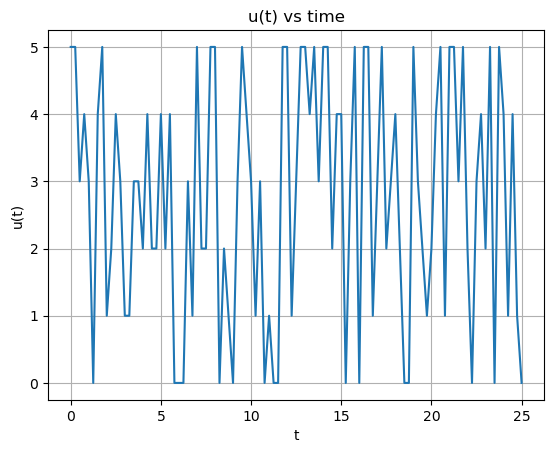

In [48]:
x = np.linspace(0, T, N+1)
plt.plot(x, u_t)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

## Last Trajectory


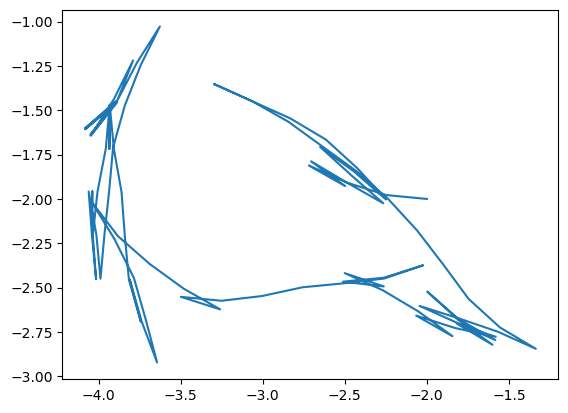

In [49]:
obs=np.array(observation_t)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.show()

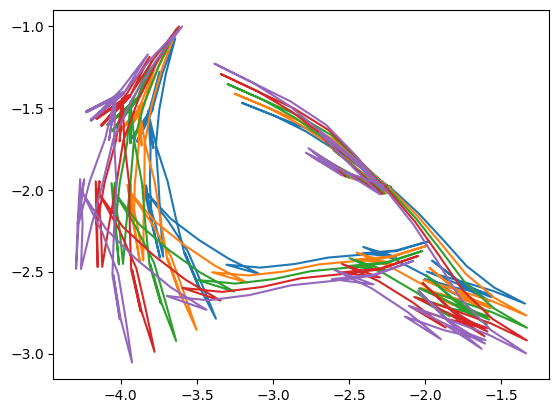

39.66602492591923


In [50]:
pos=[]
for i in range(num_system):
    obs=np.array(position_t[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])
plt.show()
print(reward_raw(np.array(pos)))


## Best Trajectory

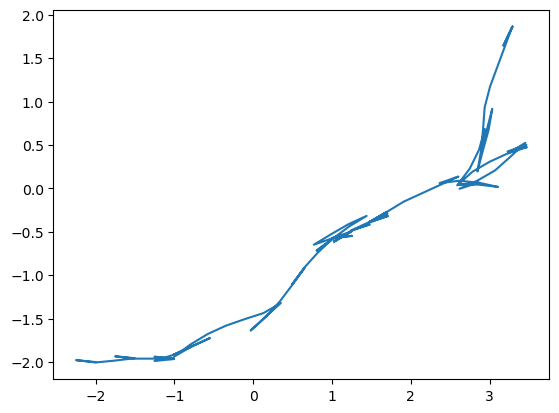

In [51]:
obs=np.array(best_obs)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.show()

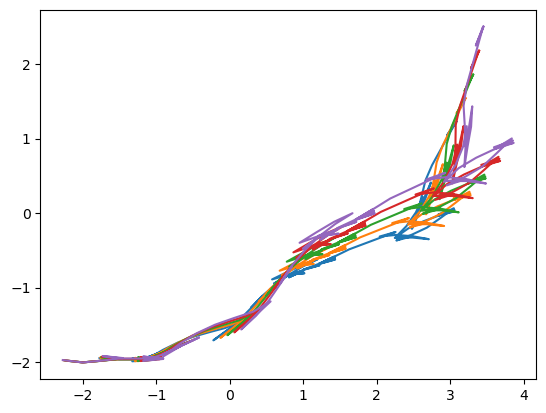

2.732990527099828


In [52]:
pos=[]
for i in range(num_system):
    obs=np.array(best_pos[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])
plt.show()
print(reward_raw(np.array(pos)))

## Pure Exploitation Trajectory

In [53]:
position=np.array([[-2,-2,0] for _ in range(num_system)])
observation=observe(position)
u_t=[]
observation_t=[observation]
position_t=[[] for i in range(num_system)]

for time in range(N+1):           
    candidates_u=[]
    for i in range(6):
        cand, _ = gpr_list[i].predict(observation.reshape(-1,5), return_std=True)
        candidates_u.append(cand[0])
    #print(candidates_u)
    u_k = decide_u_exploitation(observation,np.array(candidates_u))
    position_new = next_step(position,action_set[u_k])
    observation_new = observe(position_new)
    r = reward(observation_new)
    '''
    if explo:
        history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,5)))
        history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
    '''
    observation=observation_new
    position=position_new
    u_t.append(u_k)
    observation_t.append(observation)
    for i in range(num_system):
        position_t[i].append(position[i])
    '''
    if time%((N+1)//3+1)==0:
        for i in range(6):
            gpr_list[i]=GaussianProcessRegressor(alpha=1e-8).fit(history_su[i], history_r[i].reshape(-1,1))
    '''
    
obs=np.array(observation_t)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.show()

AttributeError: 'list' object has no attribute 'predict'

In [ ]:
for i in range(num_system):
    obs=np.array(position_t[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
plt.show()
print(reward_raw(position))